# Proyecto Telecom X - Etapa 2 - Machine Learning
## Previsión de Evasión (Churn) de clientes.
### Índice
- Descripción del proyecto
- Importación de bibliotecas y configuraciones
- Importación de librerías
- Paths
- Configuraciones
- Funciones
- Preprocesamiento de datos
- Encoding de variables categóricas
- Normalización de datos
- Correlación entre variables
- Análisis de multicolinealidad
- Análisis dirigido
- Modelado de datos
- Train Test split
- Escalado de variables numéricas
- Balance del dataset
- Baseline Model - Decision Tree Classifier
- Random Forest Classifier
- Support Vector Machine
- Evaluación Best Models
- Métricas Generales
- Subajuste (Underfitting) y Sobreajuste (Overfitting)
- Matrices de confusión
- Importancias y Coeficientes
- Champion Model
- Pipeline de prueba en entorno productivo
- Generación de datos artificiales
- Pipeline de prueba

# 1. Presentación del proyecto

Con el objetivo de adelantarse al inconveniente de las cancelaciones identificado previamente, la compañía desarrollará en este notebook un flujo de trabajo sólido para la fase inicial de construcción de modelos. Este proceso incluirá las siguientes actividades:

Procesamiento y acondicionamiento de los datos (incluyendo transformación, codificación y estandarización).

Exploración de relaciones entre variables y selección de atributos relevantes.

Implementación de diversos algoritmos de clasificación, análisis de su desempeño mediante indicadores específicos y comprensión de los resultados obtenidos.

Como cierre, se elaborará un informe con una perspectiva estratégica que destaque los factores determinantes en el fenómeno de cancelación.

# 2. Importación de librerías y configuraciones

## Importación de librerías

In [607]:
# Importanto las librerías, bibliotecas y configuraciones necesarias

import numpy as np
import pandas as pd
import matplotlib
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go

import warnings
import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

from pathlib import Path
from typing import Tuple, Callable, List

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibratedClassifierCV

import xgboost
from xgboost import XGBClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.preprocessing import RobustScaler

## Paths

In [423]:
PROJECT_PATH = r'C:\Users\felip\OneDrive\Escritorio\Challenge_TelecomX_ML\Notebook'

src = Path('src')
DATA_PATH = PROJECT_PATH / src

img = Path('img')
IMG_PATH = PROJECT_PATH / img

models = Path('models')
MODELS_PATH = PROJECT_PATH / models

reports = Path('reports')
REPORTS_PATH = PROJECT_PATH / reports


champion = Path('champion')
CHAMPION_PATH = PROJECT_PATH / champion

champion_preduction = Path('production')
champion_monitor = Path('monitor')

PRODUCTION_PATH = CHAMPION_PATH / 'log' / champion_preduction
MONITOR_PATH = CHAMPION_PATH / 'log' / champion_monitor

dirs = [DATA_PATH, IMG_PATH, MODELS_PATH, REPORTS_PATH, CHAMPION_PATH, PRODUCTION_PATH, MONITOR_PATH]


for directory in dirs:
    if not directory.exists():
        directory.mkdir(parents=True)
        print(f'Directoryo creado:\n{directory}\n')
    else:
        print(f'El directorio ya existe:\n{directory}\n')

El directorio ya existe:
C:\Users\felip\OneDrive\Escritorio\Challenge_TelecomX_ML\Notebook/src

El directorio ya existe:
C:\Users\felip\OneDrive\Escritorio\Challenge_TelecomX_ML\Notebook/img

El directorio ya existe:
C:\Users\felip\OneDrive\Escritorio\Challenge_TelecomX_ML\Notebook/models

El directorio ya existe:
C:\Users\felip\OneDrive\Escritorio\Challenge_TelecomX_ML\Notebook/reports

El directorio ya existe:
C:\Users\felip\OneDrive\Escritorio\Challenge_TelecomX_ML\Notebook/champion

El directorio ya existe:
C:\Users\felip\OneDrive\Escritorio\Challenge_TelecomX_ML\Notebook/champion/log/production

El directorio ya existe:
C:\Users\felip\OneDrive\Escritorio\Challenge_TelecomX_ML\Notebook/champion/log/monitor



## Funciones

In [424]:
def metricas_evaluacion(modelo,
                       x_test: pd.core.frame.DataFrame,
                       y_test: pd.core.series.Series,
                       nombre: str,
                       conjunto: str,
                       umbral: float=None):
  if umbral == None:
        metricas = {}
        y_pred = modelo.predict(x_test)
        metricas['Model'] = nombre
        metricas['Dataset'] = conjunto
        metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
        metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
        metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
        metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(x_test)[:, 1]
            metricas['AUC'] = np.round(roc_auc_score(y_test, y_proba), 4)
        else:
            metricas['AUC'] = '---'
        metricas['Umbral'] = 0.50 # Added default umbral here
  else: # This else was causing the indentation error
        if hasattr(modelo, "predict_proba"):
            metricas = {}
            probs = modelo.predict_proba(x_test)[:, 1]
            y_pred = (probs >= umbral).astype(int)
            metricas['Model'] = nombre
            metricas['Dataset'] = conjunto
            metricas['Accuracy'] = np.round(accuracy_score(y_test, y_pred), 4)
            metricas['Precision'] = np.round(precision_score(y_test, y_pred), 4)
            metricas['Recall'] = np.round(recall_score(y_test, y_pred), 4)
            metricas['F1-score'] = np.round(f1_score(y_test, y_pred), 4)
            metricas['AUC'] = np.round(roc_auc_score(y_test, probs), 4)
            metricas['Umbral'] = umbral
        else:
            raise ValueError('El modelo no cuenta con el método "predict_proba"') # Corrected ValueEror to ValueError

  return metricas # This return statement was also part of the indentation issue

In [425]:
def cv_score_interval(results,
                      nombre: str,
                      score:str='Recall'):

    score_mean = np.round(results['test_score'].mean(), 4)
    score_stdev = np.round(results['test_score'].std(), 4)
    lower_b = np.round(score_mean - 2 * score_stdev, 4)
    upper_b = np.round(min(1, score_mean + 2 * score_stdev), 4)

    print(f'Recall promedio de {nombre}: {score_mean}')
    print(f'Desviación estándar del Recall de {nombre}: {score_stdev}')
    print(f'El {score} de {nombre} estará entre [{lower_b:.4f},{upper_b:.4f}] con un 95% de confianza')

In [499]:
def boxplot_churn(df: pd.DataFrame,
                  ycol: str,
                  ylabel: str=None,
                  title_translate: str=None):
  if ylabel is None:
        ylabel = ycol
  if title_translate is None:
        title_translate = ycol

  fig, ax = plt.subplots(figsize=(8, 5))

  ax = sns.boxplot(data=df, x='Churn', y=ycol, hue='Churn', palette=churn_colors)
  plt.title(f'Distribución de {title_translate} según\nChurn de clientes', fontsize=18, pad=20)
  plt.xlabel('Churn', fontsize=15)
  plt.ylabel(ylabel, fontsize=15)
  plt.xticks(fontsize=13)
  plt.grid(True)

  fig.savefig(IMG_PATH /f'boxplot_Evasión_{ycol}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')
  plt.show()
  return fig



In [427]:
def plot_conf_mat(model,
                  x: pd.core.frame.DataFrame,
                  y: pd.core.series.Series,
                  name: str,
                  save: str,
                  save_path: Path=IMG_PATH,
                  umbral: float=None):

      if umbral == None:
        y_pred = model.predict(x)
      else:
        y_probs = model.predict_proba(x)[:, 1]
        y_pred = (y_probs >= umbral).astype(int)

      confmat = confusion_matrix(y_true=y, y_pred=y_pred)

      confmat_plot = ConfusionMatrixDisplay(confmat, display_labels=['Retención', 'Evasión'])

      fig, ax = plt.subplots(figsize=(10,6))
      confmat_plot.plot(ax=ax, cmap=custom_cmap, colorbar=False, text_kw={'color': 'black', 'fontweight': 'bold'})

      plt.title(name, fontsize=18, fontweight='bold')
      plt.xlabel('Predicted Label', fontsize=16)
      plt.ylabel('True Label', fontsize=16)
      plt.tick_params(axis='both', labelsize=13)

      plt.subplots_adjust(right=0.88)
      plt.tight_layout(pad=3.0)

      fig.savefig(save_path / f'confmat_{save}.png',
                  transparent=True,
                  dpi=300,
                  bbox_inches=None)

In [428]:
def plot_precision_recall_curve(modelo,
                                x: pd.core.frame.DataFrame,
                                y: pd.core.series.Series,
                                nombre:str):
    y_pred = modelo.predict_proba(x)[:, 1]

    # Calcular precisión, recall y umbrales
    precision, recall, thresholds = precision_recall_curve(y, y_pred)

    # Graficar la curva
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', color=COLOR_7, label='Baseline Model')
    plt.title(f'{nombre}: Curva Precision-Recall', fontsize=18, fontweight='bold')
    plt.xlabel('Recall', fontsize=13)
    plt.ylabel('Precision', fontsize=13)

    plt.grid(True, alpha=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()

In [429]:
def plot_umbrales(modelo,
                  score: str,
                  x: pd.core.frame.DataFrame,
                  y: pd.core.series.Series,
                  caja_x: float,
                  caja_y: float,
                  nombre: str):
    umbrales = np.linspace(0.0, 1.0, 100)
    scores = []
    if hasattr(modelo, 'predict_proba'):
        modelo_pred_proba = modelo.predict_proba(x)[:, 1]
    else:
        raise ValueError('El modelo no cuenta con el método predict_proba')
    for t in umbrales:
        y_pred = (modelo_pred_proba >= t).astype(int)
        scores.append(f1_score(y, y_pred))

    fig, ax = plt.subplots(figsize=(7,5))
    plt.suptitle(nombre, fontsize=18, fontweight='bold')

    plt.plot(umbrales, scores, label='F1-Score', color=COLOR_6)
    plt.title(f'{score} vs Umbral', fontsize=15)
    plt.xlabel("Umbral de decisión", fontsize=13)
    plt.ylabel(score, fontsize=13)

    plt.grid(True, alpha=0.3)


    idx_max = np.argmax(scores)
    mejor_umbral = umbrales[idx_max]
    mejor_valor = scores[idx_max]
    plt.scatter(mejor_umbral, mejor_valor, color=COLOR_13, zorder=5)
    plt.annotate(
        f'Umbral óptimo\nsegún F1-score: {mejor_umbral:.2f}',
        xy=(mejor_umbral, mejor_valor),
        xytext=(mejor_umbral + caja_x, mejor_valor - caja_y),
        arrowprops=dict(facecolor='black', arrowstyle='->'),
        bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3),
        fontsize=9
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return fig

In [430]:
def generar_tabla(df,
                 title: str,
                 save: str,
                 figsize: Tuple=(8,6),
                 path: Path=IMG_PATH):
  # Crear tabla para exportar como imagen
    fig, ax = plt.subplots(figsize=figsize)
    # Eliminar los ejes
    ax.axis('off')

    colors = [COLOR_1, COLOR_4]


    color_order = []
    for i in range(len(df)):
        if i % 2 == 0:
            color_order.append(colors[0])
        else:
            color_order.append(colors[1])
    max_rate = max(df, key=lambda x: x[1])
    idx_max = df[df == max_rate].index[0]

    cols_names = df.columns
    cell_colors = [[color, color, color, color] for color in color_order]
    table = df.values.tolist()

    for row in table:
        row[1] = np.round(row[1], 4)
    tabla = ax.table(cellText=table,
                     colLabels=cols_names,
                     cellLoc='center',
                     loc='center',
                     colColours=[COLOR_6 for i in range(df.shape[0])],
                     cellColours=cell_colors)

    tabla.auto_set_font_size(False)
    for (row, col), cell in tabla.get_celld().items():
        cell.set_fontsize(10)

    plt.title(f'{title}', fontsize=18, fontweight='bold')

    # Escalar la tabla para mayor legibilidad
    tabla.scale(1, 2)

    plt.tight_layout()

    fig.savefig(path / f'{save}.png', transparent=True, dpi=300, bbox_inches='tight')


    plt.show()


In [431]:
def plot_analisis_variables(df: pd.core.frame.DataFrame,
                            analisis: str,
                            nombre_modelo: str,
                            save: str,
                            n_vars: int= None,
                            save_path: Path=IMG_PATH,
                            space: float=0.5):

    if analisis != 'Coeficiente' and analisis != 'Importancia':
        raise ValueError('Solo permite los valores "Importancia" o "Coeficiente" para el parámetro <analisis>')

    if n_vars:
        if analisis == 'Coeficiente':
            n_vars = int(n_vars / 2)
            df1 = df.head(n_vars)
            df2 = df.tail(n_vars)
            df = pd.concat([df1, df2])
        else:
            df = df.head(n_vars)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(data=df, x=analisis, y='Feature', orient='h', hue=analisis, palette=custom_cmap)
    plt.title(f'{analisis}s de Variables - {nombre_modelo}', fontsize=18, loc='left')
    plt.xlabel(analisis, fontsize=16)
    plt.ylabel('Feature', fontsize=16)


    x_max = df[analisis].max()
    x_min = df[analisis].min()

    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height() / 2
        if width != 0:
            if analisis == 'Coeficiente':
                if width > 0:
                    ax.text(
                        (width + (x_max * space)), y,
                        f'{width:.4f}',
                        ha='right', va='center',
                        fontsize=9, color='black', fontweight='bold')
                else:
                    ax.text(
                        (width - (x_max * space)), y,
                        f'{width:.4f}',
                        ha='left', va='center',
                        fontsize=9, color='black', fontweight='bold')
            else:
                ax.text(
                    (width + (x_max * space)), y,
                    f'{width*100:.2f}%',
                    ha='center', va='center',
                    fontsize=9, color='black', fontweight='bold'
                    )

    sns.despine()
    if analisis == 'Coeficiente':
        plt.xlim(x_min-1, x_max+1)
    plt.tight_layout()

    fig.savefig(IMG_PATH / f'{analisis}_variables_{save}.png',
                transparent=False,
                dpi=300,
                bbox_inches='tight')

    plt.show()

## Configuraciones

In [432]:
# Estandarización de colores

sns.set_palette('viridis')
churn_colors = ['#440154', '#fde725']

# Colores del proyecto
COLOR_1, COLOR_2, COLOR_3, COLOR_4 = '#440154', '#482878', '#3e4a89', '#31688e'
COLOR_5, COLOR_6, COLOR_7, COLOR_8 = '#26828e', '#1f9e89', '#35b779', '#68cd5e'
COLOR_9, COLOR_10, COLOR_11, COLOR_12 = '#a5da36', '#e2f418', '#fde725', '#bada55'
COLOR_13, COLOR_14, COLOR_15, COLOR_16 = '#800020', '#bd0026', '#f03b20', '#fd8d3c'

# Definir los colores personalizados
custom_colors = [
    COLOR_1, COLOR_2, COLOR_3, COLOR_4,
    COLOR_5, COLOR_6, COLOR_7, COLOR_8,
    COLOR_9, COLOR_10, COLOR_11, COLOR_12,
    COLOR_13, COLOR_14, COLOR_15, COLOR_16,
]

# Crear el colormap personalizado
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

# 3. Preprocesamiento de datos

Outliers se consideran muy importantes para el caso de clientes que abandonan la empresa, por lo que serán considerados.

Importaremos un archivo Json con la información pre-procesada del challenge anterior.

In [433]:
URL = "https://raw.githubusercontent.com/FelipeOctavio87/Proyecto_TelecomX_ML/refs/heads/main/preprocessed_TelecomX_data.json"

datos = pd.read_json(URL)
datos.head()


customerID Churn  gender SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female            No     Yes        Yes       9   
1  0003-MKNFE    No    Male            No      No         No       9   
2  0004-TLHLJ   Yes    Male            No      No         No       4   
3  0011-IGKFF   Yes    Male           Yes     Yes         No      13   
4  0013-EXCHZ   Yes  Female           Yes     Yes         No       3   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0          Yes            No             DSL  ...               No   
1          Yes           Yes             DSL  ...               No   
2          Yes            No     Fiber optic  ...              Yes   
3          Yes            No     Fiber optic  ...              Yes   
4          Yes            No     Fiber optic  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes         Yes              No        One year              Yes   
1          No          No             Yes  Month-to-month               No   
2          No          No              No  Month-to-month              Yes   
3          No         Yes             Yes  Month-to-month              Yes   
4         Yes         Yes              No  Month-to-month              Yes   

      PaymentMethod Charges.Monthly Charges.Total  Charges.Daily  
0      Mailed check            65.6        593.30           2.19  
1      Mailed check            59.9        542.40           2.00  
2  Electronic check            73.9        280.85           2.46  
3  Electronic check            98.0       1237.85           3.27  
4      Mailed check            83.9        267.40           2.80  

[5 rows x 22 columns]

In [434]:
datos.rename(columns={'customerID': 'CustomerID',
                      'Charges.Monthly': 'ChargesMonthly',
                      'Charges.Total': 'ChargesTotal',
                      'Charges.Daily': 'ChargesDaily',
                      'tenure': 'Tenure',
                      'gender': 'Gender',}, inplace=True)

In [435]:
try:
    URL = 'https://raw.githubusercontent.com/FelipeOctavio87/Proyecto_TelecomX_ML/refs/heads/main/alta_valoracion_clientes.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    datos = pd.concat([datos, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    datos = datos.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [436]:
datos.head(2)

CustomerID Churn  Gender SeniorCitizen Partner Dependents  Tenure  \
0  8562-GHPPI    No  Female            No      No         No       1   
1  5196-WPYOW    No    Male            No     Yes        Yes      67   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0          Yes            No              No  ...               No   
1          Yes            No             DSL  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month               No   
1         Yes          No              No        One year               No   

             PaymentMethod ChargesMonthly ChargesTotal  ChargesDaily  
0  Credit card (automatic)          19.80        19.80          0.66  
1             Mailed check          60.05      3994.05          2.00  

[2 rows x 22 columns]

In [437]:
datos = datos.drop(['CustomerID', 'ChargesDaily'], axis=1)

In [438]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7152 entries, 0 to 7151
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7152 non-null   object 
 1   Gender            7152 non-null   object 
 2   SeniorCitizen     7152 non-null   object 
 3   Partner           7152 non-null   object 
 4   Dependents        7152 non-null   object 
 5   Tenure            7152 non-null   int64  
 6   PhoneService      7152 non-null   object 
 7   MultipleLines     7152 non-null   object 
 8   InternetService   7152 non-null   object 
 9   OnlineSecurity    7152 non-null   object 
 10  OnlineBackup      7152 non-null   object 
 11  DeviceProtection  7152 non-null   object 
 12  TechSupport       7152 non-null   object 
 13  StreamingTV       7152 non-null   object 
 14  StreamingMovies   7152 non-null   object 
 15  Contract          7152 non-null   object 
 16  PaperlessBilling  7152 non-null   object 


In [439]:
datos.describe()

Tenure  ChargesMonthly  ChargesTotal
count  7152.000000     7152.000000   7152.000000
mean     32.851370       65.361955   2346.648399
std      24.684639       30.258020   2314.453371
min       0.000000       18.250000      0.000000
25%       9.000000       36.250000    410.837500
50%      30.000000       70.700000   1424.450000
75%      56.000000       90.400000   3949.575000
max      72.000000      118.750000   8684.800000

## Encoding de variables categóricas

En el DataFrame

df_processed se incluirán las variables categóricas transformadas mediante one_hot_encoder(drop='if_binary') y las variables numéricas sin normalizar, pensado para algoritmos resistentes a las diferencias de magnitud y a la multicolinealidad.

En el DataFrame
df_scaling, las variables categóricas también serán convertidas con one_hot_encoder(drop='if_binary'), pero las variables numéricas estarán estandarizadas, lo que lo hace apropiado para modelos que, aunque soportan correlaciones, requieren trabajar con datos en la misma escala.

Finalmente, en el DataFrame

df_recta contendrá variables categóricas procesadas con one_hot_encoder(drop='first') junto con variables numéricas normalizadas, ideal para algoritmos que presentan sensibilidad tanto a la escala de los datos como a problemas de multicolinealidad.

In [440]:
X = datos.drop('Churn', axis=1)
y = datos['Churn']

In [441]:
X_recta = X.copy()
y_recta = y.copy()

In [442]:
X

Gender SeniorCitizen Partner Dependents  Tenure PhoneService  \
0     Female            No      No         No       1          Yes   
1       Male            No     Yes        Yes      67          Yes   
2     Female            No     Yes         No      60          Yes   
3       Male            No     Yes         No       3           No   
4     Female            No      No         No      63          Yes   
...      ...           ...     ...        ...     ...          ...   
7147    Male            No      No         No      46          Yes   
7148  Female            No      No         No       1          Yes   
7149  Female            No      No         No       4          Yes   
7150    Male            No      No         No       1          Yes   
7151    Male            No     Yes        Yes      52          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0               No              No             No           No   
1               No             DSL            Yes          Yes   
2              Yes     Fiber optic             No          Yes   
3               No             DSL            Yes           No   
4              Yes             DSL            Yes          Yes   
...            ...             ...            ...          ...   
7147            No              No             No           No   
7148            No              No             No           No   
7149           Yes              No             No           No   
7150            No              No             No           No   
7151           Yes              No             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                  No         Yes          No              No        One year   
2                  No          No         Yes             Yes  Month-to-month   
3                  No         Yes          No              No  Month-to-month   
4                 Yes         Yes         Yes              No        Two year   
...               ...         ...         ...             ...             ...   
7147               No          No          No              No        Two year   
7148               No          No          No              No  Month-to-month   
7149               No          No          No              No        One year   
7150               No          No          No              No  Month-to-month   
7151               No          No          No              No        Two year   

     PaperlessBilling            PaymentMethod  ChargesMonthly  ChargesTotal  
0                  No  Credit card (automatic)           19.80         19.80  
1                  No             Mailed check           60.05       3994.05  
2                 Yes         Electronic check           99.80       5985.75  
3                  No             Mailed check           35.10        101.10  
4                 Yes  Credit card (automatic)           79.85       4861.45  
...               ...                      ...             ...           ...  
7147               No         Electronic check           19.95        907.05  
7148               No             Mailed check           19.15         19.15  
7149               No         Electronic check           23.90         97.50  
7150               No             Mailed check           19.55         19.55  
7151               No             Mailed check           24.80       1229.10  

[7152 rows x 19 columns]

In [443]:
variables_categoricas = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [444]:
one_hot = make_column_transformer(
                    (OneHotEncoder(drop='if_binary'), variables_categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

one_hot_linear = make_column_transformer(
                    (OneHotEncoder(drop='first'), variables_categoricas),
                    remainder='passthrough',
                    sparse_threshold=0,
                    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

In [445]:
X = one_hot.fit_transform(X)
X_recta = one_hot_linear.fit_transform(X_recta)

y = label_encoder.fit_transform(y)
y_recta = label_encoder.fit_transform(y_recta)

In [446]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [447]:
df_processed = pd.DataFrame(X, columns=columnas_encoded)
df_processed_y = pd.DataFrame(y, columns=['Churn'])
df_processed = pd.concat([df_processed, df_processed_y], axis=1)
df_processed.head()

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
0          0.0                0.0          0.0             0.0   
1          1.0                0.0          1.0             1.0   
2          0.0                0.0          1.0             0.0   
3          1.0                0.0          1.0             0.0   
4          0.0                0.0          0.0             0.0   

   PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
0               1.0                0.0                  0.0   
1               1.0                0.0                  1.0   
2               1.0                1.0                  0.0   
3               0.0                0.0                  1.0   
4               1.0                1.0                  1.0   

   InternetService_Fiber optic  InternetService_No  OnlineSecurity_Yes  ...  \
0                          0.0                 1.0                 0.0  ...   
1                          0.0                 0.0                 1.0  ...   
2                          1.0                 0.0                 0.0  ...   
3                          0.0                 0.0                 1.0  ...   
4                          0.0                 0.0                 1.0  ...   

   Contract_Two year  PaperlessBilling_Yes  \
0                0.0                   0.0   
1                0.0                   0.0   
2                0.0                   1.0   
3                0.0                   0.0   
4                1.0                   1.0   

   PaymentMethod_Bank transfer (automatic)  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                    1.0                             0.0   
1                                    0.0                             0.0   
2                                    0.0                             1.0   
3                                    0.0                             0.0   
4                                    1.0                             0.0   

   PaymentMethod_Mailed check  Tenure  ChargesMonthly  ChargesTotal  Churn  
0                         0.0     1.0           19.80         19.80      0  
1                         1.0    67.0           60.05       3994.05      0  
2                         0.0    60.0           99.80       5985.75      0  
3                         1.0     3.0           35.10        101.10      0  
4                         0.0    63.0           79.85       4861.45      0  

[5 rows x 27 columns]

In [448]:
columnas = one_hot_linear.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [449]:
df_recta = pd.DataFrame(X_recta, columns=columnas_encoded)
df_y_recta = pd.DataFrame(y_recta, columns=['Churn'])
df_recta = pd.concat([df_recta, df_y_recta], axis=1)
df_recta.head()

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
0          0.0                0.0          0.0             0.0   
1          1.0                0.0          1.0             1.0   
2          0.0                0.0          1.0             0.0   
3          1.0                0.0          1.0             0.0   
4          0.0                0.0          0.0             0.0   

   PhoneService_Yes  MultipleLines_Yes  InternetService_Fiber optic  \
0               1.0                0.0                          0.0   
1               1.0                0.0                          0.0   
2               1.0                1.0                          1.0   
3               0.0                0.0                          0.0   
4               1.0                1.0                          0.0   

   InternetService_No  OnlineSecurity_Yes  OnlineBackup_Yes  ...  \
0                 1.0                 0.0               0.0  ...   
1                 0.0                 1.0               1.0  ...   
2                 0.0                 0.0               1.0  ...   
3                 0.0                 1.0               0.0  ...   
4                 0.0                 1.0               1.0  ...   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                0.0                0.0                   0.0   
1                1.0                0.0                   0.0   
2                0.0                0.0                   1.0   
3                0.0                0.0                   0.0   
4                0.0                1.0                   1.0   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                    1.0                             0.0   
1                                    0.0                             0.0   
2                                    0.0                             1.0   
3                                    0.0                             0.0   
4                                    1.0                             0.0   

   PaymentMethod_Mailed check  Tenure  ChargesMonthly  ChargesTotal  Churn  
0                         0.0     1.0           19.80         19.80      0  
1                         1.0    67.0           60.05       3994.05      0  
2                         0.0    60.0           99.80       5985.75      0  
3                         1.0     3.0           35.10        101.10      0  
4                         0.0    63.0           79.85       4861.45      0  

[5 rows x 24 columns]

In [450]:
df_processed.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)
df_recta.rename(columns={'InternetService_No': 'NoInternetService'}, inplace=True)

In [451]:
df_scaling = df_processed.copy()

Normalización de datos

Aunque ciertos algoritmos, como Random Forest, no requieren procesos de normalización (dado que su funcionamiento se apoya en reglas de comparación del tipo mayor o menor que, y no en cálculos de distancia), se llevará a cabo la revisión de las variables numéricas. Esto se debe a que el objetivo del proyecto es experimentar con diversos modelos y compararlos, con el fin de identificar cuál ofrece el mejor rendimiento para ser implementado en producción.

In [452]:
def bin_width(df_processed, columna):
    n = df_processed.shape[0]
    iqr = df_processed[columna].quantile(0.75) - df_processed[columna].quantile(0.25)

    bin_width = 2 * (iqr / np.cbrt(n))
    return bin_width

In [453]:
scaling_tenure = StandardScaler()
scaling_chargesmonthly = StandardScaler()
scaling_chargestotal = StandardScaler()

In [454]:
robust_tenure = RobustScaler()
robust_chargesmonthly = RobustScaler()
robust_chargestotal = RobustScaler()

Tenure

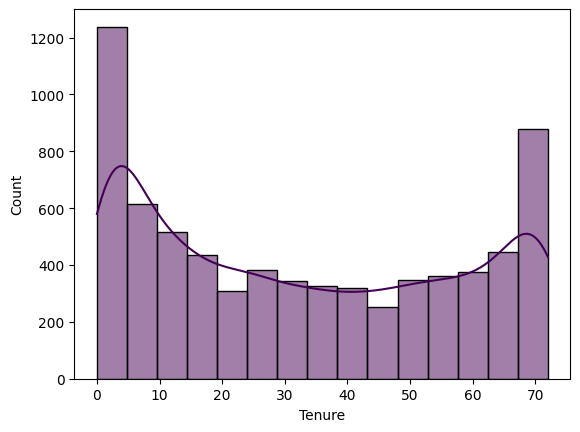

In [455]:
BIN_WIDTH = bin_width(df_processed, 'Tenure')

sns.histplot(df_processed['Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

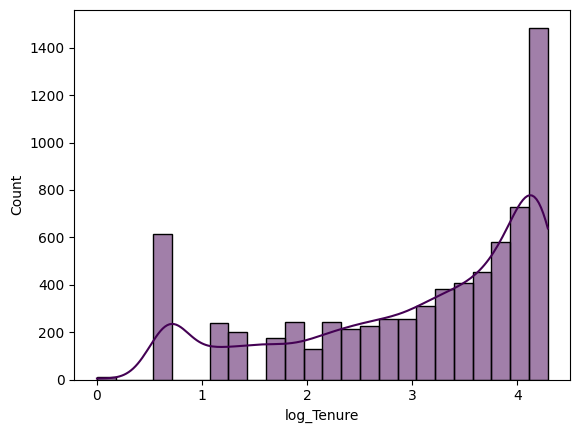

In [456]:
df_processed['log_Tenure'] = np.log(df_processed['Tenure'] + 1)
BIN_WIDTH = bin_width(df_processed, 'log_Tenure')

sns.histplot(df_processed['log_Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

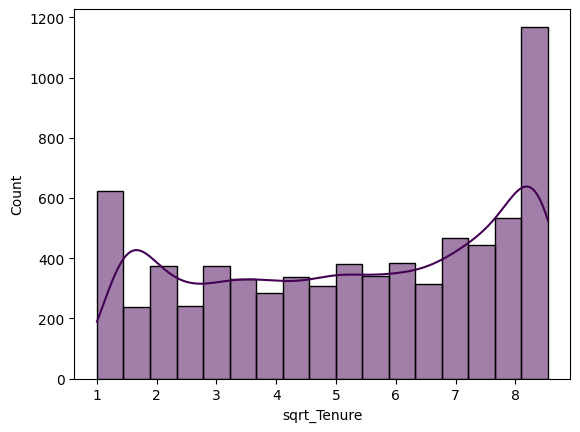

In [457]:
df_processed['sqrt_Tenure'] = np.sqrt(df_processed['Tenure'] + 1)
BIN_WIDTH = bin_width(df_processed, 'sqrt_Tenure')

sns.histplot(df_processed['sqrt_Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

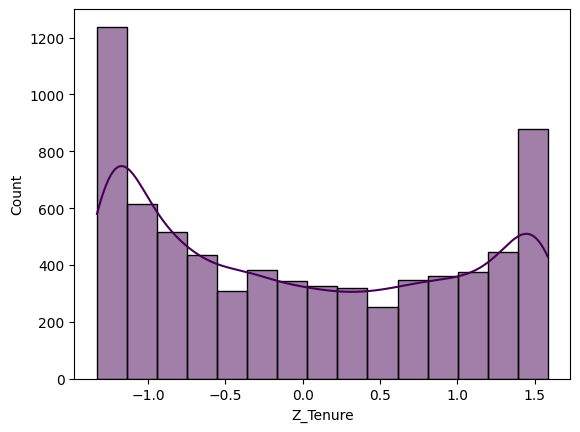

In [458]:
df_processed['Z_Tenure'] = scaling_tenure.fit_transform(df_processed[['Tenure']])
BIN_WIDTH = bin_width(df_processed, 'Z_Tenure')

sns.histplot(df_processed['Z_Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

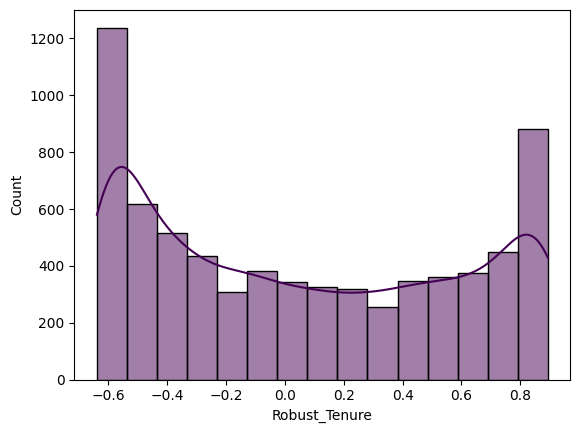

In [459]:
df_processed['Robust_Tenure'] = robust_tenure.fit_transform(df_processed[['Tenure']])
BIN_WIDTH = bin_width(df_processed, 'Robust_Tenure')

sns.histplot(df_processed['Robust_Tenure'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

Charges Montly

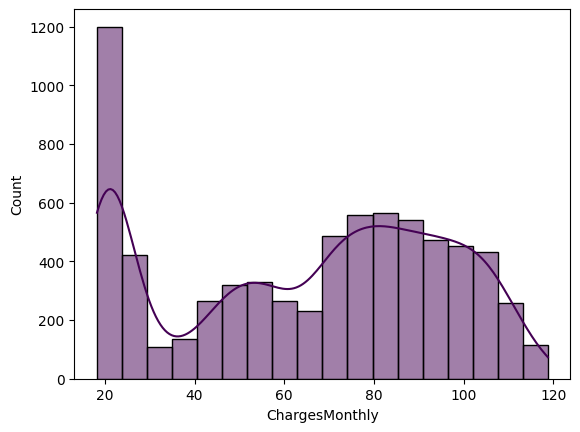

In [460]:
BIN_WIDTH = bin_width(df_processed, 'ChargesMonthly')

sns.histplot(df_processed['ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

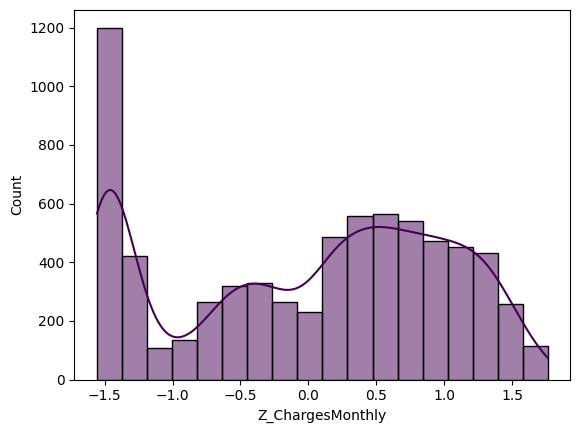

In [461]:
df_processed['Z_ChargesMonthly'] = scaling_chargesmonthly.fit_transform(df_processed[['ChargesMonthly']])
BIN_WIDTH = bin_width(df_processed, 'Z_ChargesMonthly')

sns.histplot(df_processed['Z_ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

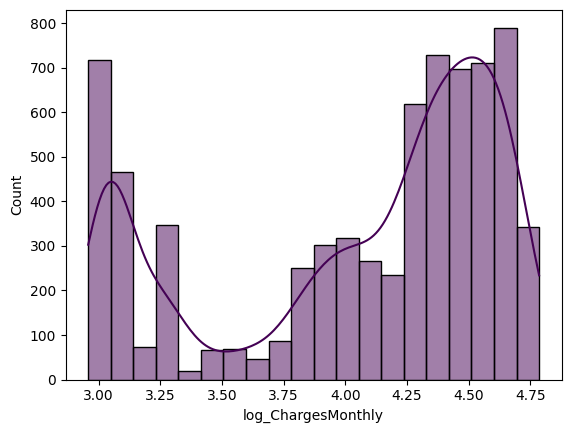

In [462]:
df_processed['log_ChargesMonthly'] = np.log(df_processed['ChargesMonthly'] + 1)
BIN_WIDTH = bin_width(df_processed, 'log_ChargesMonthly')

sns.histplot(df_processed['log_ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

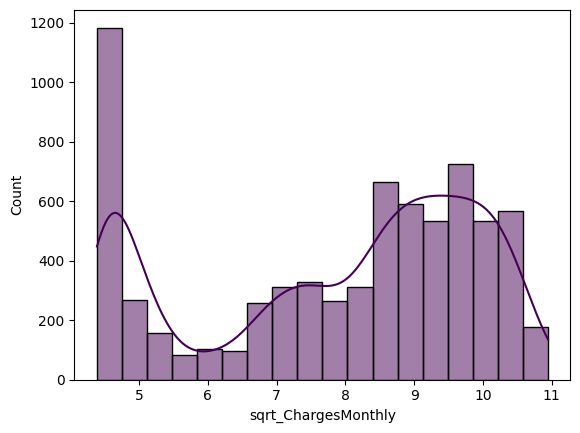

In [463]:
df_processed['sqrt_ChargesMonthly'] = np.sqrt(df_processed['ChargesMonthly'] + 1)
BIN_WIDTH = bin_width(df_processed, 'sqrt_ChargesMonthly')

sns.histplot(df_processed['sqrt_ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

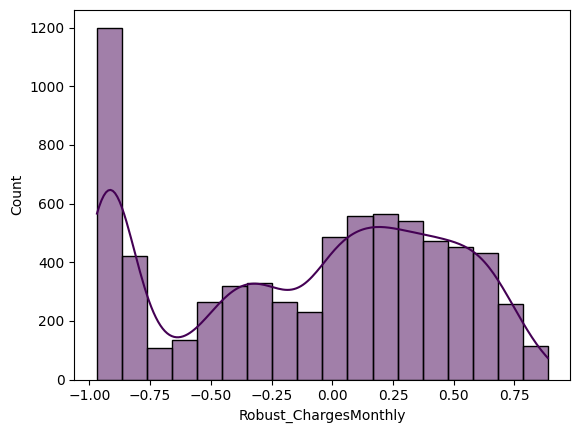

In [464]:
df_processed['Robust_ChargesMonthly'] = robust_chargesmonthly.fit_transform(df_processed[['ChargesMonthly']])
BIN_WIDTH = bin_width(df_processed, 'Robust_ChargesMonthly')

sns.histplot(df_processed['Robust_ChargesMonthly'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

Charges Total

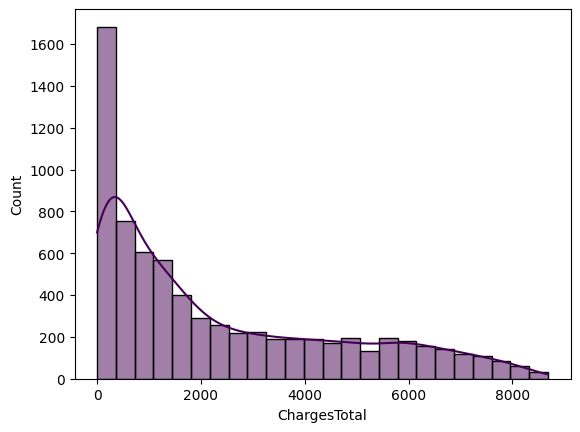

In [465]:
BIN_WIDTH = bin_width(df_processed, 'ChargesTotal')

sns.histplot(df_processed['ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

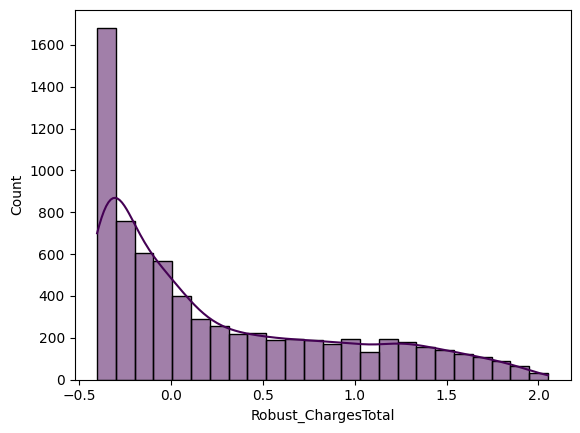

In [466]:
df_processed['Robust_ChargesTotal'] = robust_chargestotal.fit_transform(df_processed[['ChargesTotal']])
BIN_WIDTH = bin_width(df_processed, 'Robust_ChargesTotal')

sns.histplot(df_processed['Robust_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

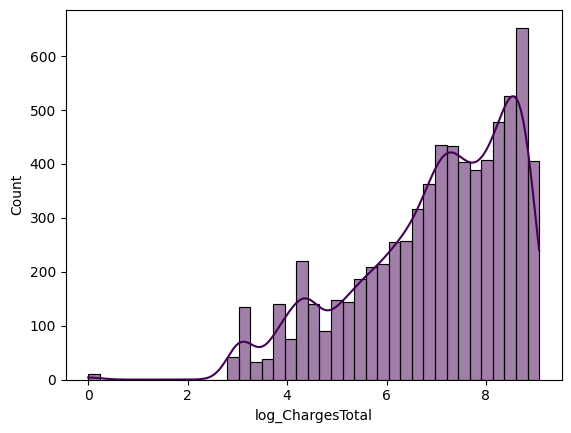

In [467]:
df_processed['log_ChargesTotal'] = np.log(df_processed['ChargesTotal'] + 1)
BIN_WIDTH = bin_width(df_processed, 'log_ChargesTotal')

sns.histplot(df_processed['log_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

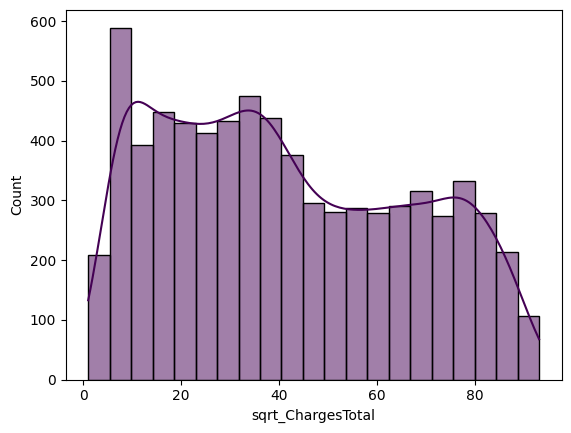

In [468]:
df_processed['sqrt_ChargesTotal'] = np.sqrt(df_processed['ChargesTotal'] + 1)
BIN_WIDTH = bin_width(df_processed, 'sqrt_ChargesTotal')

sns.histplot(df_processed['sqrt_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

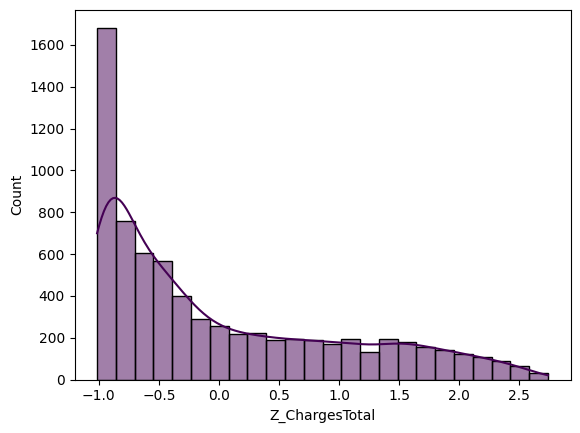

In [469]:
df_processed['Z_ChargesTotal'] = scaling_chargestotal.fit_transform(df_processed[['ChargesTotal']])
BIN_WIDTH = bin_width(df_processed, 'Z_ChargesTotal')

sns.histplot(df_processed['Z_ChargesTotal'], binwidth=BIN_WIDTH, color=churn_colors[0], kde=True)
plt.show()

Observaciones: Normalización de datos


Se aprecia que ninguna de las transformaciones aplicadas logra corregir la asimetría positiva (sesgo a la derecha) presente en la variable ChargesTotal. Dado su carácter acumulativo, es esperable que este tipo de métricas concentre la mayor parte de las observaciones en valores bajos, presentando únicamente cuantías elevadas en un subconjunto reducido de clientes. Asimismo, se decidió conservar los registros catalogados como atípicos (outliers) —clientes de alto valor que abandonaron la compañía—, puesto que resulta fundamental identificar qué atributos comparten con clientes de menor contribución, lo cual revela zonas críticas de intervención para disminuir la probabilidad de deserción (Churn).

Las variables Tenure y ChargesMonthly exhiben una distribución bimodal persistente bajo todas las transformaciones aplicadas.

En consecuencia, se optará por mantener las variables métricas en su forma original y evaluar la capacidad de los modelos para gestionarlas adecuadamente. En caso contrario, se implementará RobustScaler, dado que preserva la forma de la distribución, atenuando el impacto de valores extremos y ajustando las escalas en aquellos algoritmos sensibles a la magnitud de los datos.

In [470]:
df_processed = df_processed.drop(['log_Tenure', 'sqrt_Tenure', 'Z_Tenure', 'Robust_Tenure',
              'log_ChargesMonthly', 'sqrt_ChargesMonthly', 'Z_ChargesMonthly', 'Robust_ChargesMonthly',
              'log_ChargesTotal', 'sqrt_ChargesTotal', 'Z_ChargesTotal', 'Robust_ChargesTotal'], axis=1)

In [471]:
df_processed.shape


(7152, 27)

Correlación entre las variables

In [472]:
corr = df_processed.corr()

In [473]:
# Máscara booleanda para el triángulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

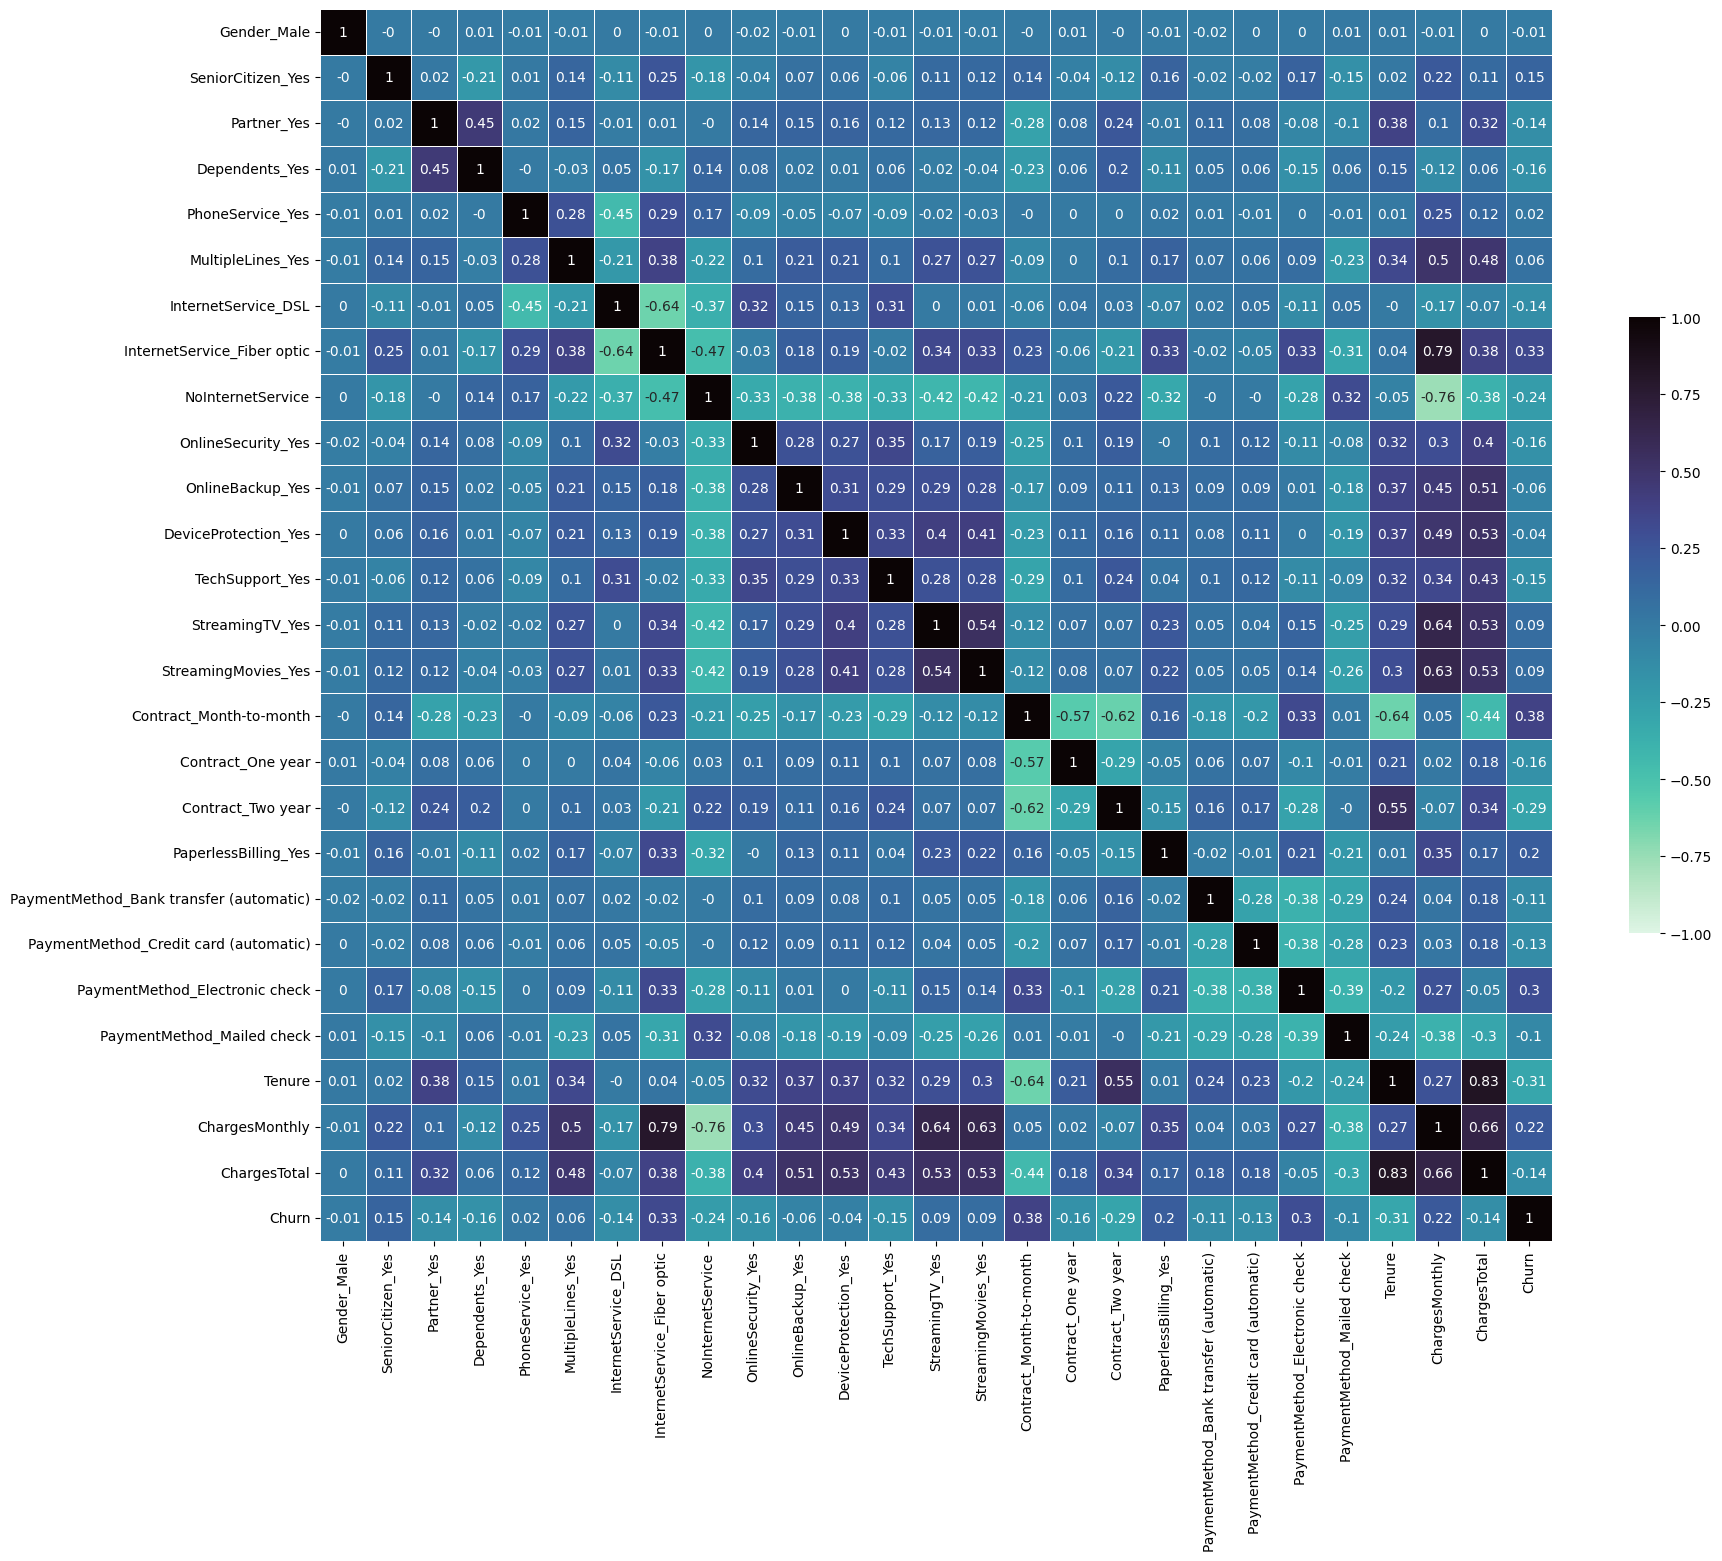

In [474]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
plt.show()

In [475]:
cols = corr.loc['Churn'].abs()[corr.loc['Churn'].abs() > 0.07].index
corr_selected = corr[cols].loc[cols]  # Subset del DataFrame completo

In [476]:
# Máscara booleana para el triángulo superior
mascara = np.zeros_like(corr_selected, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

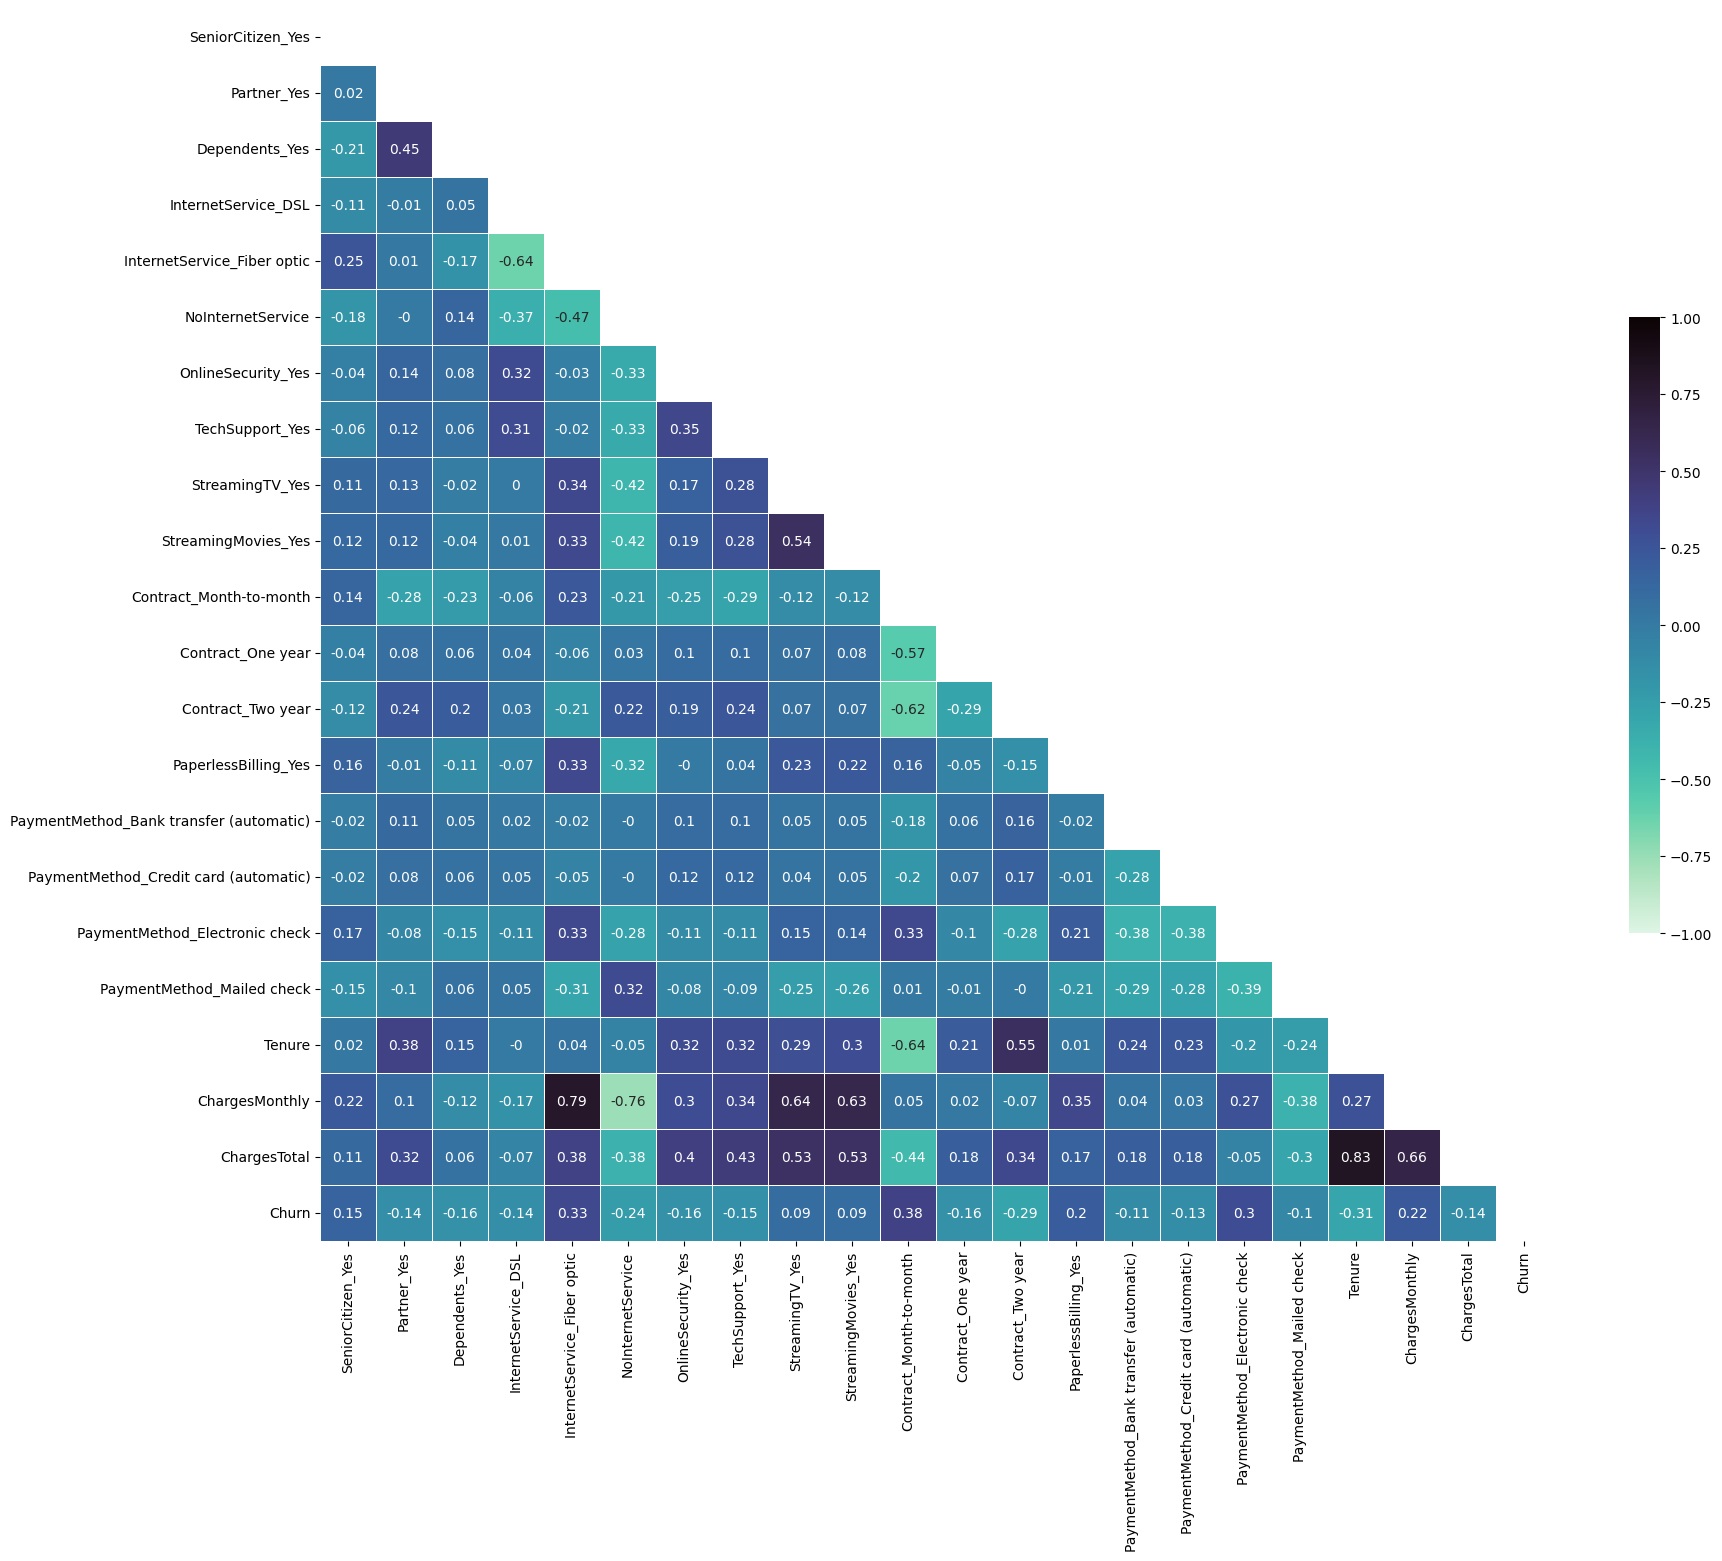

In [477]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(corr_selected, 2), mask=mascara, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5}, cmap='mako_r')
fig.savefig(IMG_PATH / 'corr_matrix.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

Fuerte relación positiva entre estas 2 variables_ ChargesTotal y Tenure.

Es posible que ChargesTotal sea ya explicada entre Tenure y ChargesMonthly.

Para verificar este fenómeno, se llevará a cabo un análisis de colinealidad, a través de Variance Inflation Factor (VIF)

Análisis de multicolinealidad


El Variance Inflation Factor (VIF) constituye una medida diagnóstica de multicolinealidad que, en términos operativos, estima una regresión lineal tomando cada predictor de forma individual como variable dependiente y evaluando qué proporción de su varianza puede ser explicada por el resto de las variables independientes.

De manera general, se interpretan los valores de la siguiente forma:

1 < VIF < 5 → Nivel aceptable de colinealidad.

5 < VIF < 10 → La variable puede mantenerse, aunque podría implicar cierta redundancia.

VIF ≥ 10 → Evidencia de colinealidad severa con otras covariables, recomendándose su eliminación para evitar distorsión en las estimaciones del modelo.

En presencia de multicolinealidad, las variables conflictivas deben excluirse a fin de no comprometer la estabilidad de los coeficientes.

Para este análisis, se empleará el conjunto X_recta, generado a partir de la codificación con OneHotEncoder(drop='first'). Esta estrategia elimina la primera categoría de cada atributo categórico, previniendo la introducción artificial de colinealidad perfecta (la conocida trampa de las variables ficticias o dummy trap).

Adicionalmente, se aplicará un escalamiento a las variables continuas, ya que los procedimientos de regresión lineal son sensibles a la magnitud relativa de los predictores, y la normalización permite una estimación más estable y comparable de los coeficientes.

VIF 1

In [478]:
vif_robust_scaler = RobustScaler()

In [479]:
df_vif = df_recta.copy()

In [480]:
x_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']

X_vif_num = df_vif[x_num]

X_vif_num = vif_robust_scaler.fit_transform(X_vif_num)

df_vif[['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']] = X_vif_num

df_vif = df_vif.drop(['Tenure', 'ChargesMonthly', 'ChargesTotal'], axis=1)

In [481]:
X_vif = df_vif.drop('Churn', axis=1)

In [482]:
features = X_vif.columns

In [483]:
df_vif_1 = pd.DataFrame()
df_vif_1['Feature'] = features
df_vif_1['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

In [484]:
df_vif_1.sort_values('VIF', ascending=False)

Feature        VIF
22                    ChargesTotal_scaled  12.902310
21                  ChargesMonthly_scaled  11.696381
4                        PhoneService_Yes  10.048787
20                          Tenure_scaled   7.750051
6             InternetService_Fiber optic   6.817227
7                       NoInternetService   5.937551
15                      Contract_Two year   3.436684
12                        StreamingTV_Yes   3.055135
13                    StreamingMovies_Yes   3.029339
16                   PaperlessBilling_Yes   2.989310
18         PaymentMethod_Electronic check   2.967135
2                             Partner_Yes   2.846047
5                       MultipleLines_Yes   2.686302
19             PaymentMethod_Mailed check   2.394575
10                   DeviceProtection_Yes   2.322671
9                        OnlineBackup_Yes   2.159550
11                        TechSupport_Yes   2.102665
14                      Contract_One year   2.068524
0                             Gender_Male   2.025449
17  PaymentMethod_Credit card (automatic)   1.989295
3                          Dependents_Yes   1.968012
8                      OnlineSecurity_Yes   1.953893
1                       SeniorCitizen_Yes   1.377374

Observaciones VIF 1

Observaciones VIF 1
Tal como se evidenció en el análisis de correlación previo, las variables ChargesTotal y ChargesMonthly exhiben los valores más elevados de Variance Inflation Factor (VIF), indicando una relación de fuerte colinealidad:

Variable	VIF
ChargesTotal_scaled	12.902310
ChargesMonthly_scaled	11.696381

Es importante destacar que ChargesTotal representa esencialmente la suma acumulada de ChargesMonthly a lo largo de los períodos de Tenure, lo que genera una dependencia estructural entre ambas. En consecuencia, se procederá a excluir ChargesTotal del conjunto de predictores, con el fin de reducir la redundancia y evaluar nuevamente el comportamiento del Variance Inflation Factor, garantizando mayor estabilidad en las estimaciones del modelo.

VIF 2

In [485]:
X_vif = df_vif.copy()

In [486]:
X_vif = X_vif.drop(['ChargesTotal_scaled', 'Churn'], axis=1)

In [487]:
features = X_vif.columns
features

Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year',
       'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure_scaled', 'ChargesMonthly_scaled'],
      dtype='object')

In [488]:
df_vif_2 = pd.DataFrame()
df_vif_2['Feature'] = features
df_vif_2['VIF'] = [vif(X_vif[features], i) for i in range(len(features))]

In [489]:
df_vif_2.sort_values('VIF', ascending=False)

Feature        VIF
21                  ChargesMonthly_scaled  10.568394
4                        PhoneService_Yes  10.015450
6             InternetService_Fiber optic   6.736119
7                       NoInternetService   5.918196
15                      Contract_Two year   3.408953
12                        StreamingTV_Yes   3.017488
16                   PaperlessBilling_Yes   2.989275
13                    StreamingMovies_Yes   2.987107
18         PaymentMethod_Electronic check   2.964332
2                             Partner_Yes   2.845660
20                          Tenure_scaled   2.829294
5                       MultipleLines_Yes   2.668684
19             PaymentMethod_Mailed check   2.368017
10                   DeviceProtection_Yes   2.273198
9                        OnlineBackup_Yes   2.079832
14                      Contract_One year   2.068465
11                        TechSupport_Yes   2.064473
0                             Gender_Male   2.024696
17  PaymentMethod_Credit card (automatic)   1.988759
3                          Dependents_Yes   1.966942
8                      OnlineSecurity_Yes   1.913098
1                       SeniorCitizen_Yes   1.377318

Observaciones VIF posterior a la depuración

Tras la eliminación de la variable con mayor colinealidad (ChargesTotal_scaled), se observa que el VIF de Tenure_scaled disminuyó de 7.7500 a 2.8292, lo que constituye evidencia empírica de que ChargesTotal_scaled estaba en gran medida explicado por las otras dos covariables numéricas (Tenure_scaled y ChargesMonthly_scaled). Esto confirma la existencia de una fuerte relación de dependencia entre dichas variables.

No obstante, los factores de inflación de varianza asociados a ChargesMonthly_scaled y PhoneService_Yes permanecen en valores relativamente altos, superando de manera marginal el umbral crítico, lo que indica que la multicolinealidad no ha sido completamente mitigada.

En este contexto, es importante señalar que los modelos lineales —tales como LogisticRegression (sin regularización L1), LinearRegression o Support Vector Machines con kernel lineal— presentan alta sensibilidad a la multicolinealidad, ya que esta incrementa la varianza de los estimadores y dificulta la interpretación de los coeficientes.

Por contraste, los modelos no lineales como Random Forest, XGBoost o K-Nearest Neighbors son considerablemente más robustos ante la presencia de predictores correlacionados, e incluso pueden capitalizar la redundancia de información, ya que su estructura interna permite priorizar automáticamente las variables más relevantes para la predicción sin comprometer la estabilidad de los parámetros.

Por consiguiente, la estrategia adoptada consistirá en mantener todas las variables al entrenar modelos no lineales, mientras que en los modelos lineales se aplicarán técnicas de control de multicolinealidad (eliminación de predictores con VIF elevado o regularización penalizada como Lasso) con el fin de optimizar tanto la interpretabilidad como la robustez estadística de las estimaciones.

Analísis Dirigido

Monto total de la Evasión (Churn)

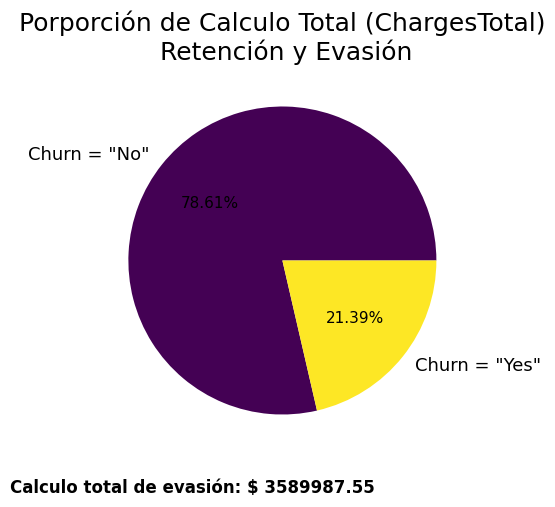

In [490]:
totales = datos.groupby('Churn')['ChargesTotal'].sum().reset_index()
churn_yes = totales[totales['Churn'] == 'Yes']

fig, ax = plt.subplots(figsize=(8,5))

wedges, texts, autotexts = ax.pie(data=totales,
                                  x='ChargesTotal',
                                  autopct='%1.2f%%',
                                  labels=['Churn = "No"', 'Churn = "Yes"'],
                                  colors=churn_colors,
                                  startangle=0
                                  )
for t in texts:
    t.set_fontsize(13)
for a in autotexts:
    a.set_fontsize(11)

plt.title('Porporción de Calculo Total (ChargesTotal)\n Retención y Evasión', fontsize=18)
plt.figtext(0.4, 0.03, f'Calculo total de evasión: $ {churn_yes["ChargesTotal"].values[0]}', ha='center', fontsize=12, fontweight='bold')

fig.savefig(IMG_PATH / 'calculo_evasion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

In [500]:
df_processed[df_processed['Churn'] == 1].describe()['Tenure']

count    1978.000000
mean       20.508595
std        21.721863
min         1.000000
25%         2.000000
50%        11.000000
75%        34.000000
max        72.000000
Name: Tenure, dtype: float64

Observaciones sobre la frecuencia de abandono

Tal como se evidenció en la fase previa del análisis, la tasa de deserción (Churn Rate) resulta significativamente más elevada en las etapas iniciales del ciclo de vida del cliente. En particular, se observa que aproximadamente el 50% de los abandonos ocurre antes de cumplirse el primer año de permanencia contractual, lo que sugiere una mayor vulnerabilidad en la etapa de incorporación y consolidación de la relación con la empresa.

Evasión (Churn) según Gasto Total (ChargesTotal)

In [502]:
# tenure_boxplot = boxplot_churn(df_processed, ycol='ChargesTotal', ylabel='Gasto Total', title_translate='Gasto Total (ChargesTotal)')

Observaciones: Evasión (Churn) en función del Gasto Total (ChargesTotal)

Dado que ChargesTotal constituye una variable acumulativa, presenta una alta dependencia con la antigüedad del cliente (Tenure). Este comportamiento queda evidenciado en el análisis de correlación, donde el coeficiente de Pearson entre ambas variables alcanza un valor de 0.94, lo que indica una relación lineal casi perfecta.

La inclusión simultánea de ChargesTotal junto con Tenure y ChargesMonthly podría inducir redundancia explicativa en el modelo debido a la multicolinealidad estructural. Por este motivo, se adoptará una estrategia experimental: en una primera etapa se considerarán todas las variables, y posteriormente se excluirá ChargesTotal, manteniendo únicamente Tenure y ChargesMonthly, dado que la combinación de estas dos covariables captura de manera completa la información contenida en ChargesTotal.

# 4. Modelado de datos

Train Test Split

Conjunto X

In [503]:
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

In [504]:
X_cv, X_test, y_cv, y_test = tts(X, y, test_size=0.15, stratify=y, random_state=42)  # tts = train_test_split

In [505]:
X_train, X_val, y_train, y_val = tts(X_cv, y_cv, test_size=0.10, stratify=y_cv, random_state=42)

Conjunto X_scale

In [506]:
X_scale = df_scaling.drop('Churn', axis=1)
y_scale = df_scaling['Churn']

In [507]:
X_scale_cv, X_scale_test, y_scale_cv, y_scale_test = tts(X_scale, y_scale, test_size=0.15, stratify=y_scale, random_state=42)

In [508]:
X_scale_train, X_scale_val, y_scale_train, y_scale_val = tts(X_scale_cv, y_scale_cv, test_size=0.10, stratify=y_scale_cv, random_state=42)

Conjunto X_linear

In [509]:
X_linear = df_recta.drop('Churn', axis=1)
y_linear = df_recta['Churn']

In [510]:
X_linear_cv, X_linear_test, y_linear_cv, y_linear_test = tts(X_linear, y_linear, test_size=0.15, stratify=y_linear, random_state=42)

In [511]:
X_linear_train, X_linear_val, y_linear_train, y_linear_val = tts(X_linear_cv, y_linear_cv, test_size=0.10, stratify=y_linear_cv, random_state=42)

Escalado de variables numéricas

In [512]:
var_num = ['Tenure', 'ChargesMonthly', 'ChargesTotal']
var_num_scaled = ['Tenure_scaled', 'ChargesMonthly_scaled', 'ChargesTotal_scaled']

Conjunto X_scale

In [513]:
X_scale_cv

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1571          0.0                0.0          0.0             0.0   
3669          1.0                0.0          0.0             1.0   
6327          0.0                0.0          0.0             1.0   
6329          0.0                0.0          1.0             1.0   
6138          0.0                1.0          1.0             0.0   
...           ...                ...          ...             ...   
5448          0.0                1.0          0.0             0.0   
5489          1.0                0.0          1.0             1.0   
4194          0.0                1.0          1.0             0.0   
4305          1.0                1.0          0.0             0.0   
1061          0.0                0.0          1.0             1.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
1571               1.0                1.0                  0.0   
3669               1.0                0.0                  1.0   
6327               1.0                0.0                  0.0   
6329               1.0                1.0                  0.0   
6138               1.0                1.0                  0.0   
...                ...                ...                  ...   
5448               0.0                0.0                  1.0   
5489               1.0                1.0                  0.0   
4194               1.0                0.0                  0.0   
4305               0.0                0.0                  1.0   
1061               1.0                1.0                  1.0   

      InternetService_Fiber optic  NoInternetService  OnlineSecurity_Yes  ...  \
1571                          1.0                0.0                 0.0  ...   
3669                          0.0                0.0                 0.0  ...   
6327                          0.0                1.0                 0.0  ...   
6329                          1.0                0.0                 0.0  ...   
6138                          1.0                0.0                 0.0  ...   
...                           ...                ...                 ...  ...   
5448                          0.0                0.0                 0.0  ...   
5489                          1.0                0.0                 1.0  ...   
4194                          1.0                0.0                 0.0  ...   
4305                          0.0                0.0                 0.0  ...   
1061                          0.0                0.0                 0.0  ...   

      Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
1571                0.0                0.0                   1.0   
3669                0.0                0.0                   1.0   
6327                1.0                0.0                   0.0   
6329                0.0                0.0                   0.0   
6138                0.0                0.0                   1.0   
...                 ...                ...                   ...   
5448                0.0                1.0                   1.0   
5489                0.0                1.0                   0.0   
4194                0.0                0.0                   1.0   
4305                0.0                0.0                   1.0   
1061                0.0                1.0                   0.0   

      PaymentMethod_Bank transfer (automatic)  \
1571                                      0.0   
3669                                      0.0   
6327                                      0.0   
6329                                      0.0   
6138                                      0.0   
...                                       ...   
5448                                      1.0   
5489                                      1.0   
4194                                      0.0   
4305                                      0.0   
1061                                      1.0   

     

In [514]:
robust_scaler = RobustScaler()

# Fit solo en los datos de entrenamiento (X_cv)
robust_scaler.fit(X_scale_cv[var_num])

# Transformar todos los datasets usando el mismo scaler
X_scaled_cv = X_scale_cv.copy()
y_scaled_cv = y_scale_cv.copy()
X_scaled_train = X_scale_train.copy()
y_scaled_train = y_scale_train.copy()
X_scaled_val = X_scale_val.copy()
y_scaled_val = y_scale_val.copy()
X_scaled_test = X_scale_test.copy()
y_scaled_test = y_scale_test.copy()

X_scaled_cv[var_num_scaled] = robust_scaler.transform(X_scale_cv[var_num])
X_scaled_train[var_num_scaled] = robust_scaler.transform(X_scale_train[var_num])
X_scaled_val[var_num_scaled] = robust_scaler.transform(X_scale_val[var_num])
X_scaled_test[var_num_scaled] = robust_scaler.transform(X_scale_test[var_num])

X_scaled_cv.drop(var_num, axis=1, inplace=True)
X_scaled_train.drop(var_num, axis=1, inplace=True)
X_scaled_val.drop(var_num, axis=1, inplace=True)
X_scaled_test.drop(var_num, axis=1, inplace=True)

In [515]:
X_scaled_cv.head()

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1571          0.0                0.0          0.0             0.0   
3669          1.0                0.0          0.0             1.0   
6327          0.0                0.0          0.0             1.0   
6329          0.0                0.0          1.0             1.0   
6138          0.0                1.0          1.0             0.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
1571               1.0                1.0                  0.0   
3669               1.0                0.0                  1.0   
6327               1.0                0.0                  0.0   
6329               1.0                1.0                  0.0   
6138               1.0                1.0                  0.0   

      InternetService_Fiber optic  NoInternetService  OnlineSecurity_Yes  ...  \
1571                          1.0                0.0                 0.0  ...   
3669                          0.0                0.0                 0.0  ...   
6327                          0.0                1.0                 0.0  ...   
6329                          1.0                0.0                 0.0  ...   
6138                          1.0                0.0                 0.0  ...   

      Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
1571                0.0                0.0                   1.0   
3669                0.0                0.0                   1.0   
6327                1.0                0.0                   0.0   
6329                0.0                0.0                   0.0   
6138                0.0                0.0                   1.0   

      PaymentMethod_Bank transfer (automatic)  \
1571                                      0.0   
3669                                      0.0   
6327                                      0.0   
6329                                      0.0   
6138                                      0.0   

      PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
1571                                    1.0                             0.0   
3669                                    0.0                             0.0   
6327                                    0.0                             0.0   
6329                                    1.0                             0.0   
6138                                    0.0                             1.0   

      PaymentMethod_Mailed check  Tenure_scaled  ChargesMonthly_scaled  \
1571                         0.0       0.319149               0.339138   
3669                         1.0      -0.617021              -0.383135   
6327                         1.0      -0.319149              -0.937672   
6329                         0.0       0.063830               0.326306   
6138                         0.0      -0.617021               0.549954   

      ChargesTotal_scaled  
1571             0.783087  
3669            -0.387834  
6327            -0.325447  
6329             0.414631  
6138            -0.373445  

[5 rows x 26 columns]

Conjunto X_linear

In [516]:
robust_scaler_linear = RobustScaler()

X_linear_cv[var_num_scaled] = robust_scaler_linear.fit_transform(X_linear_cv[var_num])
X_linear_train[var_num_scaled] = robust_scaler_linear.transform(X_linear_train[var_num])
X_linear_val[var_num_scaled] = robust_scaler_linear.transform(X_linear_val[var_num])
X_linear_test[var_num_scaled] = robust_scaler_linear.transform(X_linear_test[var_num])

X_linear_cv.drop(var_num, axis=1, inplace=True)
X_linear_train.drop(var_num, axis=1, inplace=True)
X_linear_val.drop(var_num, axis=1, inplace=True)
X_linear_test.drop(var_num, axis=1, inplace=True)

In [517]:
X_linear_cv.head()

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
1571          0.0                0.0          0.0             0.0   
3669          1.0                0.0          0.0             1.0   
6327          0.0                0.0          0.0             1.0   
6329          0.0                0.0          1.0             1.0   
6138          0.0                1.0          1.0             0.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_Fiber optic  \
1571               1.0                1.0                          1.0   
3669               1.0                0.0                          0.0   
6327               1.0                0.0                          0.0   
6329               1.0                1.0                          1.0   
6138               1.0                1.0                          1.0   

      NoInternetService  OnlineSecurity_Yes  OnlineBackup_Yes  ...  \
1571                0.0                 0.0               0.0  ...   
3669                0.0                 0.0               0.0  ...   
6327                1.0                 0.0               0.0  ...   
6329                0.0                 0.0               1.0  ...   
6138                0.0                 0.0               0.0  ...   

      StreamingMovies_Yes  Contract_One year  Contract_Two year  \
1571                  1.0                0.0                0.0   
3669                  0.0                0.0                0.0   
6327                  0.0                1.0                0.0   
6329                  0.0                0.0                0.0   
6138                  1.0                0.0                0.0   

      PaperlessBilling_Yes  PaymentMethod_Credit card (automatic)  \
1571                   1.0                                    1.0   
3669                   1.0                                    0.0   
6327                   0.0                                    0.0   
6329                   0.0                                    1.0   
6138                   1.0                                    0.0   

      PaymentMethod_Electronic check  PaymentMethod_Mailed check  \
1571                             0.0                         0.0   
3669                             0.0                         1.0   
6327                             0.0                         1.0   
6329                             0.0                         0.0   
6138                             1.0                         0.0   

      Tenure_scaled  ChargesMonthly_scaled  ChargesTotal_scaled  
1571       0.319149               0.339138             0.783087  
3669      -0.617021              -0.383135            -0.387834  
6327      -0.319149              -0.937672            -0.325447  
6329       0.063830               0.326306             0.414631  
6138      -0.617021               0.549954            -0.373445  

[5 rows x 23 columns]

Balance del dataset

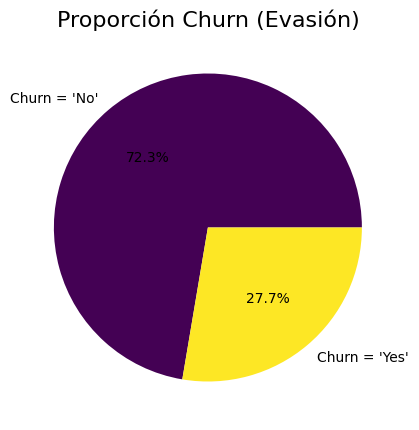

In [518]:
# Visualizar la proporción de registros en relación a la evasión (Churn)

churns = df_processed.groupby('Churn')['Churn'].value_counts()
churns = pd.DataFrame(churns)
fig, ax = plt.subplots(figsize=(6,5))
ax = plt.pie(data=churns,
             x=churns['count'],
             labels=["Churn = 'No'", "Churn = 'Yes'"],
             autopct='%1.1f%%',
             colors=churn_colors)

plt.title('Proporción Churn (Evasión)', fontsize=16)

fig.savefig(IMG_PATH/'pie_Churn_proportion.png',
            transparent=False,
            dpi=300,
            bbox_inches='tight')
plt.show()

Observaciones: Distribución de clases y estrategias de balanceo

Del análisis gráfico se desprende que la distribución de clases se encuentra desbalanceada, ya que cerca del 75 % de las observaciones corresponden a clientes que no presentan deserción (No Churn). Esta desproporción puede inducir un sesgo en el entrenamiento del modelo, reduciendo su capacidad para identificar de manera adecuada los patrones asociados al abandono de clientes (Churn). En consecuencia, resulta imprescindible implementar una estrategia de balanceo en el conjunto de entrenamiento.

Es crucial subrayar que el balanceo se aplica únicamente sobre los datos de entrenamiento, con el fin de evitar el fenómeno de data leakage. Alterar artificialmente la distribución de las clases en los conjuntos de validación o prueba distorsionaría la representatividad estadística de los datos y conduciría a métricas de desempeño poco confiables o infladas.

En este estudio se adoptará una estrategia conservadora mediante undersampling de la clase mayoritaria, utilizando la técnica NearMiss. Dicha metodología selecciona instancias relevantes de la clase predominante, privilegiando los casos de mayor dificultad de clasificación, lo que puede incrementar la capacidad discriminante del modelo frente al Churn.

Si bien técnicas de sobremuestreo como SMOTE permiten la generación de observaciones sintéticas de la clase minoritaria a través de interpolaciones, estas no corresponden a registros reales. Aun cuando cuentan con un sustento matemático, pueden introducir patrones espurios que no reflejen el comportamiento histórico del negocio. Por esta razón, se opta por reservar SMOTE para contextos controlados —por ejemplo, en la construcción de bases balanceadas destinadas a pruebas de desempeño en entornos productivos— donde el interés radica en evaluar la robustez del modelo frente a una distribución perfectamente equilibrada.

In [519]:
columnas = df_processed.columns
columnas, len(columnas)

(Index(['Gender_Male', 'SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
        'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_DSL',
        'InternetService_Fiber optic', 'NoInternetService',
        'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
        'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
        'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year',
        'PaperlessBilling_Yes', 'PaymentMethod_Bank transfer (automatic)',
        'PaymentMethod_Credit card (automatic)',
        'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
        'Tenure', 'ChargesMonthly', 'ChargesTotal', 'Churn'],
       dtype='object'),
 27)

In [520]:
undersampler = NearMiss(version=3)

Conjunto X

In [521]:
X_cv, y_cv = undersampler.fit_resample(X_cv,y_cv)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [522]:
y_cv.value_counts()

Churn
0    1681
1    1681
Name: count, dtype: int64

In [523]:
y_train.value_counts()

Churn
0    1513
1    1513
Name: count, dtype: int64

Conjunto X_scaled

In [524]:
X_scaled_cv, y_scaled_cv = undersampler.fit_resample(X_scaled_cv,y_scaled_cv)
X_scaled_train, y_scaled_train = undersampler.fit_resample(X_scaled_train, y_scaled_train)

In [525]:
y_scaled_cv.value_counts()

Churn
0    1681
1    1681
Name: count, dtype: int64

In [526]:
y_scaled_train.value_counts()

Churn
0    1513
1    1513
Name: count, dtype: int64

Conjunto X_linear

In [527]:
X_linear_cv, y_linear_cv = undersampler.fit_resample(X_linear_cv,y_linear_cv)
X_linear_train, y_linear_train = undersampler.fit_resample(X_linear_train, y_linear_train)

In [528]:
y_linear_cv.value_counts()

Churn
0    1681
1    1681
Name: count, dtype: int64

In [529]:
y_linear_train.value_counts()

Churn
0    1513
1    1513
Name: count, dtype: int64

In [573]:
X_cv

Gender_Male  SeniorCitizen_Yes  Partner_Yes  Dependents_Yes  \
0             1.0                0.0          1.0             0.0   
1             1.0                0.0          1.0             0.0   
2             0.0                0.0          1.0             1.0   
3             1.0                0.0          1.0             1.0   
4             0.0                0.0          1.0             0.0   
...           ...                ...          ...             ...   
3357          1.0                0.0          1.0             0.0   
3358          1.0                1.0          0.0             0.0   
3359          1.0                0.0          0.0             0.0   
3360          1.0                1.0          1.0             1.0   
3361          0.0                0.0          1.0             0.0   

      PhoneService_Yes  MultipleLines_Yes  InternetService_DSL  \
0                  1.0                1.0                  0.0   
1                  1.0                1.0                  0.0   
2                  1.0                1.0                  0.0   
3                  1.0                1.0                  0.0   
4                  1.0                1.0                  0.0   
...                ...                ...                  ...   
3357               1.0                1.0                  0.0   
3358               1.0                0.0                  0.0   
3359               1.0                0.0                  0.0   
3360               1.0                1.0                  0.0   
3361               1.0                1.0                  0.0   

      InternetService_Fiber optic  NoInternetService  OnlineSecurity_Yes  ...  \
0                             1.0                0.0                 1.0  ...   
1                             1.0                0.0                 1.0  ...   
2                             1.0                0.0                 1.0  ...   
3                             1.0                0.0                 1.0  ...   
4                             1.0                0.0                 1.0  ...   
...                           ...                ...                 ...  ...   
3357                          1.0                0.0                 0.0  ...   
3358                          1.0                0.0                 0.0  ...   
3359                          1.0                0.0                 0.0  ...   
3360                          1.0                0.0                 1.0  ...   
3361                          1.0                0.0                 0.0  ...   

      Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                   0.0                1.0                   1.0   
1                   0.0                1.0                   1.0   
2                   0.0                1.0                   0.0   
3                   0.0                1.0                   1.0   
4                   0.0                1.0                   0.0   
...                 ...                ...                   ...   
3357                0.0                0.0                   1.0   
3358                0.0                0.0                   1.0   
3359                0.0                0.0                   1.0   
3360                1.0                0.0                   1.0   
3361                0.0                0.0                   1.0   

      PaymentMethod_Bank transfer (automatic)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         1.0   
4                                         0.0   
...                                       ...   
3357                                      1.0   
3358                                      0.0   
3359                                      0.0   
3360                                      1.0   
3361                                      0.0   

     

Baseline model - Decision Tree Classifier

In [530]:
X_cv.shape

(3362, 26)

In [531]:
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [532]:
baseline_model = DecisionTreeClassifier(max_depth=10, random_state=42)
baseline_cross_val_results = cross_validate(baseline_model, X_cv, y_cv, cv=skf, scoring='recall')

In [533]:
cv_score_interval(results=baseline_cross_val_results,
                  nombre='Baseline Model',
                  score='Recall')

Recall promedio de Baseline Model: 0.677
Desviación estándar del Recall de Baseline Model: 0.0472
El Recall de Baseline Model estará entre [0.5826,0.7714] con un 95% de confianza


In [534]:
baseline_model.fit(X_cv, y_cv)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [535]:
baseline_pred = baseline_model.predict(X_test)

In [536]:
print(classification_report(y_test, baseline_pred))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       776
           1       0.49      0.64      0.55       297

    accuracy                           0.72      1073
   macro avg       0.67      0.69      0.67      1073
weighted avg       0.75      0.72      0.73      1073



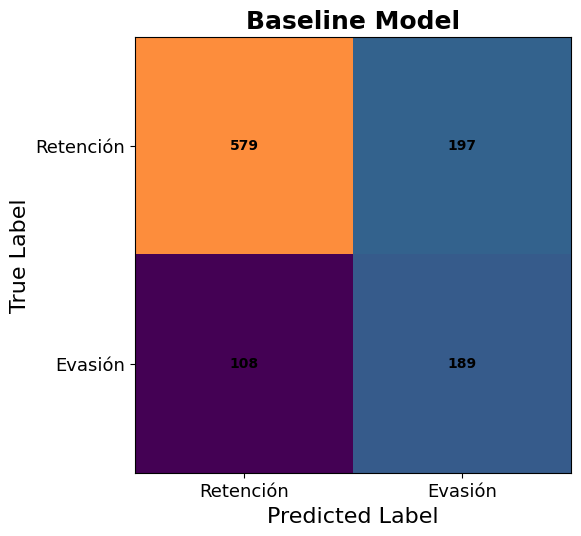

In [537]:
plot_conf_mat(baseline_model, X_test, y_test, 'Baseline Model', 'baseline')

Evaluación del modelo: métricas por clase

Clase 0 (clientes que no abandonan):

Precisión = 0.84 → cuando el modelo predice retención, acierta en un 84 % de los casos.

Recall = 0.75 → identifica correctamente al 75 % de los clientes que efectivamente permanecen.

F1-score = 0.79 → refleja un buen equilibrio entre precisión y sensibilidad.

Support = 776 → corresponde al número de clientes que realmente no desertaron, constituyendo la clase mayoritaria.

Clase 1 (clientes que abandonan):

Precisión = 0.49 → cuando el modelo predice abandono, solo acierta en un 49 % de los casos, lo que evidencia un número considerable de falsos positivos.

Recall = 0.64 → logra detectar un 64 % de los abandonos reales, un desempeño aceptable para un modelo base.

F1-score = 0.55 → muestra un balance moderado entre la baja precisión y el nivel relativamente adecuado de recall.

Support = 297 → corresponde a los clientes que efectivamente abandonaron, conformando la clase minoritaria.

Exactitud global (Accuracy) = 0.72 → el modelo acierta en el 72 % de las predicciones. Sin embargo, dada la desproporción en la distribución de clases, esta métrica puede estar sesgada por la clase mayoritaria (No Churn). Por esta razón, resulta esencial priorizar métricas complementarias como precision, recall y F1-score, que permiten una evaluación más confiable del rendimiento del modelo en escenarios de desbalance.

In [538]:
baseline_results = metricas_evaluacion(modelo=baseline_model,
                                       x_test= X_test,
                                       y_test=y_test,
                                       nombre='Baseline Model',
                                       conjunto='X')

Baseline Model    
                                                                       
Accuracy = 0.7158
Precision = 0.4896
Recall = 0.6364
F1-score = 0.5534
AUC = 0.7418


ROC Curve

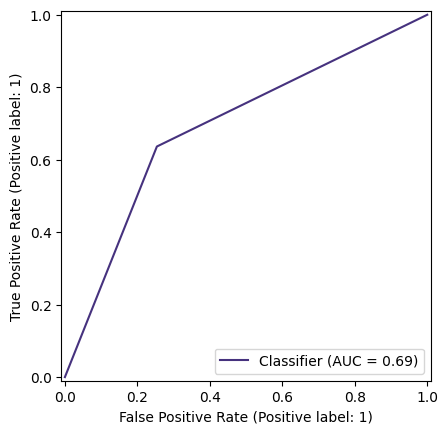

In [539]:
RocCurveDisplay.from_predictions(y_test, baseline_pred);

Observaciones: Curva ROC y AUC
El AUC-ROC se obtiene variando el umbral de decisión sobre la probabilidad asignada a la clase positiva.

Cuando se utiliza predict_proba(X_test)[:, 1], el cálculo del AUC considera el desempeño del clasificador en todo el rango de umbrales posibles (0 a 1), lo que permite estimar de manera más precisa la capacidad discriminante global del modelo.

En contraste, al emplear predict(X_test), la evaluación se realiza únicamente en un punto específico correspondiente al umbral fijo de 0.5. Esta aproximación restringida reduce la resolución del análisis y puede subestimar el verdadero poder discriminatorio del modelo.

En el caso analizado, el gráfico evidencia un AUC = 0.69 bajo la predicción binaria directa, mientras que al trabajar con probabilidades se obtiene un AUC = 0.7418. Esta diferencia cercana al 5 % sugiere que el modelo podría mejorar su rendimiento si se ajusta el umbral de decisión, en lugar de adoptar el valor por defecto de 0.5.

Baseline Model: Umbral de decisión

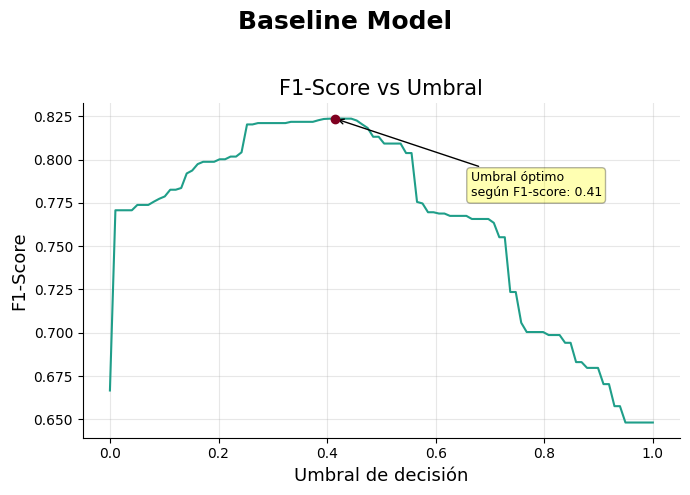

In [540]:
umbral_baseline = plot_umbrales(modelo=baseline_model,
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='Baseline Model')

Observaciones: Modelo Base – Ajuste del Umbral de Decisión
El análisis del F1-score —métrica armónica que pondera simultáneamente precisión y recall— permitió determinar que el umbral de decisión óptimo se sitúa en 0.4.

En términos prácticos, esto implica que todas las observaciones cuya probabilidad estimada de abandono sea mayor o igual a 0.4 serán clasificadas como casos positivos (Churn = 1).

La calibración del umbral mejora la capacidad discriminante del modelo, al lograr una separación más adecuada entre las clases, y resulta determinante para seleccionar la versión con mejor desempeño en la identificación de clientes propensos a desertar.

La elección del F1-score como métrica principal se justifica porque las métricas individuales de precisión y recall tienden a mostrar valores extremos cuando se analizan en función del umbral (cercanos a 0 o 1), lo que limita su utilidad en la toma de decisiones. En cambio, el F1-score ofrece un equilibrio estadísticamente más robusto entre ambas dimensiones, permitiendo identificar un umbral intermedio verdaderamente informativo y alineado con los objetivos de clasificación del modelo.

Baseline Model: Precision vs Recall Curve

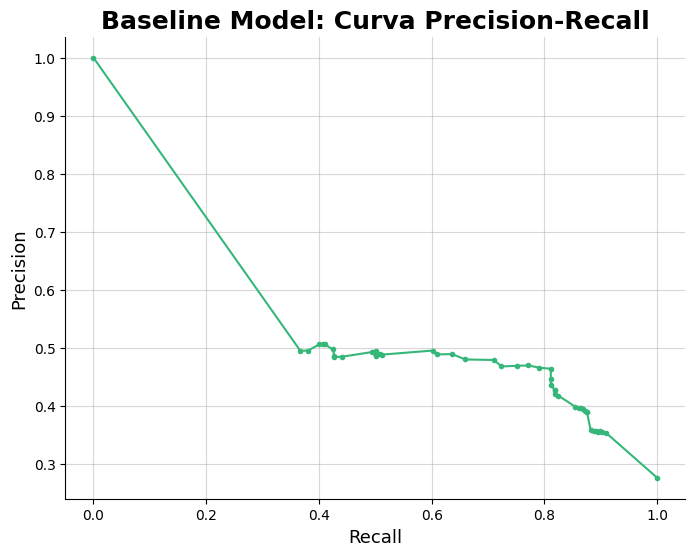

In [541]:
plot_precision_recall_curve(modelo=baseline_model,
                            x=X_test,
                            y=y_test,
                            nombre='Baseline Model')

Observaciones: Modelo Base – Curva Precisión vs. Recall
El gráfico de la curva Precisión–Recall evidencia el compromiso inherente (trade-off) entre ambas métricas en función de los distintos umbrales de decisión aplicados.

Por ejemplo, al fijar un Recall cercano a 0.80, se observa una reducción en la Precisión hasta aproximadamente 0.47, lo que refleja el costo de incrementar la sensibilidad del modelo en términos de un mayor número de falsos positivos.

Dado que el objetivo analítico es maximizar la Sensibilidad (Recall) para capturar la mayor proporción posible de clientes que efectivamente abandonan, sin deteriorar de manera crítica la Precisión, será necesario identificar un modelo cuya combinación de hiperparámetros y umbral de decisión optimice este equilibrio. En particular, la meta es lograr una clasificación robusta que favorezca la detección temprana de abandonos reales, al tiempo que se controla la tasa de clasificaciones erróneas en la clase positiva (Churn).

In [542]:
baseline_results_umbral = metricas_evaluacion(modelo=baseline_model,
                                               x_test= X_test,
                                               y_test=y_test,
                                               nombre='Baseline Model',
                                               conjunto='X',
                                               umbral=0.41)

pd.DataFrame([baseline_results_umbral])

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   

   Umbral  
0    0.41

In [543]:
# Lista para almacenar los resultados de los mejores modelos y establecer comparación
best_models = []

In [544]:
best_models.append(baseline_results_umbral)
pd.DataFrame(best_models)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   

   Umbral  
0    0.41

Random Forest Classifier

RandomForest 1 - MaxDepth = 10 - Conjunto X

In [545]:
# Lista para registrar los resultados de los modelos dentro de la familia Random Forest
rf_results_tracking = []

In [546]:
rf_1 = RandomForestClassifier(max_depth=10, random_state=42)

rf_1_cv_results = cross_validate(rf_1, X_cv, y_cv, cv=skf, scoring='recall')

In [547]:
cv_score_interval(results=rf_1_cv_results,
                  nombre='RandomForest 1',
                  score='Recall')

Recall promedio de RandomForest 1: 0.7115
Desviación estándar del Recall de RandomForest 1: 0.0148
El Recall de RandomForest 1 estará entre [0.6819,0.7411] con un 95% de confianza


In [548]:
rf_1.fit(X_cv, y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [549]:
rf_1_results = metricas_evaluacion(modelo=rf_1,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 1',
                                   conjunto='X')

rf_results_tracking.append(rf_1_results)
pd.DataFrame(rf_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  RandomForest 1       X    0.7745     0.5729  0.7273    0.6409  0.8295   

   Umbral  
0     0.5

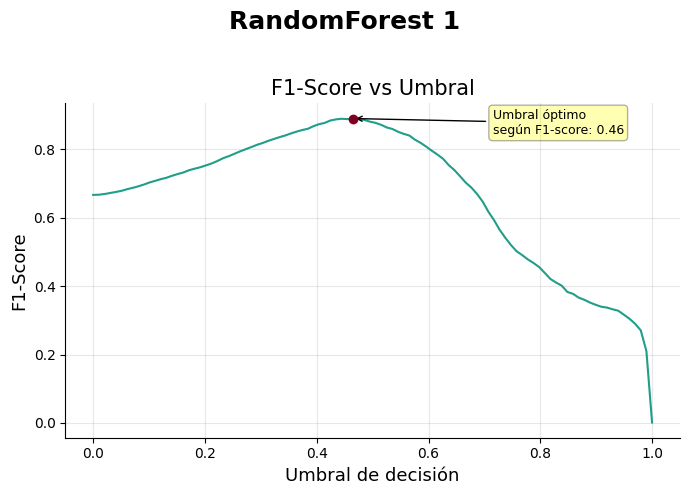

In [550]:
umbral_rf_1 = plot_umbrales(modelo=rf_1,
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 1')

In [551]:
rf_1_results_umbral = metricas_evaluacion(modelo=rf_1,
                                           x_test=X_test,
                                           y_test=y_test,
                                           nombre='RandomForest 1',
                                           conjunto='X',
                                           umbral=0.46,)

rf_results_tracking.append(rf_1_results_umbral)

In [552]:
pd.DataFrame(rf_results_tracking)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  RandomForest 1       X    0.7745     0.5729  0.7273    0.6409  0.8295   
1  RandomForest 1       X    0.7596     0.5465  0.7710    0.6397  0.8295   

   Umbral  
0    0.50  
1    0.46

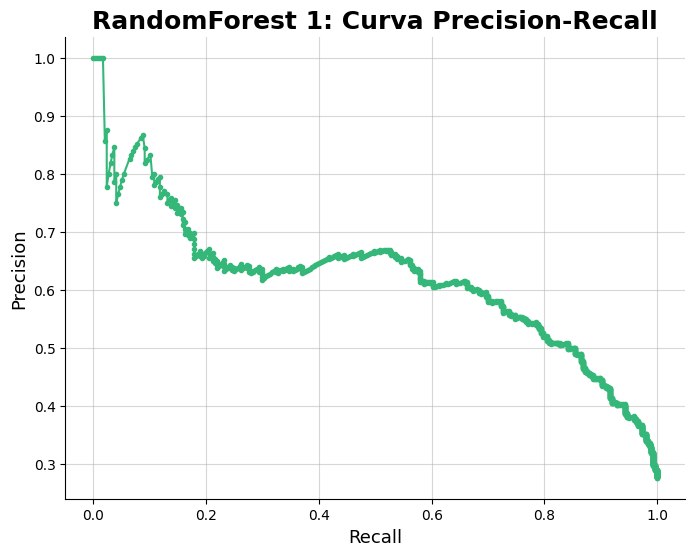

In [553]:
plot_precision_recall_curve(modelo=rf_1,
                            x=X_test,
                            y=y_test,
                            nombre='RandomForest 1')


Observaciones: RandomForest 1 - MaxDepth = 10 - Conjunto X

Este modelo consigue superar significativamente a BaselineModel:

| Modelo         | Conjunto | Accuracy | Precision | Recall | F1-Score |   AUC   | Umbral |
|----------------|----------|----------|-----------|--------|----------|---------|--------|
| Baseline Model |    X     |  0.7158  |  0.4896   | 0.6364 |  0.5534  | 0.7418  |  0.50  |
| RandomForest 1 |    X     |  0.7745  |  0.5729   | 0.7273 |  0.6409  | 0.8295  |  0.50  |


Inicialmente el modelo RandomForest 1, con el umbral por defecto en 0.5, consigue los siguientes aumentos en las métricas:

Accuracy: 0.7158 → 0.7745 = +0.0587 (+5.87%)
Precision: 0.4896 → 0.5729 = +0.0833 (+8.33%)
Recall: 0.6364 → 0.7273 = +0.0909 (+9.09%)
F1-Score: 0.5534 → 0.6409 = +0.0875 (+8.75%)

Luego, al ajustar el umbral según el valor óptimo determinado por la métrica F1-score (0.46), se incrementa significativamente el Recall, con una baja leve en Precision:

| Modelo         | Conjunto | Accuracy | Precision | Recall | F1-Score |   AUC   | Umbral |
|----------------|----------|----------|-----------|--------|----------|---------|--------|
| RandomForest 1 |    X     |  0.7596  |  0.5465   | 0.7710 |  0.6397  | 0.8295  |  0.46  |

Con esta configuración se logra:

Un aumento adicional del Recall de +4.37%
Una disminución de 2.64% en Precision

RandomForest 2 - MaxDepth = 10 - Conjunto X_scaled
Si bien el algoritmo Random Forest es robusto frente a la escala de variables, se ejecutará Cross Validate sobre el conjunto X_scaled, para ver si el modelo consigue aprender mejor el patrón presente en los datos al tener las variables numéricas transformadas con RobustScaler

In [554]:
rf_2 = RandomForestClassifier(max_depth=10, random_state=42)

rf_2_cv_results = cross_validate(rf_2, X_scaled_cv, y_scaled_cv, cv=skf, scoring='recall')

In [555]:
cv_score_interval(results=rf_2_cv_results,
                  nombre='RandomForest 2',
                  score='Recall')

Recall promedio de RandomForest 2: 0.6157
Desviación estándar del Recall de RandomForest 2: 0.0158
El Recall de RandomForest 2 estará entre [0.5841,0.6473] con un 95% de confianza


In [556]:
rf_2.fit(X_scaled_cv, y_scaled_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [557]:
rf_2_results = metricas_evaluacion(modelo=rf_2,
                                   x_test=X_scaled_test,
                                   y_test=y_scaled_test,
                                   nombre='RandomForest 2',
                                   conjunto='X_scaled')

rf_results_tracking.append(rf_2_results)
pd.DataFrame(rf_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  RandomForest 1         X    0.7745     0.5729  0.7273    0.6409  0.8295   
1  RandomForest 1         X    0.7596     0.5465  0.7710    0.6397  0.8295   
2  RandomForest 2  X_scaled    0.7801     0.5981  0.6263    0.6118  0.8258   

   Umbral  
0    0.50  
1    0.46  
2    0.50


Observaciones: RandomForest 2 - MaxDepth = 10 - Conjunto X_scaled

Se realizará una prueba experimental entrenando un Random Forest utilizando las variables seleccionadas con mayor correlatividad en cuanto a la variable Churn.

In [558]:
rf_3 = RandomForestClassifier(max_depth=10, random_state=42)

In [560]:
rf_3_columns = corr_selected.columns
rf_3_columns = rf_3_columns[:-1]
rf_3_columns

Index(['SeniorCitizen_Yes', 'Partner_Yes', 'Dependents_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'NoInternetService', 'OnlineSecurity_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_Month-to-month',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure', 'ChargesMonthly', 'ChargesTotal'],
      dtype='object')

In [559]:
rf_3_cv_results = cross_validate(rf_3, X_cv[rf_3_columns], y_cv, cv=skf, scoring='recall')

cv_score_interval(results=rf_3_cv_results,
                  nombre='RandomForest 3',
                  score='Recall')

Recall promedio de RandomForest 3: 0.7026
Desviación estándar del Recall de RandomForest 3: 0.0187
El Recall de RandomForest 3 estará entre [0.6652,0.7400] con un 95% de confianza


In [561]:
rf_3.fit(X_cv[rf_3_columns], y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

In [562]:
rf_3_results = metricas_evaluacion(modelo=rf_3,
                                   x_test=X_test[rf_3_columns],
                                   y_test=y_test,
                                   nombre='RandomForest 3',
                                   conjunto='X[corr_features]')

rf_results_tracking.append(rf_3_results)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7801     0.5981  0.6263    0.6118   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8258    0.50  
3  0.8239    0.50

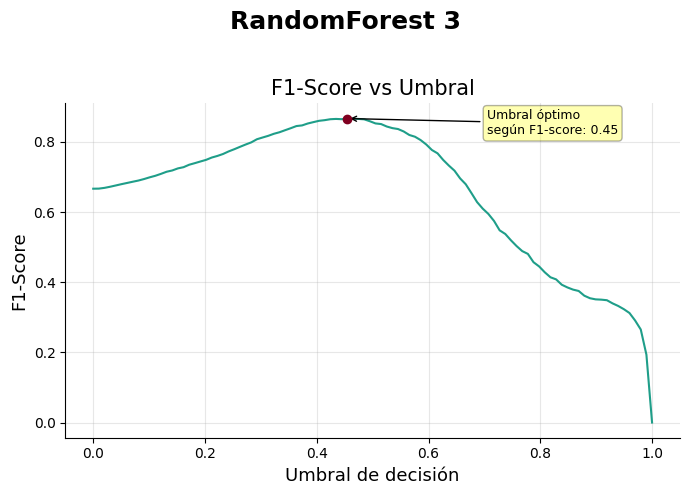

In [564]:
umbral_rf_3 = plot_umbrales(modelo=rf_3,
                                score='F1-Score',
                                x=X_cv[rf_3_columns],
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 3')

In [565]:

rf_3_results_umbral = metricas_evaluacion(modelo=rf_3,
                                           x_test=X_test[rf_3_columns],
                                           y_test=y_test,
                                           nombre='RandomForest 3',
                                           conjunto='X[corr_features]',
                                           umbral=0.45)

rf_results_tracking.append(rf_3_results_umbral)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7801     0.5981  0.6263    0.6118   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8258    0.50  
3  0.8239    0.50  
4  0.8239    0.45

Observaciones: RandomForest 3 – MaxDepth = 10 – Conjunto X – Variables seleccionadas por correlación
El modelo entrenado con un subconjunto de predictores seleccionados de manera ad hoc, bajo el criterio de presentar un coeficiente de correlación absoluto superior a 0.7 con la variable objetivo, logra superar marginalmente a RandomForest 1 en la métrica prioritaria.

No obstante, la ganancia en Recall resulta mínima (+0.68%), mientras que la reducción en Precisión alcanza un −2.03%, lo que indica que la ligera mejora obtenida no compensa el deterioro en la capacidad del modelo para evitar falsos positivos.

Pese a ello, el ejercicio sugiere que una reducción de dimensionalidad, incluso si es realizada de manera preliminar y no optimizada, puede contribuir a mejorar la eficiencia del modelo. En consecuencia, se plantea llevar a cabo un experimento adicional orientado a determinar el número óptimo de variables predictoras en función de las importancias de atributos estimadas en RandomForest 1, con el propósito de balancear complejidad y desempeño de manera más rigurosa.

Feature Selection

In [563]:
features = X_cv.columns
rf_1_importances = rf_1.feature_importances_
rf_1_importances = pd.DataFrame({'Feature': features, 'Importancia': rf_1_importances})
rf_1_importances = rf_1_importances.sort_values('Importancia', ascending=False)
rf_1_importances

Feature  Importancia
23                                   Tenure     0.210398
25                             ChargesTotal     0.186427
24                           ChargesMonthly     0.127551
15                  Contract_Month-to-month     0.064609
12                          TechSupport_Yes     0.039548
21           PaymentMethod_Electronic check     0.037476
9                        OnlineSecurity_Yes     0.025942
17                        Contract_Two year     0.025216
18                     PaperlessBilling_Yes     0.024454
7               InternetService_Fiber optic     0.022676
0                               Gender_Male     0.020555
16                        Contract_One year     0.018603
14                      StreamingMovies_Yes     0.018309
5                         MultipleLines_Yes     0.018255
10                         OnlineBackup_Yes     0.017365
3                            Dependents_Yes     0.017232
2                               Partner_Yes     0.017093
11                     DeviceProtection_Yes     0.016673
13                          StreamingTV_Yes     0.016527
1                         SeniorCitizen_Yes     0.015249
6                       InternetService_DSL     0.014599
22               PaymentMethod_Mailed check     0.012451
20    PaymentMethod_Credit card (automatic)     0.010784
19  PaymentMethod_Bank transfer (automatic)     0.010067
4                          PhoneService_Yes     0.007514
8                         NoInternetService     0.004426

In [566]:
feature_selection = []

ct_features = [i if i != 0 else 1 for i in range(0, len(rf_1_importances), 5)]

for i in ct_features:
    model_features = RandomForestClassifier(max_depth=10, random_state=42)
    selected_features = rf_1_importances['Feature'].values[:i]
    X_train_sel = X_cv[selected_features]
    X_test_sel = X_test[selected_features]
    model_features.fit(X_train_sel, y_cv)
    metricas = metricas_evaluacion(model_features, X_test_sel, y_test, f'Features: {i}', 'X')
    feature_selection.append(metricas)

pd.DataFrame(feature_selection)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0   Features: 1       X    0.6664     0.4079  0.4545    0.4299  0.6595     0.5
1   Features: 5       X    0.7353     0.5175  0.6465    0.5749  0.7950     0.5
2  Features: 10       X    0.7707     0.5673  0.7239    0.6361  0.8245     0.5
3  Features: 15       X    0.7791     0.5794  0.7374    0.6489  0.8228     0.5
4  Features: 20       X    0.7679     0.5628  0.7239    0.6333  0.8300     0.5
5  Features: 25       X    0.7614     0.5535  0.7138    0.6235  0.8318     0.5

Observaciones: Feature Selection

El modelo que consigue mejor Recall es aquel entrenado con las 15 variables más importantes según RandomForest 1:

Tenure
ChargesTotal
ChargesMonthly
Contract_Month-to-month
TechSupport_Yes
PaymentMethod_Electronic check
OnlineSecurity_Yes
Contract_Two year
PaperlessBilling_Yes
InternetService_Fiber optic
Gender_Male
Contract_One year
StreamingMovies_Yes
MultipleLines_Yes
OnlineBackup_Yes
Por lo que, se entrenará un modelo que permita controlar el umbral de decisión con la intención de superar las mejores métricas obtenidas hasta el momento.

RandomForest 4 - Max depth = 10 - Feature Selection

In [567]:
selected_cols = rf_1_importances['Feature'][:15].values
selected_cols

array(['Tenure', 'ChargesTotal', 'ChargesMonthly',
       'Contract_Month-to-month', 'TechSupport_Yes',
       'PaymentMethod_Electronic check', 'OnlineSecurity_Yes',
       'Contract_Two year', 'PaperlessBilling_Yes',
       'InternetService_Fiber optic', 'Gender_Male', 'Contract_One year',
       'StreamingMovies_Yes', 'MultipleLines_Yes', 'OnlineBackup_Yes'],
      dtype=object)

In [568]:
rf_4 = RandomForestClassifier(max_depth=10, random_state=42)

rf_4_cv_results = cross_validate(rf_4, X_cv[selected_cols], y_cv, cv=skf, scoring='recall')

cv_score_interval(results=rf_4_cv_results,
                  nombre='RandomForest 4',
                  score='Recall')

Recall promedio de RandomForest 4: 0.6966
Desviación estándar del Recall de RandomForest 4: 0.0141
El Recall de RandomForest 4 estará entre [0.6684,0.7248] con un 95% de confianza


In [569]:
rf_4.fit(X_cv[selected_cols], y_cv)

RandomForestClassifier(max_depth=10, random_state=42)

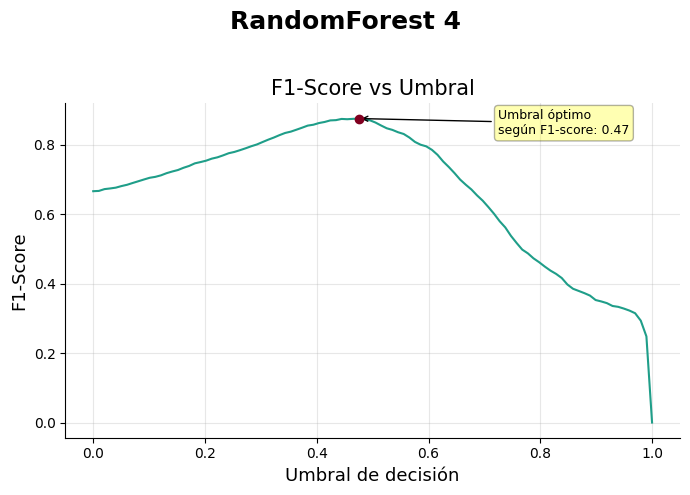

In [570]:
umbral_rf_4 = plot_umbrales(modelo=rf_4,
                                score='F1-Score',
                                x=X_cv[selected_cols],
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 4')

In [571]:
rf_4_results = metricas_evaluacion(modelo=rf_4,
                                   x_test=X_test[selected_cols],
                                   y_test=y_test,
                                   nombre='RandomForest 4',
                                   conjunto='X[selected_cols]',
                                   umbral=0.47)

rf_results_tracking.append(rf_4_results)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7801     0.5981  0.6263    0.6118   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8258    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47

Observaciones: RandomForest 4 - Max depth = 10 - Feature Selection
El modelo entrenado con las variables que se determinaron óptimas para el mismo, no consigue superar al primer modelo entrenado, incluso modificando el umbral de decisión determinado por F1-score.

Esto puede ser un indicador que los modelos basados en árboles se benefician de una mayor cantidad de información para tomar decisiones a la hora de separar las clases.

RandomForest 5 - GridSearchCV

Se ejecutará un GridSearchCV para determinar los hiperparámetros que mejor se ajusten al conjunto de datos disponible

In [572]:
warnings.filterwarnings('error')

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 150, 200, 250]
}

rf_5 = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid, scoring='recall',
                    cv=skf)

rf_5.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='recall')

In [574]:
rf_5.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 250}

In [575]:
rf_5_results = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X')

rf_results_tracking.append(rf_5_results)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7801     0.5981  0.6263    0.6118   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   
6  RandomForest 5                 X    0.7698     0.5654  0.7273    0.6362   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8258    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47  
6  0.8326    0.50

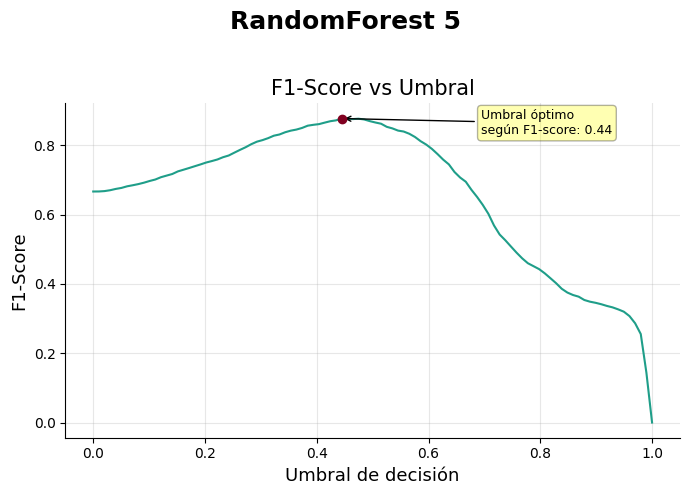

In [576]:
umbral_rf_5 = plot_umbrales(modelo=rf_5.best_estimator_,
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 5')

In [577]:
rf_5_results_umbral = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X',
                                   umbral=0.44)

rf_results_tracking.append(rf_5_results_umbral)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7801     0.5981  0.6263    0.6118   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   
6  RandomForest 5                 X    0.7698     0.5654  0.7273    0.6362   
7  RandomForest 5                 X    0.7409     0.5208  0.8013    0.6313   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8258    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47  
6  0.8326    0.50  
7  0.8326    0.44

Observaciones: RandomForest 5 - GridSearchCV

Estos son Los hiperparámetros determinados por GridSearchCV para el modelo RandomForest que mejor se ajustan al conjunto de datos:

max_depth=10
min_samples_split=3
min_samples_leaf=1
n_estimators=250

Con estas configuraciones, y ajustando el umbral de decisión a 0.44, el modelo RandomForest 5 consigue superar a RandomForest 1.



RandomForest 6 - GridSearchCV - Más estimadores

Por último, debido a que el hiperparámetro n_estimators utilizado fue el máximo provisto en el param_grid. Se hará un ultimo experimento para explorar si el modelo podría beneficiarse de utilizar mayor cantidad de estimadores.

In [578]:
warnings.filterwarnings('error')

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [200, 250, 300, 500]
}

rf_6 = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid=param_grid, scoring='recall',
                    cv=skf)

rf_6.fit(X_cv, y_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [200, 250, 300, 500]},
             scoring='recall')

In [579]:
rf_6.best_params_

{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [580]:
rf_6_results = metricas_evaluacion(modelo=rf_6.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 6',
                                   conjunto='X')

rf_results_tracking.append(rf_6_results)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7801     0.5981  0.6263    0.6118   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   
6  RandomForest 5                 X    0.7698     0.5654  0.7273    0.6362   
7  RandomForest 5                 X    0.7409     0.5208  0.8013    0.6313   
8  RandomForest 6                 X    0.7689     0.5646  0.7205    0.6331   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8258    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47  
6  0.8326    0.50  
7  0.8326    0.44  
8  0.8319    0.50

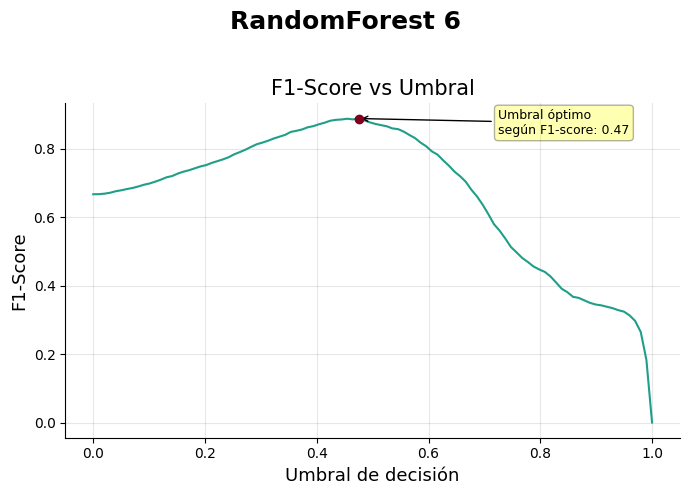

In [581]:
umbral_rf_6 = plot_umbrales(modelo=rf_6.best_estimator_,
                                score='F1-Score',
                                x=X_cv,
                                y=y_cv,
                                caja_x=0.25,
                                caja_y=0.045,
                                nombre='RandomForest 6')

In [582]:
rf_6_results_umbral = metricas_evaluacion(modelo=rf_6.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 6',
                                   conjunto='X',
                                   umbral=0.47)

rf_results_tracking.append(rf_6_results_umbral)
pd.DataFrame(rf_results_tracking)

Model           Dataset  Accuracy  Precision  Recall  F1-score  \
0  RandomForest 1                 X    0.7745     0.5729  0.7273    0.6409   
1  RandomForest 1                 X    0.7596     0.5465  0.7710    0.6397   
2  RandomForest 2          X_scaled    0.7801     0.5981  0.6263    0.6118   
3  RandomForest 3  X[corr_features]    0.7568     0.5471  0.7037    0.6156   
4  RandomForest 3  X[corr_features]    0.7446     0.5262  0.7778    0.6277   
5  RandomForest 4  X[selected_cols]    0.7586     0.5455  0.7677    0.6378   
6  RandomForest 5                 X    0.7698     0.5654  0.7273    0.6362   
7  RandomForest 5                 X    0.7409     0.5208  0.8013    0.6313   
8  RandomForest 6                 X    0.7689     0.5646  0.7205    0.6331   
9  RandomForest 6                 X    0.7614     0.5494  0.7677    0.6404   

      AUC  Umbral  
0  0.8295    0.50  
1  0.8295    0.46  
2  0.8258    0.50  
3  0.8239    0.50  
4  0.8239    0.45  
5  0.8228    0.47  
6  0.8326    0.50  
7  0.8326    0.44  
8  0.8319    0.50  
9  0.8319    0.47

Observaciones: RandomForest 6: GridSearchCV - Más estimadores

Aún utilizando el doble de n_estimators y ajustando su umbral de decisión a su punto óptimo (determinado por la métrica F1-score) en 0.47, este modelo no consigue superar a los otros estimadores de Random Forest Classifier.

Comparación RandomForest 1 vs RandomForest 5: Umbrales de decisión
Si bien RandomForest 5 consigue superar a RandomForest 1 en la métrica prioritaria, el umbral definido para este último fue 0.46:

| Modelo         | Conjunto | Accuracy | Precision | Recall | F1-Score |   AUC   | Umbral |
|----------------|----------|----------|-----------|--------|----------|---------|--------|
| RandomForest 1 |    X     |  0.7596  |  0.5465   | 0.7710 |  0.6397  | 0.8295  |  0.46  |
| RandomForest 5 |    X     |  0.7409  |  0.5208   | 0.8013 |  0.6313  | 0.8326  |  0.44  |
| **Δ (%) RF5 vs RF1** |   –   |  −2.46% |  −4.70%  | **+3.92%** |  −1.31% | +0.37% |   No Aplica    |

Por lo que, para comprar ambos modelos de manera "justa". Se establecerá el umbral de RandomForest 1 en 0.44 para ver las variaciones en sus métricas.

In [583]:
best_rfs = []
rf_1_results_umbral2 = metricas_evaluacion(modelo=rf_1,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 1',
                                   conjunto='X',
                                   umbral=0.44)

rf_5_results_umbral2 = metricas_evaluacion(modelo=rf_5.best_estimator_,
                                   x_test=X_test,
                                   y_test=y_test,
                                   nombre='RandomForest 5',
                                   conjunto='X',
                                   umbral=0.46)

best_rfs.append(rf_1_results_umbral)
best_rfs.append(rf_5_results_umbral2)
best_rfs.append(rf_1_results_umbral2)
best_rfs.append(rf_5_results_umbral)

pd.DataFrame(best_rfs)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  RandomForest 1       X    0.7596     0.5465  0.7710    0.6397  0.8295   
1  RandomForest 5       X    0.7558     0.5404  0.7879    0.6411  0.8326   
2  RandomForest 1       X    0.7418     0.5220  0.7980    0.6312  0.8295   
3  RandomForest 5       X    0.7409     0.5208  0.8013    0.6313  0.8326   

   Umbral  
0    0.46  
1    0.46  
2    0.44  
3    0.44

Observaciones: Comparación RandomForest 1 vs RandomForest 5: Umbrales de decisión
Aún reduciendo el umbral de decisión de RandomForest 1 a 0.44, este no consigue superar el Recall de RandomForest 5.

Esto demuestra que los hiperparámetros obtenidos por GridSearchCV consiguen mejorar la performance del modelo al separar las clases del conjunto de datos.

Conclusiones Random Forest Classifier

Tras entrenar seis configuraciones distintas, el modelo que evidenció el desempeño más consistente fue RandomForest 5, el cual fue optimizado mediante GridSearchCV para identificar los hiperparámetros que maximizan la capacidad predictiva sobre el conjunto de datos, considerando la totalidad de las variables sin aplicar filtrado previo. Se adoptó un umbral de decisión de 0.44, seleccionado en función de la métrica F1-score, para equilibrar precisión y exhaustividad.

Sus métricas de evaluación en comparación con el modelo base (Baseline Model) son:

| Modelo           | Conjunto | Accuracy | Precision | Recall  | F1-Score | AUC    | Umbral |
|-----------------|----------|---------|-----------|--------|----------|--------|--------|
| Baseline Model   | X        | 0.7158  | 0.4896    | 0.6364 | 0.5534   | 0.7418 | 0.5    |
| RandomForest 5   | X        | 0.7409  | 0.5208    | 0.8013 | 0.6313   | 0.8326 | 0.44   |

El Random Forest Classifier superó de manera consistente todas las métricas del modelo base (Decision Tree Classifier):

Accuracy: 0.7158 → 0.7409 (+0.0251, +2.51%)

Precision: 0.4896 → 0.5208 (+0.0312, +3.12%)

Recall: 0.6364 → 0.8013 (+0.1649, +16.49%)

F1-score: 0.5534 → 0.6313 (+0.0778, +7.78%)

AUC: 0.7418 → 0.8326 (+0.0907, +9.07%)

La mejora más sustantiva se observa en Recall, lo que respalda los objetivos del proyecto, al priorizar la identificación correcta de posibles abandonos. Esto valida la selección del modelo y evidencia su capacidad para manejar variables con escalas heterogéneas, ofreciendo un rendimiento robusto en contextos de clasificación desbalanceada.

En consecuencia, se mantiene RandomForest 5 como la configuración óptima dentro de esta familia de algoritmos.

In [584]:
best_models.append(rf_5_results_umbral)

In [585]:
pd.DataFrame(best_models)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   
1  RandomForest 5       X    0.7409     0.5208  0.8013    0.6313  0.8326   

   Umbral  
0    0.41  
1    0.44

In [586]:
with open(MODELS_PATH / 'best_randomforest.pkl', 'wb') as f:
    pickle.dump(rf_5.best_estimator_, f)

K-Nearest Neighbors (KNN)

El modelo K-Nearest Neighbors (KNN) es un clasificador basado en la proximidad entre observaciones, utilizando por defecto la distancia euclídea como métrica. Esto lo hace particularmente sensible a la escala de las variables y a la presencia de outliers, ya que estos pueden influir fuertemente en el cálculo de las distancias.

Además, el desempeño del modelo depende fuertemente del parámetro k, que define cuántos "vecinos" se consideran para determinar la clase de una nueva observación. Valores de k muy bajos pueden llevar a sobreajuste, mientras que valores demasiado altos pueden suavizar excesivamente las fronteras de decisión.

Debido a que KNN no aprende una función explícita durante el entrenamiento, sino que realiza los cálculos de distancia durante la predicción, se considera un modelo perezoso y relativamente costoso computacionalmente en grandes conjuntos de datos (si bien no es el caso ya que el conjunto de datos balanceado cuenta con aproximadamente 3300 observaciones).

Por estas razones, se realizará inicialmente una búsqueda de hiperparámetros mediante GridSearchCV para determinar el valor óptimo de k.

En cuanto al conjunto de datos, se utilizará X_linear, ya que además de ser sensible a escalas, este modelo no maneja bien la multicolinealidad.

KNN 1: GridSearchCV - Conjunto X_linear

In [591]:
knn_results_tracking = []

In [592]:
param_grid = {'n_neighbors': [3, 4, 5, 6, 7],
              'leaf_size': [5, 10, 15, 20]}

knn_1 = GridSearchCV(knn(), param_grid=param_grid, scoring='recall', cv=skf)

knn_1.fit(X_linear_cv, y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 15, 20],
                         'n_neighbors': [3, 4, 5, 6, 7]},
             scoring='recall')

In [593]:
knn_1.best_params_



{'leaf_size': 5, 'n_neighbors': 7}

In [594]:
knn_1_results = metricas_evaluacion(modelo=knn_1.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='KNN 1',
                                    conjunto='X_linear')

knn_results_tracking.append(knn_1_results)
pd.DataFrame(knn_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  KNN 1  X_linear    0.7251     0.5027  0.6364    0.5617  0.7513     0.5

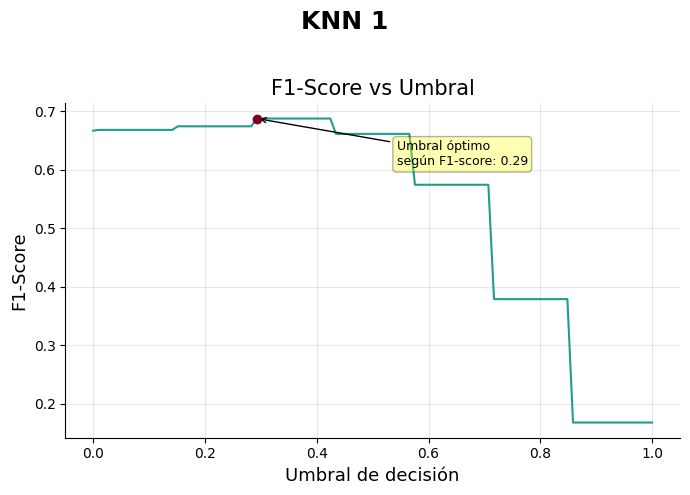

In [595]:
umbral_knn_1 = plot_umbrales(modelo=knn_1.best_estimator_,
                             score='F1-Score',
                             x=X_linear_cv,
                             y=y_linear_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='KNN 1')

In [596]:
knn_1_results_umbral = metricas_evaluacion(modelo=knn_1.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='KNN 1',
                                    conjunto='X_linear',
                                    umbral=0.29)

knn_results_tracking.append(knn_1_results_umbral)
pd.DataFrame(knn_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  KNN 1  X_linear    0.7251     0.5027  0.6364    0.5617  0.7513    0.50
1  KNN 1  X_linear    0.6459     0.4278  0.8283    0.5642  0.7513    0.29

In [597]:
pd.DataFrame(best_models)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   
1  RandomForest 5       X    0.7409     0.5208  0.8013    0.6313  0.8326   

   Umbral  
0    0.41  
1    0.44

Análisis: KNN 1 – GridSearchCV – Subconjunto X_linear
El procedimiento de búsqueda exhaustiva (GridSearchCV) identificó como configuración óptima de hiperparámetros los valores:

leaf_size = 5

n_neighbors = 7

Este clasificador logra incrementar marginalmente la tasa de sensibilidad (Recall) respecto a RandomForest 5 —modelo de referencia para esa familia de algoritmos—, aunque con un compromiso desfavorable en el balance precisión–exhaustividad. En particular, si bien consigue detectar un mayor número de verdaderos positivos (clientes que efectivamente desertan), la exactitud predictiva (Precision) disminuye en torno a un 9%.

Cabe señalar que, debido a que K-Nearest Neighbors realiza el cómputo de distancias durante la fase de inferencia, no resulta idóneo para contextos de despliegue productivo donde la latencia de respuesta constituye un factor crítico.

In [604]:
X_linear_cv['ChargesTotal_scaled']

0       0.696560
1       0.616675
2       0.748827
3       1.016452
4       0.772459
          ...   
3357    0.873700
3358   -0.062401
3359    0.497936
3360    1.236078
3361    0.831694
Name: ChargesTotal_scaled, Length: 3362, dtype: float64

Análisis: Support Vector Machine (SVM)

Support Vector Machine es un clasificador supervisado que busca determinar la hiperplano de separación óptimo entre clases, maximizando la distancia (margen) entre dicho hiperplano y los puntos críticos de cada categoría, conocidos como vectores de soporte.

Aunque su funcionamiento se fundamenta en métricas de distancia, la frontera de decisión depende únicamente de los vectores de soporte, no de la totalidad de las observaciones. Márgenes amplios tienden a favorecer la capacidad de generalización, reduciendo el riesgo de sobreajuste, mientras que márgenes estrechos pueden inducir un sobreajuste al conjunto de entrenamiento, aumentando la sensibilidad a ruido y outliers.

El hiperparámetro C regula este compromiso:

C elevado: penaliza fuertemente las observaciones mal clasificadas → modelo más restrictivo, margen reducido, mayor probabilidad de sobreajuste.

C reducido: permite tolerar más errores → modelo más flexible, margen mayor, riesgo de subajuste.

Adicionalmente, SVM facilita la transformación de los datos mediante funciones kernel, permitiendo encontrar un hiperplano lineal en un espacio de mayor dimensión incluso cuando las clases no son separables linealmente en el espacio original, optimizando así la discriminación entre categorías.

In [606]:
svm_results_tracking = []

SVM 1 - kernel = sigmoid

In [608]:
svm_1 = SVC(kernel='sigmoid', gamma='auto', C=1.0, random_state=42, probability=True)

svm_1_cv_results = cross_validate(svm_1, X_scaled_cv, y_scaled_cv, cv=skf)

In [609]:
cv_score_interval(svm_1_cv_results, nombre='SVM 1', score='Recall')

Recall promedio de SVM 1: 0.6056
Desviación estándar del Recall de SVM 1: 0.03
El Recall de SVM 1 estará entre [0.5456,0.6656] con un 95% de confianza


In [610]:
svm_1.fit(X_scaled_cv, y_scaled_cv)

SVC(gamma='auto', kernel='sigmoid', probability=True, random_state=42)

In [611]:
svm_1_results = metricas_evaluacion(modelo=svm_1,
                                    x_test=X_scaled_test,
                                    y_test=y_scaled_test,
                                    nombre='SVM 1',
                                    conjunto='X_scaled')

svm_results_tracking.append(svm_1_results)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7521     0.5512  0.5623    0.5567  0.7916     0.5

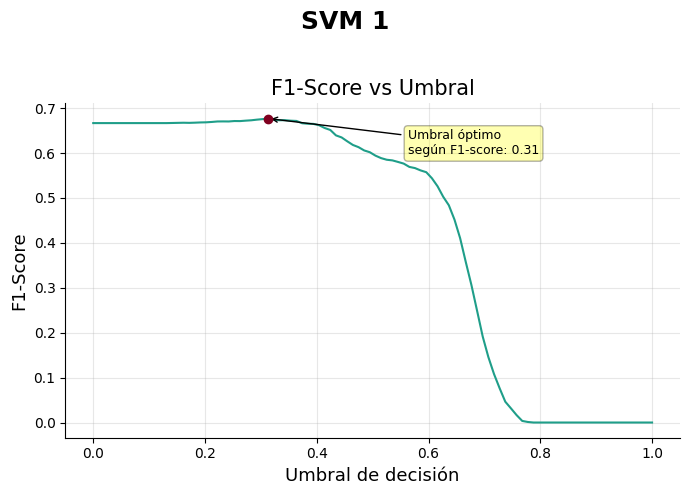

In [612]:
umbral_svm_1 = plot_umbrales(modelo=svm_1,
                             score='F1-Score',
                             x=X_scaled_cv,
                             y=y_scaled_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 1')

In [613]:
svm_1_results_umbral = metricas_evaluacion(modelo=svm_1,
                                            x_test=X_scaled_test,
                                            y_test=y_scaled_test,
                                            nombre='SVM 1',
                                            conjunto='X_scaled',
                                            umbral=0.31)

svm_results_tracking.append(svm_1_results_umbral)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7521     0.5512  0.5623    0.5567  0.7916    0.50
1  SVM 1  X_scaled    0.5079     0.3554  0.9562    0.5182  0.7916    0.31

Observaciones: SVM 1 - kernel=Sigmoid

El primer clasificador Support Vector Machine fue ajustado empleando un núcleo de tipo sigmoid, arrojando los siguientes indicadores de desempeño:

| Modelo | Conjunto  | Accuracy | Precision | Recall | F1-score | AUC    | Umbral |
| ------ | --------- | -------- | --------- | ------ | -------- | ------ | ------ |
| SVM 1  | X\_scaled | 0.7530   | 0.5530    | 0.5623 | 0.5576   | 0.7918 | 0.50   |


Al modificar el umbral de clasificación al valor óptimo determinado según la métrica F1-Score sobre el conjunto de entrenamiento, se obtienen los resultados siguientes:

| Modelo | Conjunto  | Accuracy | Precision | Recall | F1-score | AUC    | Umbral |
| ------ | --------- | -------- | --------- | ------ | -------- | ------ | ------ |
| SVM 1  | X\_scaled | 0.5098   | 0.3563    | 0.9562 | 0.5192   | 0.7918 | 0.31   |

Si bien la métrica prioritaria (Recall) evidencia un rendimiento sobresaliente, se aprecia una marcada disminución en Accuracy y Precision, lo que sugiere que el modelo logra un equilibrio óptimo para su consideración como representante de su familia de clasificadores. Posteriormente, se procederá a realizar una optimización de hiperparámetros mediante GridSearchCV, con el propósito de identificar la combinación óptima de kernel, C y gamma, maximizando la eficiencia predictiva del modelo, su sensibilidad como el equilibrio general del modelo.



SVM 2 - GridSearchCV - Conjunto X_scaled

In [614]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.7, 1.0, 1.5, 2.0],
    'gamma': ['auto', 'scale']
}

svm_2 = GridSearchCV(SVC(random_state=42, probability=True), param_grid=param_grid, scoring='recall', cv=skf)


svm_2.fit(X_scaled_cv, y_scaled_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.7, 1.0, 1.5, 2.0], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='recall')

In [615]:
svm_2.best_params_

{'C': 2.0, 'gamma': 'auto', 'kernel': 'sigmoid'}

In [616]:
svm_2_results = metricas_evaluacion(modelo=svm_2.best_estimator_,
                                    x_test=X_scaled_test,
                                    y_test=y_scaled_test,
                                    nombre='SVM 2',
                                    conjunto='X_scaled')

svm_results_tracking.append(svm_2_results)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7521     0.5512  0.5623    0.5567  0.7916    0.50
1  SVM 1  X_scaled    0.5079     0.3554  0.9562    0.5182  0.7916    0.31
2  SVM 2  X_scaled    0.7046     0.4721  0.5690    0.5160  0.7187    0.50

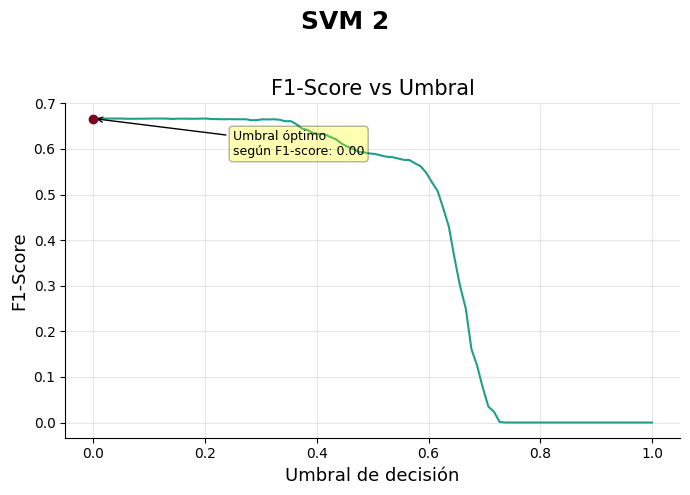

In [620]:
umbral_svm_2 = plot_umbrales(modelo=svm_2.best_estimator_,
                             score='F1-Score',
                             x=X_scaled_cv,
                             y=y_scaled_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 2')

In [618]:
svm_2_results_umbral = metricas_evaluacion(modelo=svm_2,
                                            x_test=X_scaled_test,
                                            y_test=y_scaled_test,
                                            nombre='SVM 2',
                                            conjunto='X_scaled',
                                            umbral=0.12)

svm_results_tracking.append(svm_2_results_umbral)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7521     0.5512  0.5623    0.5567  0.7916    0.50
1  SVM 1  X_scaled    0.5079     0.3554  0.9562    0.5182  0.7916    0.31
2  SVM 2  X_scaled    0.7046     0.4721  0.5690    0.5160  0.7187    0.50
3  SVM 2  X_scaled    0.2926     0.2808  0.9966    0.4382  0.7187    0.12

Observaciones: SVM 2 – GridSearchCV – Conjunto X_scaled

Inicialmente, se aprecia que la optimización de hiperparámetros mediante GridSearchCV produjo una reducción en la mayoría de los indicadores de desempeño, con la excepción de un ligero incremento en la sensibilidad (Recall).

El clasificador presenta un valor de AUC aproximadamente 7.3% inferior al modelo previo, lo que sugiere que su capacidad discriminativa para diferenciar correctamente entre las clases desbalanceadas es menor.

Adicionalmente, el umbral de decisión que maximiza la puntuación F1 sobre el conjunto de entrenamiento balanceado es notablemente bajo, provocando que, aunque se logre identificar casi la totalidad de clientes que abandonan (alta sensibilidad), la tasa de falsos positivos se incremente considerablemente, disminuyendo la capacidad del modelo para reconocer con precisión a los clientes que permanecen activos.

SVM 3 - GridSearchCV - kernel='linear' - Conjunto X_linear

Se entrenará un tercer modelo de esta familia utilizando el conjunto X_linear, y forzando el uso de kernel=linear. Ya que al trabajar con distancia, este modelo puede entrar en conflictos al manejar la multicolinealidad presente en el conjunto X_scaled donde se utilizo una codificación one_hot_encoder(drop='if_binary').

In [621]:
param_grid = {
    'kernel': ['linear'],
    'C': [0.7, 1.0, 1.5, 2.0],
    'gamma': ['auto', 'scale']
}

svm_3 = GridSearchCV(SVC(random_state=42, probability=True), param_grid=param_grid, scoring='recall', cv=skf)


svm_3.fit(X_linear_cv, y_linear_cv)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.7, 1.0, 1.5, 2.0], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear']},
             scoring='recall')

In [622]:
svm_3.best_params_

{'C': 2.0, 'gamma': 'auto', 'kernel': 'linear'}

In [623]:
svm_3_results = metricas_evaluacion(modelo=svm_3.best_estimator_,
                                    x_test=X_linear_test,
                                    y_test=y_linear_test,
                                    nombre='SVM 3',
                                    conjunto='X_linear')

svm_results_tracking.append(svm_3_results)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7521     0.5512  0.5623    0.5567  0.7916    0.50
1  SVM 1  X_scaled    0.5079     0.3554  0.9562    0.5182  0.7916    0.31
2  SVM 2  X_scaled    0.7046     0.4721  0.5690    0.5160  0.7187    0.50
3  SVM 2  X_scaled    0.2926     0.2808  0.9966    0.4382  0.7187    0.12
4  SVM 3  X_linear    0.7540     0.5563  0.5488    0.5525  0.8073    0.50

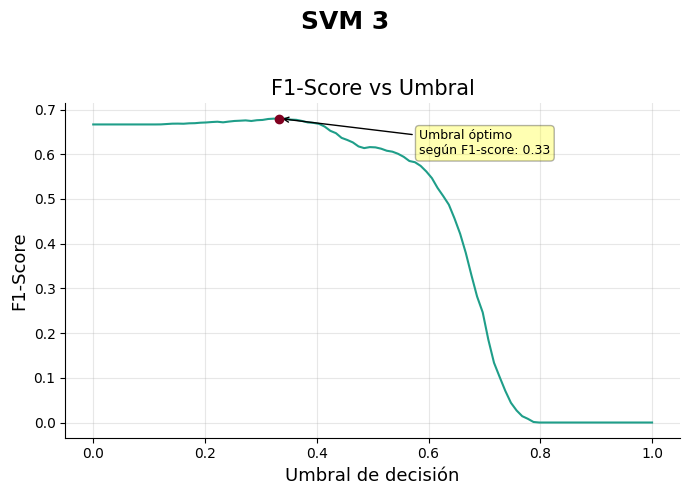

In [624]:
umbral_svm_3 = plot_umbrales(modelo=svm_3.best_estimator_,
                             score='F1-Score',
                             x=X_linear_cv,
                             y=y_linear_cv,
                             caja_x=0.25,
                             caja_y=0.08,
                             nombre='SVM 3')

In [625]:
svm_3_results_umbral = metricas_evaluacion(modelo=svm_3.best_estimator_,
                                            x_test=X_linear_test,
                                            y_test=y_linear_test,
                                            nombre='SVM 3',
                                            conjunto='X_linear',
                                            umbral=0.33)

svm_results_tracking.append(svm_3_results_umbral)
pd.DataFrame(svm_results_tracking)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  Umbral
0  SVM 1  X_scaled    0.7521     0.5512  0.5623    0.5567  0.7916    0.50
1  SVM 1  X_scaled    0.5079     0.3554  0.9562    0.5182  0.7916    0.31
2  SVM 2  X_scaled    0.7046     0.4721  0.5690    0.5160  0.7187    0.50
3  SVM 2  X_scaled    0.2926     0.2808  0.9966    0.4382  0.7187    0.12
4  SVM 3  X_linear    0.7540     0.5563  0.5488    0.5525  0.8073    0.50
5  SVM 3  X_linear    0.5881     0.3960  0.9293    0.5553  0.8073    0.33

In [626]:
pd.DataFrame(best_models)

Model Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model       X    0.6915     0.4663  0.7912    0.5868  0.7418   
1  RandomForest 5       X    0.7409     0.5208  0.8013    0.6313  0.8326   

   Umbral  
0    0.41  
1    0.44

Observaciones: SVM 3 - GridSearchCV - kernel='linear' - Conjunto X_linear

El modelo SVM 3 consigue superar al resto de modelos dentro de esta familia.

Se comprueba que al utilizar el conjunto X_linear, este se beneficia de la codificación one_hot_encoder(drop='first'), la cual evita la introducción manual de multicolinealidad al conjunto de datos.



Conclusiones Support Vector Machine
El algoritmo de Support Vector Machine consiguió alcanzar el Recall más alto entre todos los modelos entrenados. Utilizando los hiperparámetros adecuados, y un conjunto de datos preprocesado apropiadamente para dicho modelo, este logra maximizar la métrica prioritaria para el problema de negocios, aún manteniendo una buena estabilidad en términos generales.

Sin embargo, la Precisión del mismo cae por debajo de 0.4, lo cual puede resultar en la destinación de recursos a un sector de clientes que realmente no necesita ser intervenido.

Como representante de esta famlia, se tomará el modelo SVM 3.

In [627]:
best_models.append(svm_3_results_umbral)
pd.DataFrame(best_models)

Model   Dataset  Accuracy  Precision  Recall  F1-score     AUC  \
0  Baseline Model         X    0.6915     0.4663  0.7912    0.5868  0.7418   
1  RandomForest 5         X    0.7409     0.5208  0.8013    0.6313  0.8326   
2           SVM 3  X_linear    0.5881     0.3960  0.9293    0.5553  0.8073   

   Umbral  
0    0.41  
1    0.44  
2    0.33

In [628]:
try:
    with open(MODELS_PATH / 'best_svm.pkl', 'wb') as f:
        pickle.dump(svm_3.best_estimator_, f)
except Exception:
    with open(MODELS_PATH / 'best_svm.pkl', 'wb') as f:
        pickle.dump(svm_3, f)

# 5. Evaluación Mejores Modelos

A continuación se llevarán a cabo distintas evaluaciones sobre los modelos seleccionados como representantes de cada familia.

El objetivo es analizar distintos aspectos del desempeño de estos para determinar cual presenta las mejores condiciones para entornos productivos.

In [631]:
with open(MODELS_PATH / 'best_randomforest.pkl', 'rb') as f:
    random_forest = pickle.load(f)

with open(MODELS_PATH / 'best_svm.pkl', 'rb') as f:
    svm = pickle.load(f)

Métricas Generales y Umbrales de Decisión

In [633]:
random_forest_eval = metricas_evaluacion(random_forest,
                                         X_test,
                                         y_test,
                                         nombre='Best Random Forest',
                                         conjunto='X')
svm_eval = metricas_evaluacion(svm,
                               X_linear_test,
                               y_linear_test,
                               nombre='Best Support Vector Machine',
                               conjunto='X_linear')


metricas_eval = [random_forest_eval, svm_eval]

pd.DataFrame(metricas_eval)

Model   Dataset  Accuracy  Precision  Recall  \
0           Best Random Forest         X    0.7698     0.5654  0.7273   
1  Best Support Vector Machine  X_linear    0.7540     0.5563  0.5488   

   F1-score     AUC  Umbral  
0    0.6362  0.8326     0.5  
1    0.5525  0.8073     0.5

In [635]:
modelos = [random_forest, svm]

nombres = ['Best Random Forest',
           'Best Support Vector Machine']

X_conjuntos = [X_test,
               X_linear_test]

y_conjuntos = [y_test,
               y_linear_test]

nombres_conjuntos = ['X',
                     'X_linear']

rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)

        if resultado_umbral['Recall'] > 0.9:
            resultados_umbrales.append(resultado_umbral)
            break

pd.DataFrame(resultados_umbrales)

Model   Dataset  Accuracy  Precision  Recall  \
0           Best Random Forest         X    0.6766     0.4573  0.9024   
1  Best Support Vector Machine  X_linear    0.6198     0.4150  0.9125   

   F1-score     AUC  Umbral  
0    0.6070  0.8326    0.34  
1    0.5705  0.8073    0.35

In [636]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)

        if resultado_umbral['Recall'] > 0.85:
            resultados_umbrales.append(resultado_umbral)
            break

pd.DataFrame(resultados_umbrales)

Model   Dataset  Accuracy  Precision  Recall  \
0           Best Random Forest         X    0.7148     0.4914   0.862   
1  Best Support Vector Machine  X_linear    0.6785     0.4571   0.862   

   F1-score     AUC  Umbral  
0    0.6259  0.8326    0.39  
1    0.5974  0.8073    0.38

In [637]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)

        if resultado_umbral['Recall'] > 0.8:
            resultados_umbrales.append(resultado_umbral)
            break

pd.DataFrame(resultados_umbrales)

Model   Dataset  Accuracy  Precision  Recall  \
0           Best Random Forest         X    0.7409     0.5208  0.8013   
1  Best Support Vector Machine  X_linear    0.6934     0.4689  0.8114   

   F1-score     AUC  Umbral  
0    0.6313  0.8326    0.44  
1    0.5943  0.8073    0.40

In [638]:
rango_umbrales = np.round(np.linspace(0.45, 0.31, 15), 2)

resultados_umbrales = []

for i, modelo in enumerate(modelos):
    for umbral in rango_umbrales:
        resultado_umbral = metricas_evaluacion(modelo=modelo,
                                               x_test = X_conjuntos[i],
                                               y_test = y_conjuntos[i],
                                               nombre=nombres[i],
                                               conjunto=nombres_conjuntos[i],
                                               umbral=umbral)

        if resultado_umbral['Recall'] > 0.85:
            resultados_umbrales.append(resultado_umbral)
            break

pd.DataFrame(resultados_umbrales)

Model   Dataset  Accuracy  Precision  Recall  \
0           Best Random Forest         X    0.7148     0.4914   0.862   
1  Best Support Vector Machine  X_linear    0.6785     0.4571   0.862   

   F1-score     AUC  Umbral  
0    0.6259  0.8326    0.39  
1    0.5974  0.8073    0.38

Primeras Conclusiones: Best Random Forest

El modelo Random Forest óptimo sigue evidenciando los indicadores de desempeño más consistentes y robustos. Al analizar las fluctuaciones en la métrica prioritaria (sensibilidad / Recall), se observa que presenta la menor variabilidad necesaria para alcanzar el valor objetivo.

Estas características lo posicionan como el modelo candidato principal (Champion Model) para su despliegue en entornos productivos, al proporcionar un equilibrio óptimo entre sensibilidad y valor predictivo positivo (Precision), factor crítico para el diseño de una estrategia eficiente de retención de clientes.

In [646]:
metricas_eval

[{'Model': 'Best Random Forest',
  'Dataset': 'X',
  'Accuracy': np.float64(0.7698),
  'Precision': np.float64(0.5654),
  'Recall': np.float64(0.7273),
  'F1-score': np.float64(0.6362),
  'AUC': np.float64(0.8326),
  'Umbral': 0.5},
 {'Model': 'Best Support Vector Machine',
  'Dataset': 'X_linear',
  'Accuracy': np.float64(0.754),
  'Precision': np.float64(0.5563),
  'Recall': np.float64(0.5488),
  'F1-score': np.float64(0.5525),
  'AUC': np.float64(0.8073),
  'Umbral': 0.5}]

In [648]:
recall = []
precision = []

for metrica in metricas_eval:
    modelo_rec = {}
    modelo_prec = {}
    for key, value in metrica.items():

        if key == 'Model':
            modelo_rec[key] = value
            modelo_prec[key] = value
        if key == 'Recall':
            modelo_rec['Recall (Umbral=0.5)'] = value
        if key == 'Precision':
            modelo_prec['Precision (Umbral=0.5)'] = value

    recall.append(modelo_rec)
    precision.append(modelo_prec)

for i, metrica in enumerate(resultados_umbrales):
    modelo_rec = recall[i]
    modelo_prec = precision[i]
    for key, value in metrica.items():
        if key == 'Recall':
            name = 'Recall (Umbral modificado)'
            modelo_rec[name] = value
        if key == 'Precision':
            name = 'Precision (Umbral modificado)'
            modelo_prec[name] = value

In [649]:
df_recall_diff = pd.DataFrame(recall)
df_precision_diff = pd.DataFrame(precision)

In [650]:
diff = (df_recall_diff["Recall (Umbral modificado)"] - df_recall_diff["Recall (Umbral=0.5)"])
df_recall_diff['Variación'] = diff.apply(lambda x: f'{x * 100:.2f}%')

diff = (df_precision_diff["Precision (Umbral modificado)"] - df_precision_diff["Precision (Umbral=0.5)"])
df_precision_diff['Variación'] = diff.apply(lambda x: f'{x * 100:.2f}%')

In [651]:
df_recall_diff

Model  Recall (Umbral=0.5)  \
0           Best Random Forest               0.7273   
1  Best Support Vector Machine               0.5488   

   Recall (Umbral modificado) Variación  
0                       0.862    13.47%  
1                       0.862    31.32%

In [652]:
df_precision_diff

Model  Precision (Umbral=0.5)  \
0           Best Random Forest                  0.5654   
1  Best Support Vector Machine                  0.5563   

   Precision (Umbral modificado) Variación  
0                         0.4914    -7.40%  
1                         0.4571    -9.92%

In [657]:
# Creamos otra función

def generar_tabla1(df,
                  title: str,
                  save: str,
                  figsize: tuple = (8,6),
                  path: Path = IMG_PATH):

    import matplotlib.pyplot as plt
    import numpy as np

    # Crear figura
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')  # Ocultar ejes

    # Colores alternados para filas
    colors = [COLOR_1, COLOR_4]
    color_order = [colors[i % 2] for i in range(len(df))]

    # Colores de las celdas por fila y columna
    cell_colors = [[color]*df.shape[1] for color in color_order]

    # Redondear valores numéricos
    table_data = df.copy()
    for col in table_data.columns:
        if np.issubdtype(table_data[col].dtype, np.number):
            table_data[col] = table_data[col].round(4)

    # Crear tabla
    tabla = ax.table(cellText=table_data.values.tolist(),
                     colLabels=table_data.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=[COLOR_6]*df.shape[1],
                     cellColours=cell_colors)

    # Configurar fuente
    tabla.auto_set_font_size(False)
    for (row, col), cell in tabla.get_celld().items():
        cell.set_fontsize(10)

    # Título
    plt.title(title, fontsize=18, fontweight='bold')

    # Escalar tabla
    tabla.scale(1, 2)

    plt.tight_layout()

    # Guardar imagen
    fig.savefig(path / f'{save}.png', transparent=True, dpi=300, bbox_inches='tight')
    plt.show()


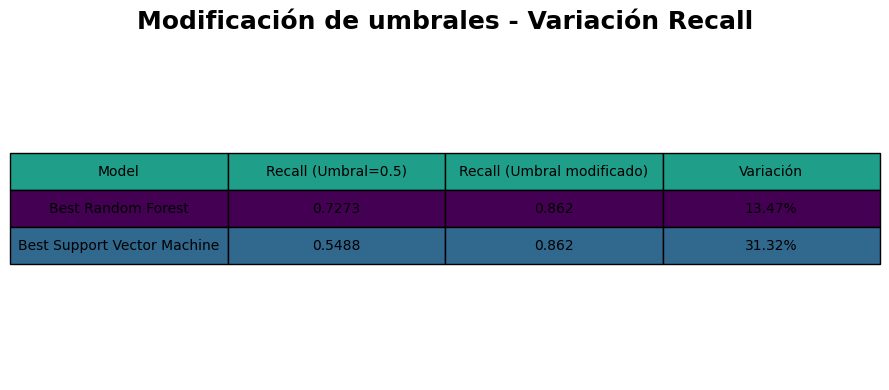

In [655]:
generar_tabla1(df_recall_diff,
              title='Modificación de umbrales - Variación Recall',
              save='recall_diff',
              figsize=(9,4))

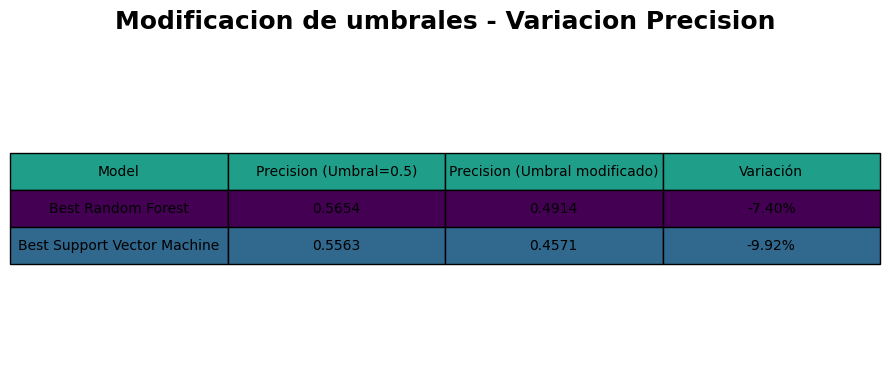

In [656]:
generar_tabla1(df_precision_diff,
              title='Modificacion de umbrales - Variacion Precision',
              save='precision_diff',
              figsize=(9,4))

Conclusiones: Métricas Generales y Umbrales de Decisión

Al analizar los indicadores de desempeño de los modelos seleccionados como representantes de cada familia, se aprecia que el Random Forest óptimo (Best Random Forest) exhibe la mayor robustez frente al desbalance de clases. Este modelo alcanza un valor de AUC = 0.8326, lo que implica que, al seleccionar aleatoriamente un caso positivo (Churn = 1) y uno negativo (Churn = 0), existe una probabilidad del 83.26% de que el modelo asigne una puntuación superior al caso positivo.

Esta métrica refleja la capacidad discriminativa del clasificador para diferenciar correctamente entre ambas clases sin depender de un umbral de decisión específico, lo cual resulta crítico en escenarios con desbalance de clases significativo.

Manteniendo el umbral de decisión por defecto (0.5), el Best Random Forest también alcanza los valores más elevados de sensibilidad (Recall) y puntuación F1 (F1-score), reforzando su rendimiento global y la estabilidad del modelo, lo que lo posiciona como el candidato más sólido para su implementación en entornos productivos.



| Modelo                      | Dataset   | Accuracy | Precision | Recall | F1-score | AUC    | Umbral |
| --------------------------- | --------- | -------- | --------- | ------ | -------- | ------ | ------ |
| Best Random Forest          | X         | 0.7698   | 0.5654    | 0.7273 | 0.6362   | 0.8326 | 0.5    |
| Best Support Vector Machine | X\_linear | 0.7540   | 0.5563    | 0.5488 | 0.5525   | 0.8073 | 0.5    |


Dado que el objetivo estratégico es minimizar la tasa de abandono de clientes, se prioriza que el modelo sea capaz de detectar con alta sensibilidad la mayor proporción posible de clientes que abandonan. Para alcanzar este propósito, se exploraron distintos umbrales de decisión que optimizaran la sensibilidad (Recall), manteniendo niveles aceptables de valor predictivo positivo (Precision) y puntuación F1 (F1-score), de manera que las acciones de retención resulten tanto eficaces como económicamente rentables.

Se identificó que los umbrales comprendidos entre 0.38 y 0.39 permiten lograr valores de Recall superiores a 0.85, mientras que la Precision se mantiene en un rango de 0.45 a 0.50, evidenciando un balance operativo adecuado entre la captura de abandonos y la reducción de falsos positivos.

| Modelo                      | Dataset   | Accuracy | Precision | Recall | F1-score | AUC    | Umbral |
| --------------------------- | --------- | -------- | --------- | ------ | -------- | ------ | ------ |
| Best Random Forest          | X         | 0.7148   | 0.4914    | 0.8620 | 0.6259   | 0.8326 | 0.39   |
| Best Support Vector Machine | X\_linear | 0.6785   | 0.4571    | 0.8620 | 0.5974   | 0.8073 | 0.38   |


Incluso tras ajustar el umbral de decisión, el Random Forest óptimo (Best Random Forest) sigue evidenciando indicadores de desempeño consistentes y robustos. Al analizar las fluctuaciones en la métrica prioritaria (sensibilidad / Recall), se observa que este modelo requiere la menor variabilidad para alcanzar el valor objetivo, lo que refleja su estabilidad predictiva y su capacidad de mantener un rendimiento confiable frente a cambios en el umbral de clasificación, convirtiendo este modelo a un candidato principal para Champion Model.

| Model                       | Recall (Umbral=0.5) | Recall (Umbral modificado) | Variación |
| --------------------------- | ------------------- | -------------------------- | --------- |
| Best Random Forest          | 0.7273              | 0.8620                     | 13.47%    |
| Best Support Vector Machine | 0.5488              | 0.8620                     | 31.32%    |


Esto se traduce en la menor caída en Precisión para alcanzar dicho objetivo:

| Model                       | Precision (Umbral=0.5) | Precision (Umbral modificado) | Variación |
| --------------------------- | ---------------------- | ----------------------------- | --------- |
| Best Random Forest          | 0.5654                 | 0.4914                        | -7.40%    |
| Best Support Vector Machine | 0.5563                 | 0.4571                        | -9.92%    |


Subajuste (Underfitting) y Subajuste (Overfitting)

In [659]:
random_forest_train = metricas_evaluacion(random_forest, X_cv, y_cv, 'Best Random Forest', conjunto='X')
svm_train = metricas_evaluacion(svm, X_linear_cv, y_linear_cv, 'Best Support Vector Machine', conjunto='X_linear')
metricas_train = [random_forest_train, svm_train]

pd.DataFrame(metricas_train)

Model   Dataset  Accuracy  Precision  Recall  \
0           Best Random Forest         X    0.8659     0.8580  0.8769   
1  Best Support Vector Machine  X_linear    0.6208     0.6261  0.5996   

   F1-score     AUC  Umbral  
0    0.8673  0.9481     0.5  
1    0.6126  0.6784     0.5

In [660]:
recall = []
f1 = []

for metrica in metricas_train:
    modelo_rec = {}
    modelo_f1 = {}
    for key, value in metrica.items():

        if key == 'Model':
            modelo_rec[key] = value
            modelo_f1[key] = value
        if key == 'Recall':
            modelo_rec['Recall Train'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Train'] = value

    recall.append(modelo_rec)
    f1.append(modelo_f1)

for i, metrica in enumerate(metricas_eval):
    modelo_rec = recall[i]
    modelo_f1 = f1[i]
    for key, value in metrica.items():
        if key == 'Recall':
            modelo_rec['Recall Test'] = value
        if key == 'F1-score':
            modelo_f1['F1-score Test'] = value

In [661]:
for modelo in recall:
    diff = np.round(modelo['Recall Test'] - modelo['Recall Train'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

for modelo in f1:
    diff = np.round(modelo['F1-score Test'] - modelo['F1-score Train'], 4)
    modelo['Variación'] = f'{diff * 100:.2f}%'

df_recall_diff = pd.DataFrame(recall)
df_f1_diff = pd.DataFrame(f1)

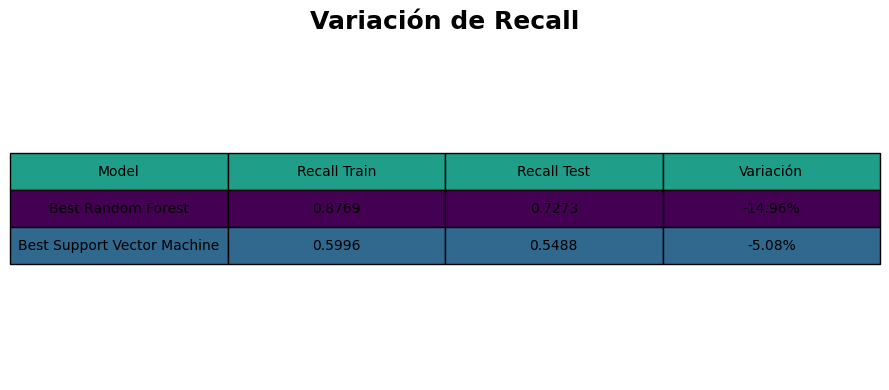

In [662]:
generar_tabla1(df_recall_diff,
              title='Variación de Recall',
              save='recall_train_test',
              figsize=(9,4))

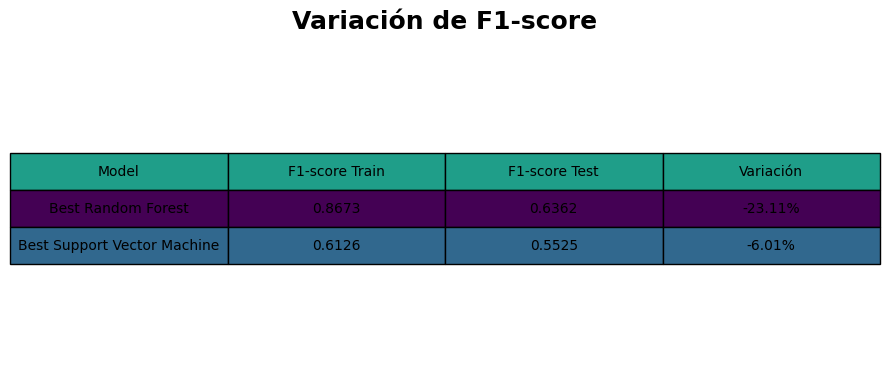

In [663]:
generar_tabla1(df_f1_diff,
              title='Variación de F1-score',
              save='f1_train_test',
              figsize=(9,4))

In [664]:
df_recall_diff

Model  Recall Train  Recall Test Variación
0           Best Random Forest        0.8769       0.7273   -14.96%
1  Best Support Vector Machine        0.5996       0.5488    -5.08%

In [665]:
df_f1_diff

Model  F1-score Train  F1-score Test Variación
0           Best Random Forest          0.8673         0.6362   -23.11%
1  Best Support Vector Machine          0.6126         0.5525    -6.01%

Subajuste (Underfitting)

Con respecto a este aspecto, ninguno de los modelos evidenció subajuste (underfitting), dado que durante la fase de entrenamiento todos lograron un desempeño aceptable en sus respectivos indicadores.

| Model                     | Dataset    | Accuracy | Precision | Recall  | F1-score | AUC    | Umbral |
|---------------------------|-----------|---------|-----------|--------|----------|--------|--------|
| Best Random Forest        | X         | 0.8659  | 0.8580    | 0.8769 | 0.8673   | 0.9481 | 0.5    |
| Best Support Vector Machine| X_linear | 0.6208  | 0.6261    | 0.5996 | 0.6126   | 0.6784 | 0.5    |

Al examinar el valor de Accuracy, considerando que los datos de entrenamiento fueron balanceados, se observa que todos los modelos superan al menos el 60%, lo que indica que no realizan predicciones de manera aleatoria, sino que han logrado capturar relaciones significativas entre las variables predictoras y la variable objetivo.

Sobreajuste (Overfitting)

Best Random Forest

El modelo Best Random Forest evidencia un marcado sobreajuste. Durante la fase de entrenamiento, sus métricas presentan un promedio general de 0.87, mientras que al evaluarlo sobre el conjunto de prueba, se observa una disminución significativa en su desempeño, reflejando cierta pérdida de capacidad de generalización.

| Métrica   | Train   | Test    | Variación  |
|-----------|--------|--------|------------|
| Recall    | 0.8769 | 0.7273 | -14.96%    |
| F1-score  | 0.8673 | 0.6362 | -23.11%    |

A pesar de este comportamiento, el modelo continúa siendo el que mejor discrimina entre clases en el conjunto de prueba, lo que indica que ha logrado capturar patrones estadísticamente relevantes, aunque podría beneficiarse de una regularización más fuerte para mejorar su capacidad de generalización y reducir la brecha entre desempeño de entrenamiento y prueba.

Best Support Vector Machine – Desempeño General

El modelo Best Support Vector Machine presenta los indicadores de desempeño más bajos en términos generales. Aunque las diferencias entre entrenamiento y prueba no son elevadas, los valores de sus métricas en ambas fases se sitúan alrededor de 0.58, reflejando un rendimiento limitado.

| Métrica   | Train   | Test    | Variación  |
|-----------|--------|--------|------------|
| Recall    | 0.5996 | 0.5488 | -5.08%     |
| F1-score  | 0.6126 | 0.5525 | -6.01%     |

Esto sugiere que, a diferencia del comportamiento observado durante el entrenamiento, el modelo no logra capturar patrones estadísticamente relevantes cuando se enfrenta a datos no vistos (conjunto de prueba), probablemente debido a su naturaleza lineal, que limita su capacidad para modelar relaciones complejas y no lineales presentes en los datos.

Mejores Modelos Confusion Matrices

En la exploración de umbrales de decisión, se estableció que un escenario óptimo consistía en lograr que los modelos fueran capaces de identificar al 85% de los clientes propensos a abandonar la empresa.

Para alcanzar este objetivo, resulta inevitable implementar una compensación estratégica, ya que parte de los clientes con baja probabilidad de cancelación serán incluidos en las intervenciones preventivas.

Mediante el análisis de las matrices de confusión, es posible cuantificar la proporción de clientes que serán intervenidos de manera incorrecta, proporcionando información crítica sobre la eficacia operativa y el riesgo de falsos positivos de cada uno de los modelos seleccionados.

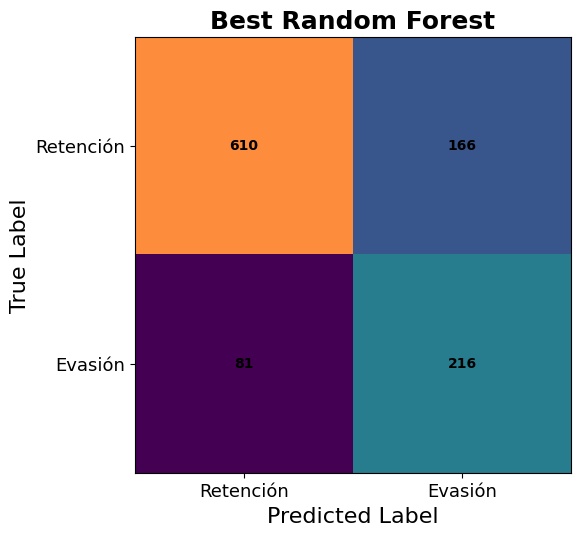

In [666]:
plot_conf_mat(model=random_forest,
              x=X_test,
              y=y_test,
              name='Best Random Forest',
              save='confmat_random_forest')

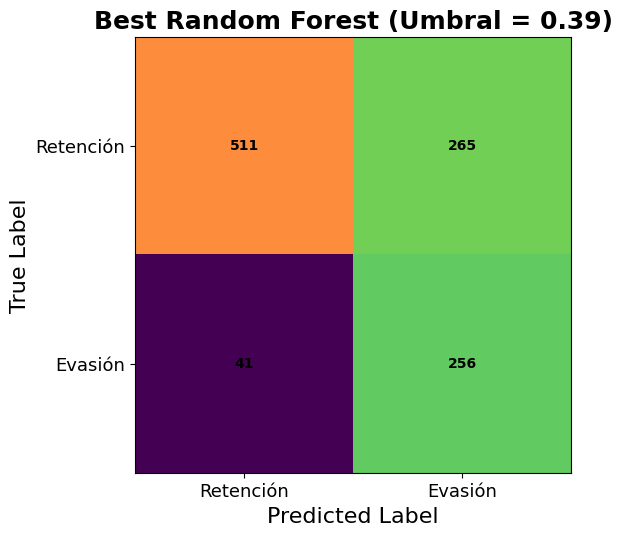

In [667]:
plot_conf_mat(model=random_forest,
              x=X_test,
              y=y_test,
              name='Best Random Forest (Umbral = 0.39)',
              save='confmat_random_forest_umbral',
              umbral=0.39)

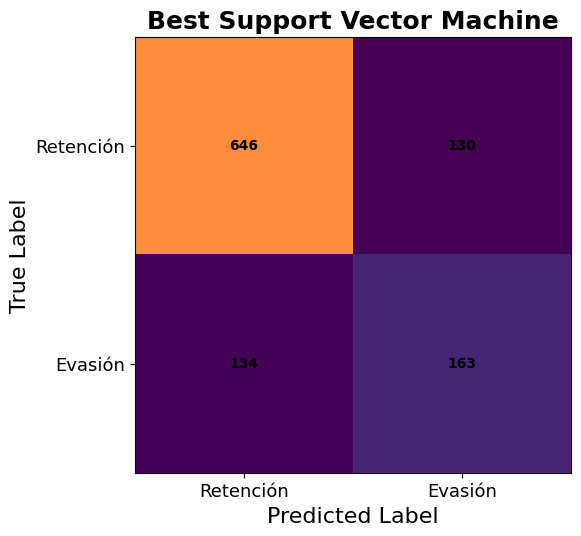

In [668]:
plot_conf_mat(model=svm,
              x=X_linear_test,
              y=y_linear_test,
              name='Best Support Vector Machine',
              save='confmat_svm')

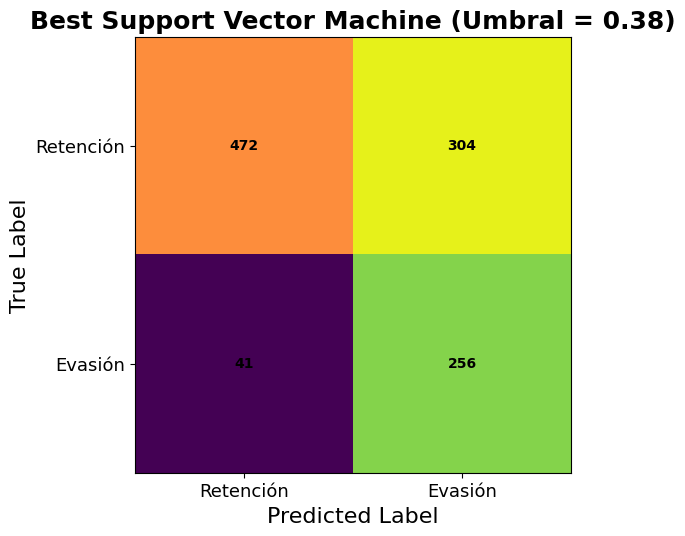

In [669]:

plot_conf_mat(model=svm,
              x=X_linear_test,
              y=y_linear_test,
              name='Best Support Vector Machine (Umbral = 0.38)',
              save='confmat_svm_umbral',
              umbral=0.38)

Conclusiones: Matrices de Confusión

Para lograr que se identifiquen correctamente el 85% de los casos positivos, cada modelo clasifica erróneamente como abandono una cierta cantidad de clientes que en realidad no lo están.

| Modelo                   | Casos Positivos Verdaderos | Casos Positivos Falsos |
|--------------------------|---------------------------|------------------------|
| Best Random Forest       | 256                       | 265                    |
| Best Logistic Regression | 256                       | 308                    |
| Best XGB Classifier      | 254                       | 287                    |
| Best Support Vector Machine | 256                    | 304                    |

Como se observa en la tabla, al ajustar el umbral de decisión para que todos los modelos puedan capturar correctamente el 85% de los clientes que abandonan (Churn = 1), el modelo que genera la menor cantidad de falsos positivos es el Best Random Forest. Esto indica que dicho modelo es el más adecuado para dirigir campañas de retención, ya que logra identificar una proporción elevada de clientes propensos a cancelar sus servicios, manteniendo al mismo tiempo un nivel eficiente de intervenciones preventivas.

Importancias y Coeficientes

Best Random Forest - Importancias

In [670]:
rf_importancias = random_forest.feature_importances_
features = X_test.columns

df_importancias_rf = pd.DataFrame({'Feature': features,
                                   'Importancia': rf_importancias}).sort_values('Importancia', ascending=False)
df_importancias_rf

Feature  Importancia
23                                   Tenure     0.201828
25                             ChargesTotal     0.195428
24                           ChargesMonthly     0.127672
15                  Contract_Month-to-month     0.061776
21           PaymentMethod_Electronic check     0.037018
12                          TechSupport_Yes     0.036106
17                        Contract_Two year     0.027935
7               InternetService_Fiber optic     0.027061
9                        OnlineSecurity_Yes     0.026136
18                     PaperlessBilling_Yes     0.024943
0                               Gender_Male     0.019606
5                         MultipleLines_Yes     0.018431
14                      StreamingMovies_Yes     0.017865
16                        Contract_One year     0.017757
13                          StreamingTV_Yes     0.017615
3                            Dependents_Yes     0.016910
10                         OnlineBackup_Yes     0.016560
2                               Partner_Yes     0.016240
6                       InternetService_DSL     0.015794
1                         SeniorCitizen_Yes     0.014550
11                     DeviceProtection_Yes     0.014464
22               PaymentMethod_Mailed check     0.012855
20    PaymentMethod_Credit card (automatic)     0.011235
19  PaymentMethod_Bank transfer (automatic)     0.010881
4                          PhoneService_Yes     0.009429
8                         NoInternetService     0.003907

In [671]:
df_importancias_rf[:10]

Feature  Importancia
23                          Tenure     0.201828
25                    ChargesTotal     0.195428
24                  ChargesMonthly     0.127672
15         Contract_Month-to-month     0.061776
21  PaymentMethod_Electronic check     0.037018
12                 TechSupport_Yes     0.036106
17               Contract_Two year     0.027935
7      InternetService_Fiber optic     0.027061
9               OnlineSecurity_Yes     0.026136
18            PaperlessBilling_Yes     0.024943

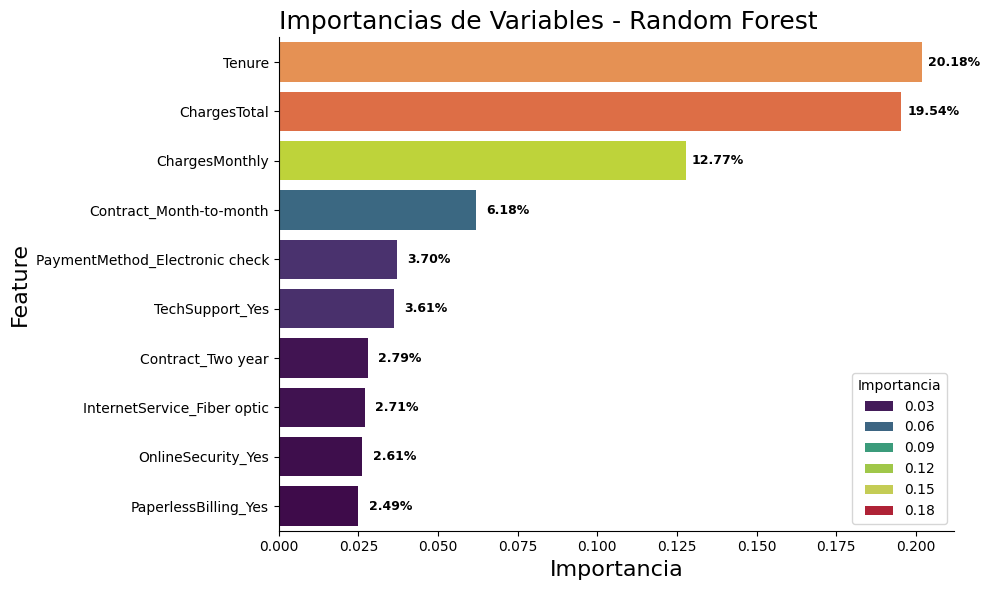

In [672]:
plot_analisis_variables(df=df_importancias_rf,
                        analisis='Importancia',
                        nombre_modelo='Random Forest',
                        n_vars=10,
                        save='RandomForest_importancias',
                        space=0.05)

In [673]:

rf_importancia_10 = np.round(df_importancias_rf['Importancia'].head(10).sum(), 4)
print(f'Importancia de las 10 variables más relevantes: {rf_importancia_10}')

Importancia de las 10 variables más relevantes: 0.7659


Observaciones: Best Random Forest – Relevancia de Variables

A partir de la evaluación de las importancias relativas derivadas del modelo Random Forest óptimo, se identificaron las 10 variables cuya contribución supera 0.02:

- Tenure
- ChargesTotal
- ChargesMonthly
- Contract_Month-to-month
- PaymentMethod_Electronic check
- TechSupport_Yes
- Contract_Two year
- InternetService_Fiber optic
- OnlineSecurity_Yes
- PaperlessBilling_Yes

La suma acumulada de estas importancias alcanza el 76.59%, lo que evidencia que estas características explican la mayor parte de la variabilidad en las decisiones del modelo. Dicho de otro modo, contribuyen en tres cuartas partes a la disminución de impureza (Gini o Entropía) en los nodos durante la construcción de los árboles de decisión.

En particular, las tres variables numéricas —Tenure (20.18%), ChargesTotal (19.54%) y ChargesMonthly (12.77%)— representan conjuntamente el 52.49% de la importancia total, lo que sugiere que el modelo focaliza gran parte de su capacidad de partición en estas características, logrando más de la mitad de la reducción de impureza únicamente con ellas.

No obstante, este enfoque no permite cuantificar el efecto individual de cada variable sobre la probabilidad de abandono (Churn). La relevancia asignada indica únicamente su capacidad para mejorar la separación entre clases durante la construcción del modelo, pero no ofrece información sobre la magnitud ni la dirección del efecto sobre el resultado, a diferencia de los modelos lineales que utilizan coeficientes interpretables.

Best Support Vector Machine - Coeficientes

In [677]:
svm_coeficientes = svm.coef_[0]
features = X_linear_cv.columns

df_coeficientes_svm = pd.DataFrame({'Feature': features,
                                    'Coeficiente': svm_coeficientes}).sort_values('Coeficiente', ascending=False)
df_coeficientes_svm

Feature  Coeficiente
6             InternetService_Fiber optic     1.306777
18         PaymentMethod_Electronic check     0.297383
1                       SeniorCitizen_Yes     0.232752
12                        StreamingTV_Yes     0.227853
5                       MultipleLines_Yes     0.216517
16                   PaperlessBilling_Yes     0.208265
13                    StreamingMovies_Yes     0.204225
15                      Contract_Two year     0.109581
19             PaymentMethod_Mailed check     0.100936
10                   DeviceProtection_Yes     0.058175
17  PaymentMethod_Credit card (automatic)     0.025508
2                             Partner_Yes     0.010502
9                        OnlineBackup_Yes    -0.004237
0                             Gender_Male    -0.016000
3                          Dependents_Yes    -0.024558
8                      OnlineSecurity_Yes    -0.052651
11                        TechSupport_Yes    -0.059619
14                      Contract_One year    -0.061560
22                    ChargesTotal_scaled    -0.083803
21                  ChargesMonthly_scaled    -0.245003
7                       NoInternetService    -0.290493
4                        PhoneService_Yes    -0.688932
20                          Tenure_scaled    -1.394731

In [678]:
var_risk = df_coeficientes_svm.head(5)
var_prot = df_coeficientes_svm.tail(5)

df_coeficientes_svm = pd.concat([var_risk, var_prot])

In [679]:
df_coeficientes_svm

Feature  Coeficiente
6      InternetService_Fiber optic     1.306777
18  PaymentMethod_Electronic check     0.297383
1                SeniorCitizen_Yes     0.232752
12                 StreamingTV_Yes     0.227853
5                MultipleLines_Yes     0.216517
22             ChargesTotal_scaled    -0.083803
21           ChargesMonthly_scaled    -0.245003
7                NoInternetService    -0.290493
4                 PhoneService_Yes    -0.688932
20                   Tenure_scaled    -1.394731

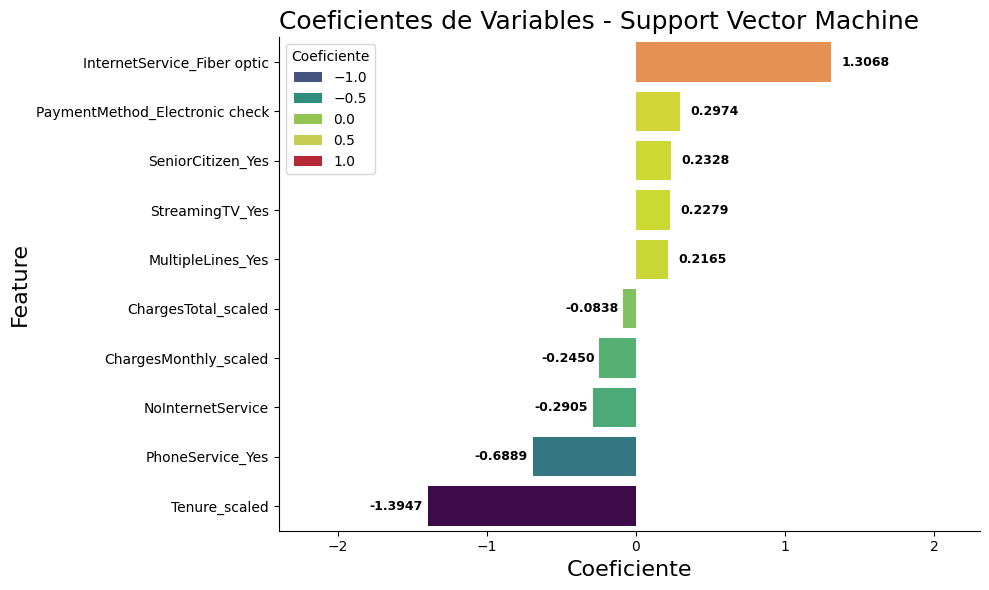

In [680]:
plot_analisis_variables(df=df_coeficientes_svm,
                        analisis='Coeficiente',
                        nombre_modelo='Support Vector Machine',
                        save='SVM',
                        n_vars=10,
                        space=0.3)


los coeficientes del Support Vector Machine (SVM) no se interpretan directamente como probabilidades. En este contexto:

El signo del coeficiente indica si una característica disminuye (negativo) o aumenta (positivo) la propensión al abandono (Churn = 1).

La magnitud del coeficiente refleja la relevancia relativa de cada variable en la decisión del clasificador, aunque no cuantifica el impacto exacto sobre la probabilidad de evento.

Variables con mayor poder de retención (coeficientes negativos):

| Variable             | Coeficiente |
|---------------------|------------|
| Tenure_scaled        | -1.3947    |
| PhoneService_Yes     | -0.6889    |
| NoInternetService    | -0.2905    |
| ChargesMonthly_scaled| -0.2450    |
| ChargesTotal_scaled  | -0.0838    |

Variables asociadas a mayor riesgo de abandono (coeficientes positivos):

| Variable                    | Coeficiente |
|------------------------------|------------|
| InternetService_Fiber optic  | 1.3068     |
| PaymentMethod_Electronic check| 0.2974    |
| SeniorCitizen_Yes            | 0.2328     |
| StreamingTV_Yes              | 0.2279     |
| MultipleLines_Yes            | 0.2165     |




# 6. Champion Model

In [681]:
pd.DataFrame(metricas_eval)

Model   Dataset  Accuracy  Precision  Recall  \
0           Best Random Forest         X    0.7698     0.5654  0.7273   
1  Best Support Vector Machine  X_linear    0.7540     0.5563  0.5488   

   F1-score     AUC  Umbral  
0    0.6362  0.8326     0.5  
1    0.5525  0.8073     0.5

In [682]:
pd.DataFrame(resultados_umbrales)

Model   Dataset  Accuracy  Precision  Recall  \
0           Best Random Forest         X    0.7148     0.4914   0.862   
1  Best Support Vector Machine  X_linear    0.6785     0.4571   0.862   

   F1-score     AUC  Umbral  
0    0.6259  0.8326    0.39  
1    0.5974  0.8073    0.38

Modelo Seleccionado

Tras los experimentos realizados y las inferencias obtenidas, se determinó que el Best Random Forest será adoptado como Champion Model para su implementación en un entorno productivo. Aunque evidencia cierto grado de sobreajuste respecto a los datos de entrenamiento, es el algoritmo que logra una mejor capacidad de generalización frente a los patrones subyacentes en los datos. Esto se refleja en que exhibe el valor más elevado de Precisión, entre aquellos modelos calibrados para garantizar un mínimo de 0.85 en Recall. Asimismo, al analizar conjuntamente su F1-score y el Área Bajo la Curva ROC (AUC), se constata que este clasificador presenta el mejor equilibrio entre sensibilidad y especificidad, además de ser el más competente para abordar el problema del desbalance de clases, situación consistente con la distribución real de los clientes en la base analizada.

In [683]:
assert hasattr(one_hot, 'transformers_')  # Esto solo existe si fue fiteado

with open(CHAMPION_PATH / 'one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(one_hot, f)

with open(CHAMPION_PATH / 'target_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

with open(CHAMPION_PATH / 'champion_model.pkl', 'wb') as f:
    pickle.dump(random_forest, f)

with open(CHAMPION_PATH / 'columns_order.pkl', 'wb') as f:
    pickle.dump(X_cv.columns.to_list(), f)

7. Pipeline Test en Ambiente de Producción

Generación de datos artificiales

In [845]:
URL = 'https://raw.githubusercontent.com/FelipeOctavio87/Proyecto_TelecomX_ML/refs/heads/main/preprocessed_TelecomX_data.json'

df_smote = pd.read_json(URL)
df_smote.head()



customerID Churn  gender SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female            No     Yes        Yes       9   
1  0003-MKNFE    No    Male            No      No         No       9   
2  0004-TLHLJ   Yes    Male            No      No         No       4   
3  0011-IGKFF   Yes    Male           Yes     Yes         No      13   
4  0013-EXCHZ   Yes  Female           Yes     Yes         No       3   

  PhoneService MultipleLines InternetService  ... DeviceProtection  \
0          Yes            No             DSL  ...               No   
1          Yes           Yes             DSL  ...               No   
2          Yes            No     Fiber optic  ...              Yes   
3          Yes            No     Fiber optic  ...              Yes   
4          Yes            No     Fiber optic  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0         Yes         Yes              No        One year              Yes   
1          No          No             Yes  Month-to-month               No   
2          No          No              No  Month-to-month              Yes   
3          No         Yes             Yes  Month-to-month              Yes   
4         Yes         Yes              No  Month-to-month              Yes   

      PaymentMethod Charges.Monthly Charges.Total  Charges.Daily  
0      Mailed check            65.6        593.30           2.19  
1      Mailed check            59.9        542.40           2.00  
2  Electronic check            73.9        280.85           2.46  
3  Electronic check            98.0       1237.85           3.27  
4      Mailed check            83.9        267.40           2.80  

[5 rows x 22 columns]

In [846]:
df_smote.rename(columns={
    'Charges.Monthly': 'ChargesMonthly',
    'Charges.Total': 'ChargesTotal',
    'Charges.Daily': 'ChargesDaily',
    'tenure': 'Tenure',
    'customerID': 'CustomerID',
    'gender': 'Gender',


}, inplace=True)

In [847]:
try:
    URL = 'https://raw.githubusercontent.com/FelipeOctavio87/Proyecto_TelecomX_ML/refs/heads/main/alta_valoracion_clientes.json'
    outliers = pd.read_json(URL)
    # Concatenar ambos DafaFrame verticalmente
    df_smote = pd.concat([df_smote, outliers], axis=0)
    # Mezclar los datos ya que sino quedaran los outliers ubicados todos al final
    df_smote = df_smote.sample(frac=1, random_state=42).reset_index(drop=True)
except Exception as e:
    print('No se encontró el archivo correspondiente, o hubo un problema al cargar los datos')
    print(f'Error: {e}')

In [848]:
proporcion = df_smote['Churn'].value_counts(normalize=True)

In [849]:
proporcion_yes = proporcion.loc['Yes']
proporcion_yes

np.float64(0.2765659955257271)

In [850]:
proporcion_no = proporcion.loc['No']
proporcion_no

np.float64(0.723434004474273)

In [851]:
df_smote

CustomerID Churn  Gender SeniorCitizen Partner Dependents  Tenure  \
0     8562-GHPPI    No  Female            No      No         No       1   
1     5196-WPYOW    No    Male            No     Yes        Yes      67   
2     8785-CJSHH    No  Female            No     Yes         No      60   
3     3594-KADLU    No    Male            No     Yes         No       3   
4     4671-VJLCL    No  Female            No      No         No      63   
...          ...   ...     ...           ...     ...        ...     ...   
7147  5310-NOOVA    No    Male            No      No         No      46   
7148  7302-ZHMHP    No  Female            No      No         No       1   
7149  7356-AYNJP    No  Female            No      No         No       4   
7150  7601-WFVZV    No    Male            No      No         No       1   
7151  1248-DYXUB    No    Male            No     Yes        Yes      52   

     PhoneService MultipleLines InternetService  ... DeviceProtection  \
0             Yes            No              No  ...               No   
1             Yes            No             DSL  ...               No   
2             Yes           Yes     Fiber optic  ...               No   
3              No            No             DSL  ...               No   
4             Yes           Yes             DSL  ...              Yes   
...           ...           ...             ...  ...              ...   
7147          Yes            No              No  ...               No   
7148          Yes            No              No  ...               No   
7149          Yes           Yes              No  ...               No   
7150          Yes            No              No  ...               No   
7151          Yes           Yes              No  ...               No   

     TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0             No          No              No  Month-to-month               No   
1            Yes          No              No        One year               No   
2             No         Yes             Yes  Month-to-month              Yes   
3            Yes          No              No  Month-to-month               No   
4            Yes         Yes              No        Two year              Yes   
...          ...         ...             ...             ...              ...   
7147          No          No              No        Two year               No   
7148          No          No              No  Month-to-month               No   
7149          No          No              No        One year               No   
7150          No          No              No  Month-to-month               No   
7151          No          No              No        Two year               No   

                PaymentMethod ChargesMonthly ChargesTotal  ChargesDaily  
0     Credit card (automatic)          19.80        19.80          0.66  
1                Mailed check          60.05      3994.05          2.00  
2            Electronic check          99.80      5985.75          3.33  
3                Mailed check          35.10       101.10          1.17  
4     Credit card (automatic)          79.85      4861.45          2.66  
...                       ...            ...          ...           ...  
7147         Electronic check          19.95       907.05          0.66  
7148             Mailed check          19.15        19.15          0.64  
7149         Electronic check          23.90        97.50          0.80  
7150             Mailed check          19.55        19.55          0.65  
7151             Mailed check          24.80      1229.10          0.83  

[7152 rows x 22 columns]

In [852]:
cat_cols = df_smote.select_dtypes(include='object').columns.tolist()
num_cols = df_smote.select_dtypes(include=['int','float'], exclude='object').columns.tolist()
cat_cols.remove('CustomerID')
cat_cols.remove('Churn')
target = 'Churn'

In [853]:
cat_cols

['Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [854]:
le_dict = {}

for col in cat_cols + [target]:
    le = LabelEncoder()
    df_smote[col] = le.fit_transform(df_smote[col])
    le_dict[col] = le


In [855]:
le_dict

{'Gender': LabelEncoder(),
 'SeniorCitizen': LabelEncoder(),
 'Partner': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'PhoneService': LabelEncoder(),
 'MultipleLines': LabelEncoder(),
 'InternetService': LabelEncoder(),
 'OnlineSecurity': LabelEncoder(),
 'OnlineBackup': LabelEncoder(),
 'DeviceProtection': LabelEncoder(),
 'TechSupport': LabelEncoder(),
 'StreamingTV': LabelEncoder(),
 'StreamingMovies': LabelEncoder(),
 'Contract': LabelEncoder(),
 'PaperlessBilling': LabelEncoder(),
 'PaymentMethod': LabelEncoder(),
 'Churn': LabelEncoder()}

In [856]:
X_smote = df_smote.drop(['CustomerID', target], axis=1)
y_smote = df_smote[target]

cat_indices = [X_smote.columns.get_loc(col) for col in cat_cols]

In [857]:
X_smote

Gender  SeniorCitizen  Partner  Dependents  Tenure  PhoneService  \
0          0              0        0           0       1             1   
1          1              0        1           1      67             1   
2          0              0        1           0      60             1   
3          1              0        1           0       3             0   
4          0              0        0           0      63             1   
...      ...            ...      ...         ...     ...           ...   
7147       1              0        0           0      46             1   
7148       0              0        0           0       1             1   
7149       0              0        0           0       4             1   
7150       1              0        0           0       1             1   
7151       1              0        1           1      52             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0                 0                2               0             0   
1                 0                0               1             1   
2                 1                1               0             1   
3                 0                0               1             0   
4                 1                0               1             1   
...             ...              ...             ...           ...   
7147              0                2               0             0   
7148              0                2               0             0   
7149              1                2               0             0   
7150              0                2               0             0   
7151              1                2               0             0   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                    0            0            0                0         0   
1                    0            1            0                0         1   
2                    0            0            1                1         0   
3                    0            1            0                0         0   
4                    1            1            1                0         2   
...                ...          ...          ...              ...       ...   
7147                 0            0            0                0         2   
7148                 0            0            0                0         0   
7149                 0            0            0                0         1   
7150                 0            0            0                0         0   
7151                 0            0            0                0         2   

      PaperlessBilling  PaymentMethod  ChargesMonthly  ChargesTotal  \
0                    0              1           19.80         19.80   
1                    0              3           60.05       3994.05   
2                    1              2           99.80       5985.75   
3                    0              3           35.10        101.10   
4                    1              1           79.85       4861.45   
...                ...            ...             ...           ...   
7147                 0              2           19.95        907.05   
7148                 0              3           19.15         19.15   
7149                 0              2           23.90         97.50   
7150                 0              3           19.55         19.55   
7151                 0              3           24.80       1229.10   

      ChargesDaily  
0             0.66  
1             2.00  
2             3.33  
3             1.17  
4             2.66  
...            ...  
7147          0.66  
7148          0.64  
7149          0.80  
7150          0.65  
7151          0.83  

[7152 rows x 20 columns]

In [858]:
X_smote.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesMonthly', 'ChargesTotal', 'ChargesDaily'],
      dtype='object')

In [859]:
cat_indices

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [860]:
smote = SMOTENC(categorical_features=cat_indices, random_state=42)
X_os, y_os = smote.fit_resample(X_smote, y_smote)

In [861]:
X_os[target] = y_os

In [868]:
df_artificial = X_os.copy()

In [869]:
for col in cat_cols + [target]:
    df_artificial[col] = le_dict[col].inverse_transform(df_artificial[col])

In [870]:
df_artificial.sample(5)

Gender SeniorCitizen Partner Dependents  Tenure PhoneService  \
5220    Male            No      No         No      26          Yes   
7337    Male           Yes     Yes         No      14          Yes   
9631  Female            No      No         No      12          Yes   
7517    Male            No      No         No       5          Yes   
394     Male           Yes      No         No      13          Yes   

     MultipleLines InternetService OnlineSecurity OnlineBackup  ...  \
5220           Yes             DSL             No           No  ...   
7337            No     Fiber optic             No           No  ...   
9631           Yes     Fiber optic             No           No  ...   
7517           Yes     Fiber optic             No           No  ...   
394            Yes     Fiber optic             No          Yes  ...   

     TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
5220          No          No              No        One year              Yes   
7337          No          No              No  Month-to-month              Yes   
9631          No         Yes              No  Month-to-month              Yes   
7517          No         Yes              No  Month-to-month              Yes   
394           No         Yes             Yes  Month-to-month              Yes   

                PaymentMethod ChargesMonthly  ChargesTotal  ChargesDaily  \
5220  Credit card (automatic)      51.550000   1295.400000      1.720000   
7337         Electronic check      84.445892   1233.284820      2.815214   
9631         Electronic check      86.849179   1056.313371      2.896955   
7517         Electronic check      92.466347    452.755428      3.079010   
394          Electronic check     106.900000   1364.300000      3.560000   

      Churn  
5220     No  
7337    Yes  
9631    Yes  
7517    Yes  
394     Yes  

[5 rows x 21 columns]

In [872]:
df_artificial['CustomerID'] = [f'99999-AD{i}' for i in range(len(df_artificial))]

In [873]:
df_artificial.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesMonthly', 'ChargesTotal', 'ChargesDaily', 'Churn',
       'CustomerID'],
      dtype='object')

In [874]:
order = ['CustomerID','Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'ChargesDaily', 'ChargesMonthly', 'ChargesTotal', 'Churn']

df_artificial = df_artificial[order]
df_artificial.head()

CustomerID  Gender SeniorCitizen Partner Dependents  Tenure PhoneService  \
0  99999-AD0  Female            No      No         No       1          Yes   
1  99999-AD1    Male            No     Yes        Yes      67          Yes   
2  99999-AD2  Female            No     Yes         No      60          Yes   
3  99999-AD3    Male            No     Yes         No       3           No   
4  99999-AD4  Female            No      No         No      63          Yes   

  MultipleLines InternetService OnlineSecurity  ... TechSupport StreamingTV  \
0            No              No             No  ...          No          No   
1            No             DSL            Yes  ...         Yes          No   
2           Yes     Fiber optic             No  ...          No         Yes   
3            No             DSL            Yes  ...         Yes          No   
4           Yes             DSL            Yes  ...         Yes         Yes   

  StreamingMovies        Contract PaperlessBilling            PaymentMethod  \
0              No  Month-to-month               No  Credit card (automatic)   
1              No        One year               No             Mailed check   
2             Yes  Month-to-month              Yes         Electronic check   
3              No  Month-to-month               No             Mailed check   
4              No        Two year              Yes  Credit card (automatic)   

  ChargesDaily ChargesMonthly  ChargesTotal  Churn  
0         0.66          19.80         19.80     No  
1         2.00          60.05       3994.05     No  
2         3.33          99.80       5985.75     No  
3         1.17          35.10        101.10     No  
4         2.66          79.85       4861.45     No  

[5 rows x 22 columns]

In [875]:
df_artificial.shape

(10348, 22)

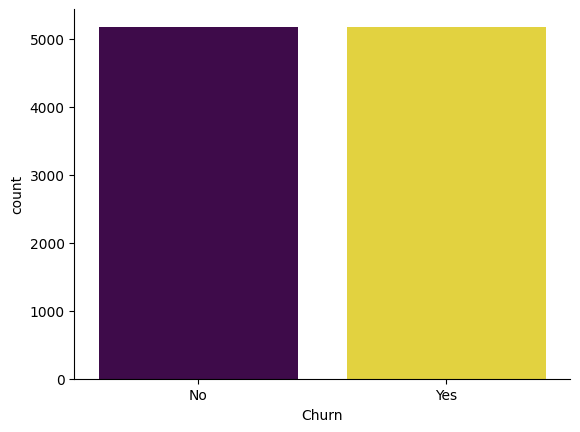

In [876]:
counts = df_artificial.groupby('Churn')['Churn'].value_counts().reset_index()
sns.barplot(data=counts, x='Churn', y='count', hue='Churn', palette=churn_colors)
sns.despine()

In [877]:
counts

Churn  count
0    No   5174
1   Yes   5174

In [878]:
proporcion_yes = int((df_artificial.shape[0] / 2)* proporcion_yes)
proporcion_no = int((df_artificial.shape[0] / 2) * proporcion_no)

In [879]:
proporcion_yes, proporcion_no

(1430, 3743)

In [880]:
df_artificial_yes = df_artificial[df_artificial['Churn'] == 'Yes'].sample(proporcion_yes)
df_artificial_no = df_artificial[df_artificial['Churn'] == 'No'].sample(proporcion_no)

In [881]:
df_artificial = pd.concat([df_artificial_yes, df_artificial_no])
df_artificial

CustomerID  Gender SeniorCitizen Partner Dependents  Tenure  \
7592  99999-AD7592    Male            No     Yes         No      64   
8714  99999-AD8714    Male            No      No        Yes       3   
8180  99999-AD8180  Female            No      No         No       1   
329    99999-AD329    Male            No      No         No      24   
3389  99999-AD3389  Female            No      No         No       7   
...            ...     ...           ...     ...        ...     ...   
418    99999-AD418    Male            No      No         No      41   
1772  99999-AD1772    Male            No      No         No      48   
5291  99999-AD5291  Female            No     Yes        Yes      22   
5756  99999-AD5756    Male            No      No         No      62   
1107  99999-AD1107  Female            No     Yes        Yes      22   

     PhoneService MultipleLines InternetService OnlineSecurity  ...  \
7592          Yes           Yes     Fiber optic             No  ...   
8714          Yes            No             DSL             No  ...   
8180          Yes            No              No             No  ...   
329           Yes           Yes             DSL            Yes  ...   
3389          Yes            No     Fiber optic             No  ...   
...           ...           ...             ...            ...  ...   
418            No            No             DSL             No  ...   
1772          Yes            No              No             No  ...   
5291          Yes            No              No             No  ...   
5756          Yes            No              No             No  ...   
1107           No            No             DSL             No  ...   

     TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
7592          No         Yes             Yes  Month-to-month              Yes   
8714          No          No              No  Month-to-month              Yes   
8180          No          No              No  Month-to-month               No   
329           No          No              No  Month-to-month              Yes   
3389          No         Yes              No  Month-to-month              Yes   
...          ...         ...             ...             ...              ...   
418           No         Yes             Yes        One year              Yes   
1772          No          No              No        Two year               No   
5291          No          No              No  Month-to-month               No   
5756          No          No              No        Two year              Yes   
1107          No         Yes              No  Month-to-month               No   

                  PaymentMethod ChargesDaily ChargesMonthly  ChargesTotal  \
7592  Bank transfer (automatic)     3.073127      92.236240   5941.872401   
8714           Electronic check     1.654570      49.571366    180.687071   
8180               Mailed check     0.681701      20.534014     20.534014   
329   Bank transfer (automatic)     1.860000      55.650000   1400.550000   
3389           Electronic check     2.660000      79.700000    586.050000   
...                         ...          ...            ...           ...   
418            Electronic check     1.710000      51.350000   2075.100000   
1772    Credit card (automatic)     0.670000      20.150000    982.950000   
5291  Bank transfer (automatic)     0.640000      19.050000    454.050000   
5756    Credit card (automatic)     0.670000      20.050000   1201.650000   
1107           Electronic check     1.310000      39.200000    849.900000   

      Churn  
7592    Yes  
8714    Yes  
8180    Yes  
329     Yes  
3389    Yes  
...     ...  
418      No  
1772     No  
5291     No  
5756     No  
1107     No  

[5173 rows x 22 columns]

In [882]:
df_artificial['Churn'].value_counts(normalize=True)

Churn
No     0.723565
Yes    0.276435
Name: proportion, dtype: float64

In [883]:

df_artificial.to_json(DATA_PATH / 'datos_artificiales_labeled.json', orient='records')

In [884]:
df_artificial_proba = df_artificial.drop('Churn', axis=1)
df_artificial_proba.to_json(DATA_PATH / 'datos_artificiales_proba.json', orient='records')

In [885]:
with open(CHAMPION_PATH / 'cat_cols.pkl', 'wb') as f:
    pickle.dump(cat_cols, f)

In [886]:
num_cols = df_artificial.select_dtypes(include=['float', 'int'], exclude='object').columns.tolist()
num_cols

['Tenure', 'ChargesDaily', 'ChargesMonthly', 'ChargesTotal']

In [887]:
with open(CHAMPION_PATH / 'num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f)

Pipeline de prueba

In [891]:
def run_pipeline(file: str, mode: str='production'):



    start_time = timer()

    with open(CHAMPION_PATH / 'one_hot_encoder.pkl', 'rb') as f:
        one_hot = pickle.load(f)

    with open(CHAMPION_PATH / 'target_encoder.pkl', 'rb') as f:
        target_encoder = pickle.load(f)

    with open(CHAMPION_PATH / 'champion_model.pkl', 'rb') as f:
        modelo = pickle.load(f)

    with open(CHAMPION_PATH / 'columns_order.pkl', 'rb') as f:
       order_cols = pickle.load(f)

    with open(CHAMPION_PATH / 'cat_cols.pkl', 'rb') as f:
       cat_cols = pickle.load(f)

    with open(CHAMPION_PATH / 'num_cols.pkl', 'rb') as f:
       num_cols = pickle.load(f)
    if 'ChargesDaily' in num_cols:
        num_cols.remove('ChargesDaily')

    data = pd.read_json(file)

    if 'ChargesDaily' in data.columns:
        data.drop('ChargesDaily', axis=1)

    log = datetime.now().strftime('%Y%m%d_%H%M%S')

    if mode == 'production':
        # Conservar IDs de clientes
        customers_ids = data['CustomerID']
        # Descartar columnas no utilizadas por el modelo
        data = data.drop('CustomerID', axis=1)
        # Codificar variables categoricas
        data = one_hot.transform(data)
        # Generar data frame
        df = pd.DataFrame(data, columns=order_cols)
        # Obtener probabilidad de churn con el modelo champion
        pred_proba = modelo.predict_proba(df)[:, 1]
        # Obtener churn label con el modelo champion

        pred_labels = (pred_proba >= 0.39).astype(int)
        # Generar DataFrame con los resultados
        results = pd.DataFrame({'CustomerID': customers_ids,
                                'Probabilidad Churn': np.round(pred_proba, 4),
                                'Churn': pred_labels})
        # Guardar los resultados del modelo en archivo JSON
        results.to_json(PRODUCTION_PATH / f'pipeline_results_{log}.json')
        return results

    elif mode == 'monitor':
        # Descartar columnas no utilizadas por el modelo
        data = data.drop('CustomerID', axis=1)
        # Separar labels para evaluación del modelo
        y = data['Churn']
        # Codificar variable respuesta
        y = label_encoder.transform(y).ravel()
        # Preparar datos para realizar predicciones
        data = data.drop('Churn', axis=1)
        # Codificar variables categóricas
        data = one_hot.transform(data)
        # Generar DataFrame
        df = pd.DataFrame(data, columns=order_cols)
        # Obtener predicciones del modelo sin umbral
        y_preds = modelo.predict(df)
        # Obtener métricas de evaluación sin umbral
        metricas = metricas_evaluacion(modelo, df, y, f'Champion_{log}', conjunto='X')
        # Realizar predicciones de probabilidades con el modelo
        y_proba = modelo.predict_proba(df)[:, 1]
        # Obtener predicciones del modelo con umbral
        y_preds_proba = (y_proba >= 0.39).astype(int)
        # Obtener métricas de evaluacion con umbral
        metricas_umbral = metricas_evaluacion(modelo, df, y, f'Champion_{log}', conjunto='X', umbral=0.39)
        # Finalizar timer
        end_time = timer()
        # Guardar tiempo de predicción
        metricas['prediction_time'] = np.round(end_time - start_time)
        metricas_umbral['prediction_time'] = np.round(end_time - start_time)
        # Lista para guardar las metricas
        df_metricas = []
        # Agregar metricas a la lista para generar DataFrame
        df_metricas.append(metricas)
        df_metricas.append(metricas_umbral)

        df_metricas = pd.DataFrame(df_metricas)
        df_metricas.to_json(MONITOR_PATH / f'monitor_results_{log}.json')
        return df_metricas
    else:
        raise ValueError('Esta función recibe solo mode = "production" o "monitor"')

In [892]:
URL =  'https://raw.githubusercontent.com/FelipeOctavio87/Proyecto_TelecomX_ML/refs/heads/main/datos_artificiales_de_prueba.json'
run_pipeline(file=URL, mode='production')

CustomerID  Probabilidad Churn  Churn
0     99999-AD7592              0.5428      1
1     99999-AD8714              0.7181      1
2     99999-AD8180              0.9864      1
3      99999-AD329              0.2902      0
4     99999-AD3389              0.6600      1
...            ...                 ...    ...
5168   99999-AD418              0.4263      1
5169  99999-AD1772              0.0823      0
5170  99999-AD5291              0.5274      1
5171  99999-AD5756              0.2053      0
5172  99999-AD1107              0.4812      1

[5173 rows x 3 columns]

In [893]:
URL =  'https://raw.githubusercontent.com/FelipeOctavio87/Proyecto_TelecomX_ML/refs/heads/main/datos_artificiales_etiquetados.json'
run_pipeline(file=URL, mode='production')

CustomerID  Probabilidad Churn  Churn
0     99999-AD7592              0.5428      1
1     99999-AD8714              0.7181      1
2     99999-AD8180              0.9864      1
3      99999-AD329              0.2902      0
4     99999-AD3389              0.6600      1
...            ...                 ...    ...
5168   99999-AD418              0.4263      1
5169  99999-AD1772              0.0823      0
5170  99999-AD5291              0.5274      1
5171  99999-AD5756              0.2053      0
5172  99999-AD1107              0.4812      1

[5173 rows x 3 columns]